In [1]:
%matplotlib notebook
%matplotlib inline

from tqdm.notebook import tqdm

import os
from packaging import version

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from time import sleep

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})
from PIL import Image
import matplotlib.patches as mpatches

# Below plots are based on .pkl files as they are plotted based on each iteration

In [2]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})


cmap = sns.color_palette("rocket_r", as_cmap=True)
_cmap = sns.color_palette("rocket", as_cmap=True)


softmatch = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/reset32_scaler_4_d3b0e90.pkl') # best_st_plot_60c84b7
softmatch_weights = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_0.5.pkl')
iou3d = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
# iou3d = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/3diou.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
iou3d_old_thresh = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/iou3d_old_thresh2.pkl') 
# This is based on FG+UC+BG with class agnostic local thresholds , it needs a re-run to get the correct class agnostic scores based on UC_FP+BG
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_ablation1.pkl') 
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/a8_scores.pkl') 
# ablation1_df = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl') 


# df2 =  pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl')
# scores_6 = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_6.pkl')
smt_old = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/old_thresh.pkl') #smt = softmatchthresholding _+ old 3diou
smt_new =  pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/new_thresh.pkl') #smt = softmatchthresholding + new 3diou


In [3]:
print(pd. __version__)

2.0.1


In [4]:
smt_old = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/3diou_0.33_thresh.pkl')
smt_new =  pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_0.33_restrict.pkl')

In [5]:
zero_thresh_nl = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/no_thresh_non_linear.pkl')
zero_thresh_l = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/no_thresh_linear.pkl')

### TP_FP_FN_TN histograms based on adaptive thresholding

##### 1. Run to create Dataframes


In [6]:
def tp_fp_fn_hist(df,title,ylim=False):
    
    fg_gt_thresh = [0.7, 0.5, 0.5]
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'tn':p[-2],'fp':p[0],'fn':p[3],'tp':p[2] }
    f, axes = plt.subplots(1,3, 
                        figsize=(15,4))
    if ylim:
        axes[0].set_ylim(0,10000)
        axes[1].set_ylim(0,2500)
        axes[2].set_ylim(0,1000)
    

    for i in range(0,3):
        cls_df = df[df['class_labels'] == i + 1]
        cls_mask = df['class_labels'] == i + 1
        tp_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        df.loc[cls_mask,'type'] = cls_df['type']
        g = sns.histplot(ax=axes[i],data=cls_df, x="iou_roi_pl",hue='type',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, alpha=0.8, palette=palette,hue_order=palette.keys(),edgecolor="None")
        for rectangle in g.patches:
            print(rectangle.get_height())
            break
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.title(title)
    plt.show()
    return df

In [7]:
def convert_to_df(df):
    temp_dict = {
    'iou_roi_gt': df['iou_roi_gt'],
    'iou_roi_pl': df['iou_roi_pl'],
    'iteration' : df['iteration'],
    'class_labels': df['class_labels'],
    'pred_scores': df['pred_scores'],
    'ema_mean': df['ema_mean'],
    'ema_var': df['ema_var'],
    'batch_mean': df['batch_mean'],
    'batch_var': df['batch_var'],
}

    ret_df = pd.DataFrame(temp_dict)
    ret_df['type'] = 'none'
    ret_df['epoch'] = (ret_df['iteration']) // 24 + 1
    ret_df = ret_df[0.25 <= ret_df['iou_roi_pl']]
    return ret_df

0.0
0.0
0.0


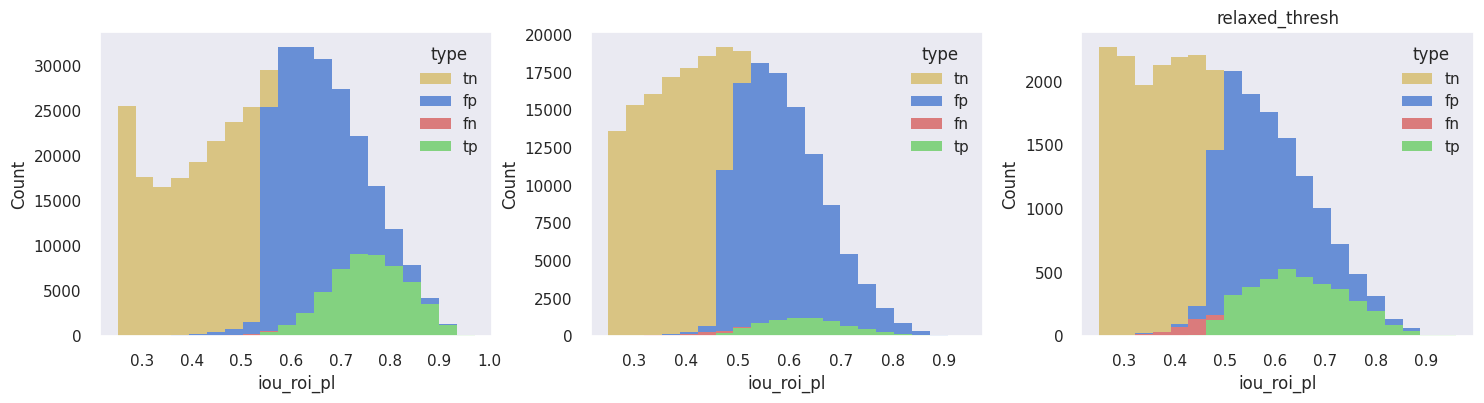

In [8]:
old_df = convert_to_df(smt_old)
relaxed_thresh = tp_fp_fn_hist(old_df,'relaxed_thresh')


0.0
0.0
0.0


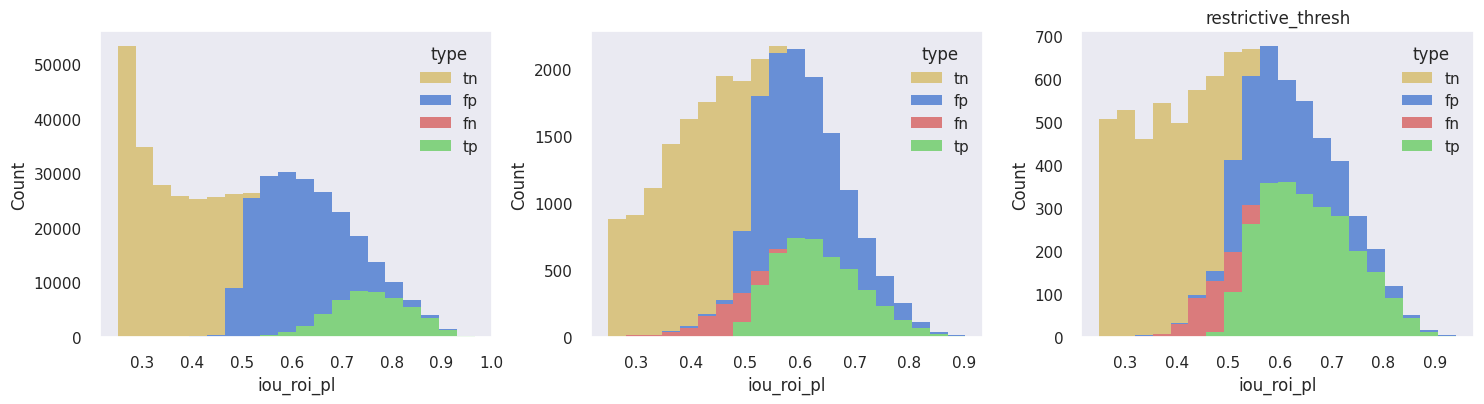

In [9]:
new_df = convert_to_df(smt_new)
res_thresh = tp_fp_fn_hist(new_df,'restrictive_thresh')


0.0
0.0
0.0


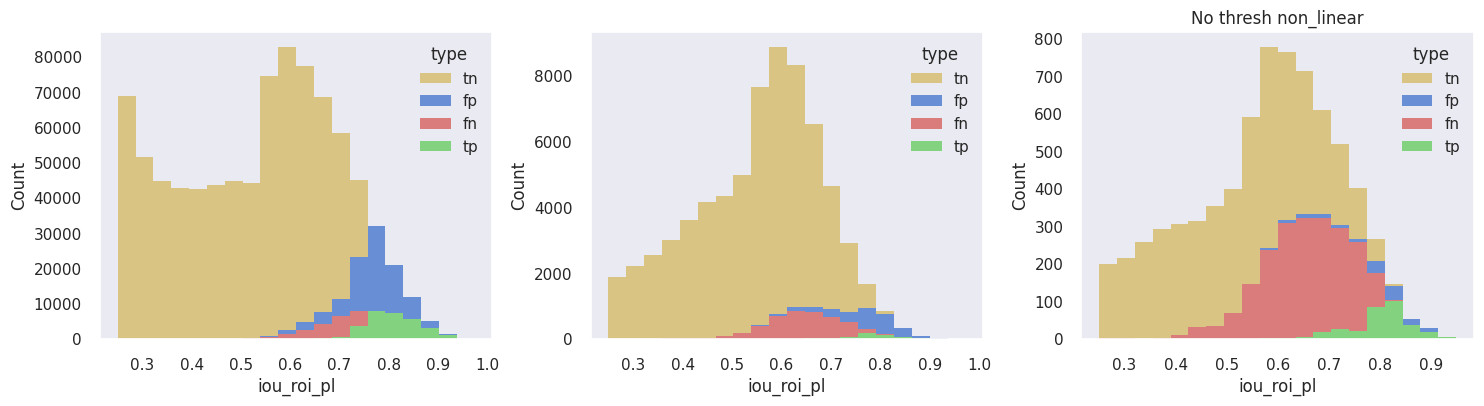

In [10]:
zero_thresh_nl = convert_to_df(zero_thresh_nl)
no_thresh_non_linear =  tp_fp_fn_hist(zero_thresh_nl,'No thresh non_linear')

0.0
0.0
0.0


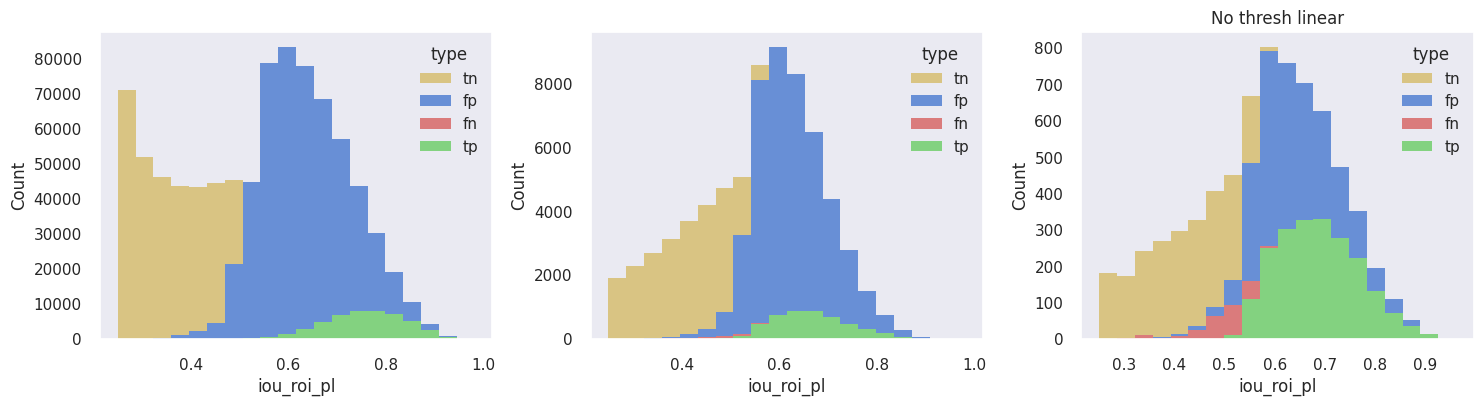

In [11]:
zero_thresh_l = convert_to_df(zero_thresh_l)
no_thresh_linear =  tp_fp_fn_hist(zero_thresh_l,'No thresh linear')

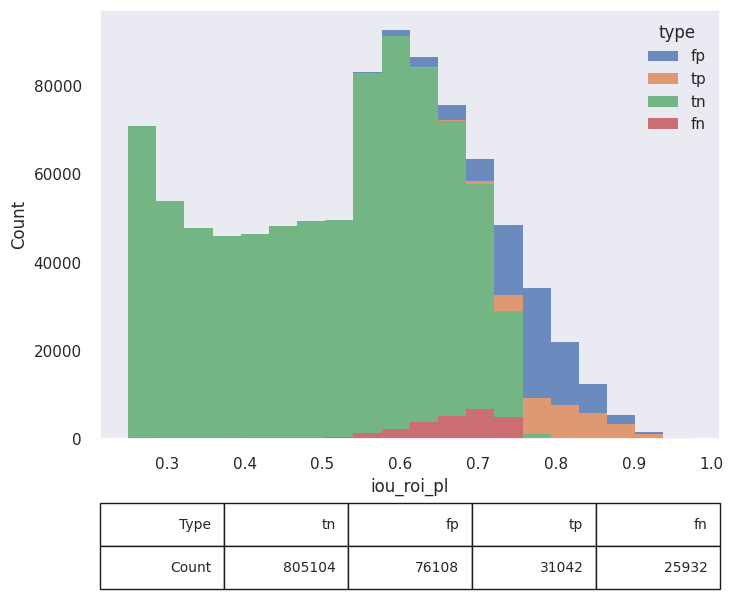

In [12]:
g = sns.histplot(data=no_thresh_non_linear, x="iou_roi_pl",hue='type',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, alpha=0.8,edgecolor="None")

# plt.show()
val = (no_thresh_non_linear['type'].value_counts().reset_index())
counts = (list(val['count'].tolist()))
cols = list(val['type'].tolist())
# table_data = [[str(c)] for c in counts] + [[str(col)] for col in cols]
table_data = [["Type"] + [str(col) for col in cols], ["Count"] + [str(c) for c in counts]]
table = plt.table(cellText=table_data, loc='bottom', bbox=[0, -0.35, 1, 0.2])
# Format the table cells
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.25)
plt.subplots_adjust(bottom=0.1)
plt.show()

##### To visualize KDE Plots (Optional)

[]


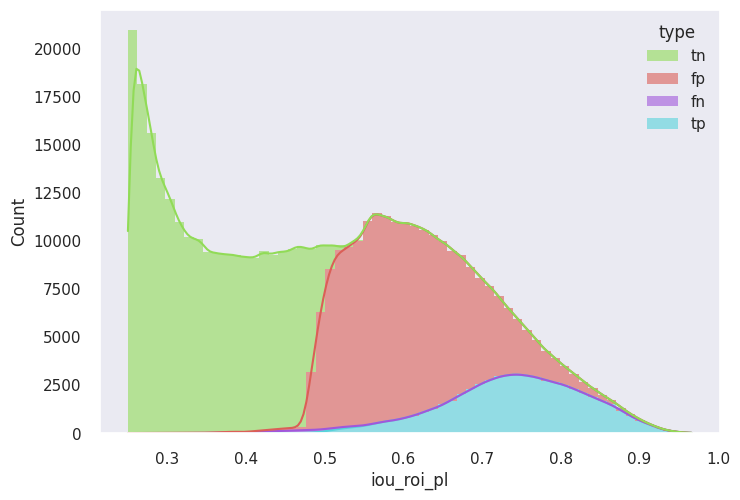

In [13]:
p = sns.color_palette("hls", 4)
sns.set_theme(style='dark')
# palette = {'tn':p[-2],'fp':p[0],'fn':p[3],'tp':p[2] }
palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
g = sns.histplot(data=res_thresh, x="iou_roi_pl",hue='type',fill=True, kde=True,stat='count',multiple="stack",legend=True, bins=60, alpha=0.6, palette=palettes,hue_order=['tn', 'fp', 'fn', 'tp'],edgecolor="None")
# g.map(sns.histplot)
# g.add_legend()
tp_patches = [patch for patch in g.patches if patch.get_label() == 'tp']
# # hue_type = patch.get_label()
# height = g.patches
# val = []
# for i,h in enumerate(height):
#     # print(i)
#     # print(h.get_x())
#     if i%2 == 0:
#         val.append(h.get_height())
#         print(h.get_x(),h.get_height())
        
# hline = max(val)
# print(hue_type)
print(tp_patches)

plt.show()

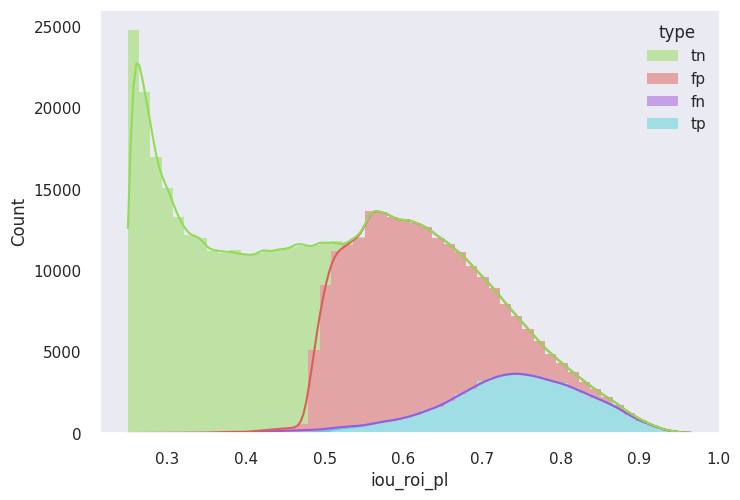

In [14]:
import seaborn as sns
import matplotlib.patches as mpatches
# Create the histogram
g = sns.histplot(data=res_thresh, x="iou_roi_pl", hue='type', fill=True, kde=True,
                 stat='count', multiple="stack", legend=True, bins=50, alpha=0.5,
                 palette=palettes, hue_order=['tn', 'fp', 'fn', 'tp'], edgecolor="None")

# Find the patches corresponding to 'tp'
# tp_patch = mpatches.Patch(color=p[2], label='tp')
# fn_patch = mpatches.Patch(color=p[3], label='fn')
# tn_path = mpatches.Patch(color=p[0], label='tn')
# fp_path = mpatches.Patch(color=p[1], label='fp')

# g.legend(handles=[tp_patch,fn_patch,tn_path,fp_path],labels=['tp','fn','tn','fp'])
color = ([patch.get_facecolor() for patch in g.patches])
height = ([patch.get_height() for patch in g.patches])
tp_heights = [height for height, color in zip(height, color) if np.array_equal(color, p[2]+ (0.5,))]
plt.show()
# Get the maximum height of 'tp'
# max_tp_height = max([patch.get_height() for patch in tp_patches])

# # Print the maximum height
# print("Maximum height of 'tp':", max_tp_height)

In [16]:
def tp_fp_fn_kde(df,title,ylim=False):
    cls_map = {0:'Car',1:'Ped',2:'Cyc'}
    
    fg_gt_thresh = [0.7, 0.5, 0.5]
    p = sns.color_palette("hls", 4)
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    f, axes = plt.subplots(1,3, 
                        figsize=(15,6))
    if ylim:
        axes[0].set_ylim(0,5000)
        axes[1].set_ylim(0,600)
        axes[2].set_ylim(0,250)
    

    # Find the patches corresponding to 'tp'
    tp_patch = mpatches.Patch(color=p[2], label='tp')
    fn_patch = mpatches.Patch(color=p[3], label='fn')
    tn_patch = mpatches.Patch(color=p[0], label='fp')
    fp_patch = mpatches.Patch(color=p[1], label='tn')


    for i in range(0,3):
        cls_df = df[df['class_labels'] == i + 1]
        cls_mask = df['class_labels'] == i + 1
        tp_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        df.loc[cls_mask,'type'] = cls_df['type']
        g = sns.histplot(ax=axes[i],data=cls_df, x="iou_roi_pl", hue='type', fill=True, kde=False,  
                 stat='count', multiple="stack", legend=False, bins=50, alpha=0.8,
                 palette=palettes, hue_order=['tn', 'fp', 'fn', 'tp'], edgecolor="None")
        axes[i].set_title(cls_map[i])
        # print(cls_df['type'].value_counts())
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        print(cls_df['type'].value_counts())
        val = (cls_df['type'].value_counts().reset_index())
        counts = (list(val['count'].tolist()))
        cols = list(val['type'].tolist())
        # table_data = [[str(c)] for c in counts] + [[str(col)] for col in cols]
        table_data = [["Type"] + [str(col) for col in cols], ["Count"] + [str(c) for c in counts]]
        table =axes[i].table(cellText=table_data, loc='bottom', bbox=[0, -0.35, 1, 0.2])
        # Format the table cells
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.25)
    axes[2].legend(handles=[tp_patch,fp_patch,tn_patch,fn_patch],labels=['tp','fn','tn','fp'],bbox_to_anchor=(1.1, 1.05))
        # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    # plt.legend()
   

    plt.suptitle(title,y=1.05)
    plt.show()
    return df


##### False Negatives are near the TP region because of the varying thresholds

type
tn    210303
fp    179169
tp     48975
fn        79
Name: count, dtype: int64
type
tn    10495
fp     8225
tp     4519
fn      895
Name: count, dtype: int64
type
tn    3735
tp    2520
fp    1781
fn     387
Name: count, dtype: int64


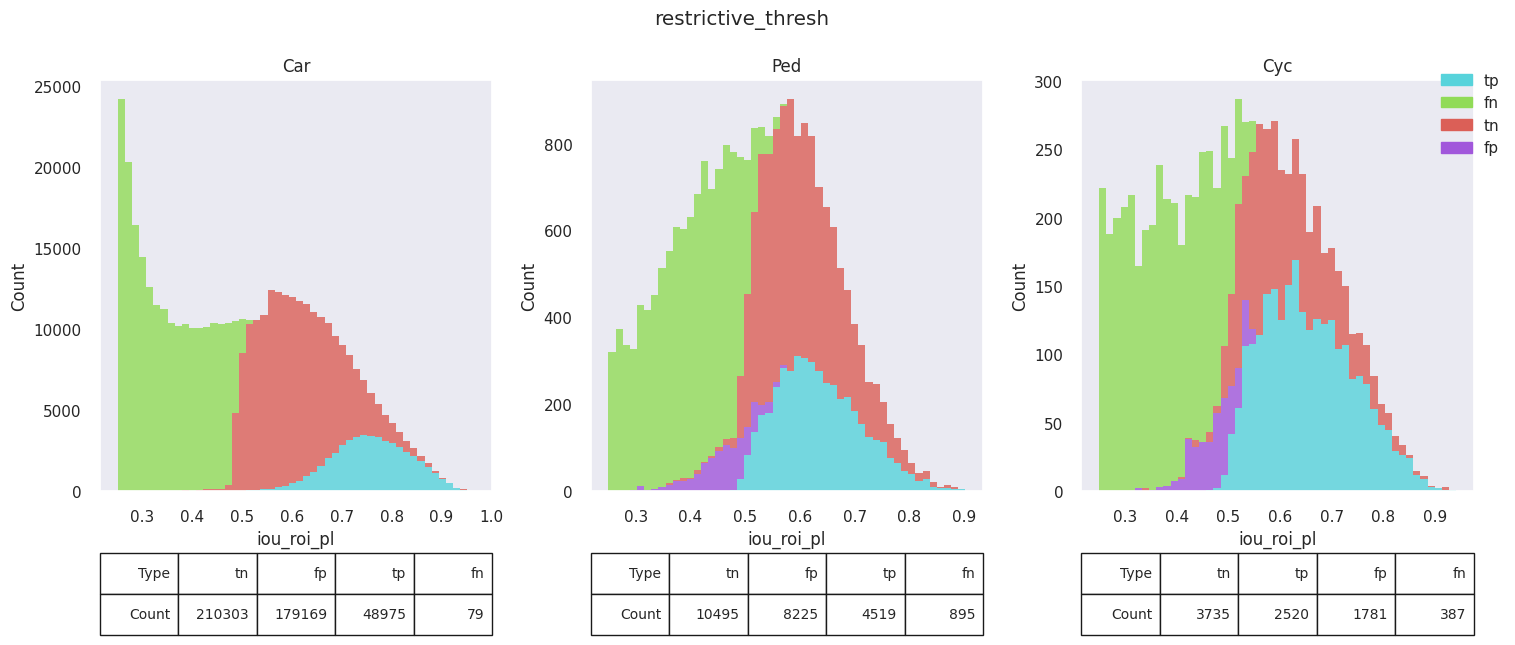

type
tn    210303
fp    179169
tp     48975
fn        79
Name: count, dtype: int64
type
tn    10495
fp     8225
tp     4519
fn      895
Name: count, dtype: int64
type
tn    3735
tp    2520
fp    1781
fn     387
Name: count, dtype: int64


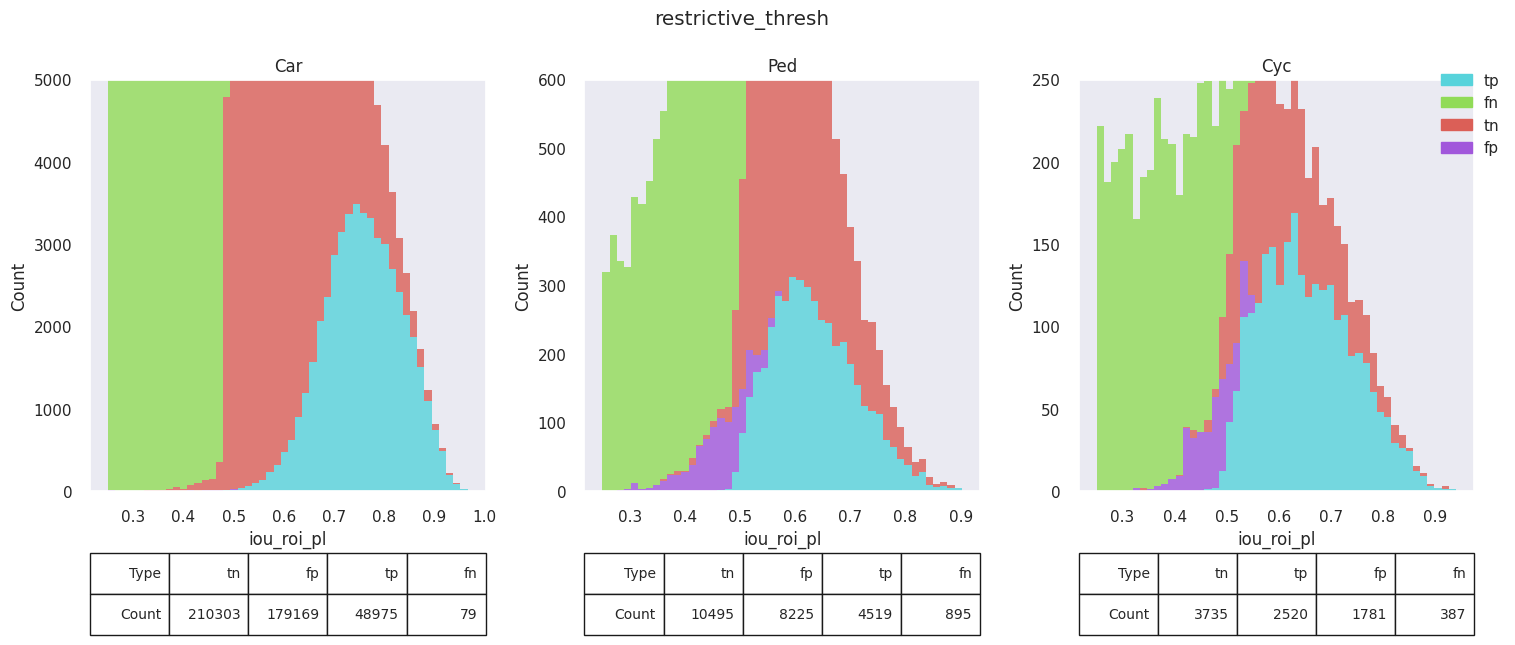

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0          0.685184    0.701416        0.0             1     0.997127  \
1          0.000000    0.701694        0.0             2     0.765312   
2          0.612229    0.655362        0.0             1     0.791199   
3          0.000000    0.606616        0.0             2     0.833461   
4          0.792858    0.836800        0.0             1     0.998138   
...             ...         ...        ...           ...          ...   
1409921    0.428183    0.579811     1439.0             2     0.499169   
1409922    0.426809    0.692184     1439.0             2     0.812090   
1409923    0.385259    0.502816     1439.0             2     0.721074   
1409924    0.311869    0.500046     1439.0             2     0.499289   
1409925    0.521765    0.540902     1439.0             2     0.454171   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   fp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   tp    1.0  
...           ...       ...         ...        ...  ...    ...  
1409921  0.573839  0.019526    0.549618   0.021452   fp   60.0  
1409922  0.573839  0.019526    0.549618   0.021452   fp   60.0  
1409923  0.573839  0.019526    0.549618   0.021452   tn   60.0  
1409924  0.573839  0.019526    0.549618   0.021452   tn   60.0  
1409925  0.573839  0.019526    0.549618   0.021452   fn   60.0  

[471083 rows x 11 columns]

In [17]:
tp_fp_fn_kde(res_thresh,'restrictive_thresh')
tp_fp_fn_kde(res_thresh,'restrictive_thresh',True)

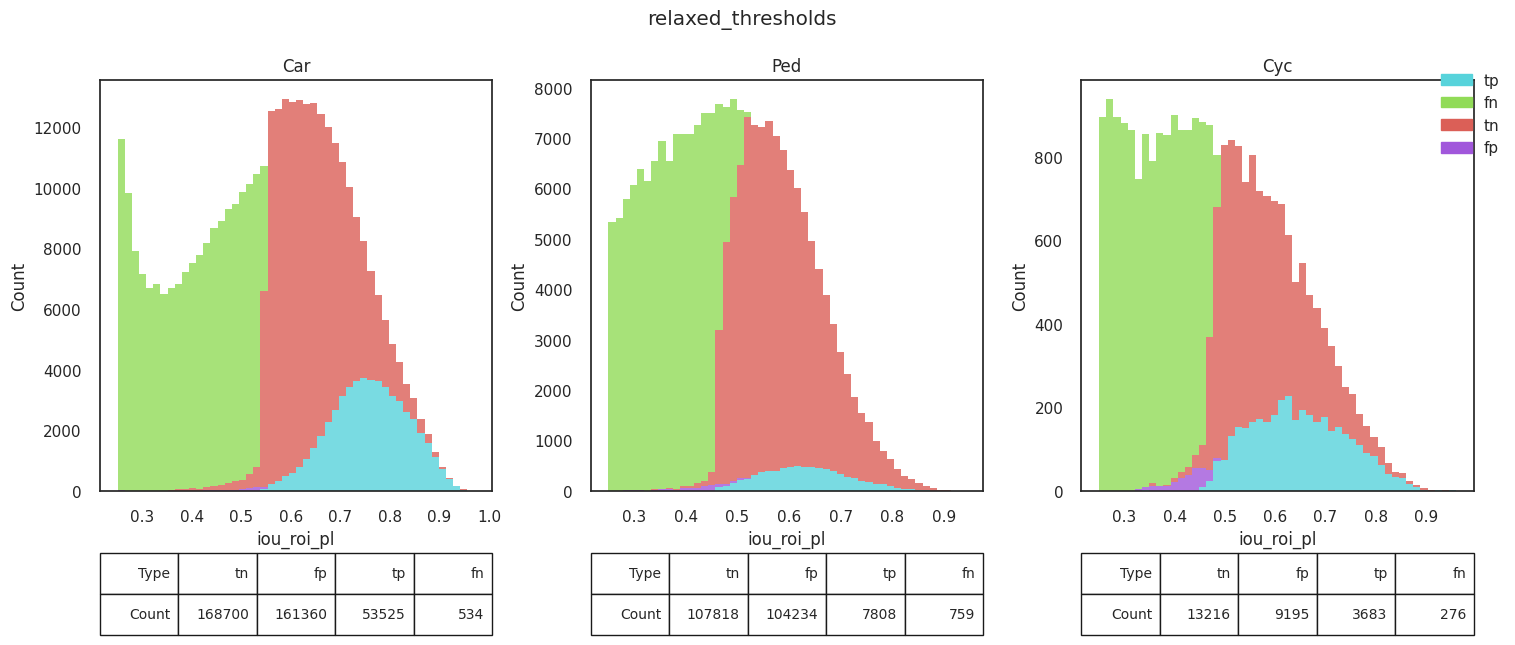

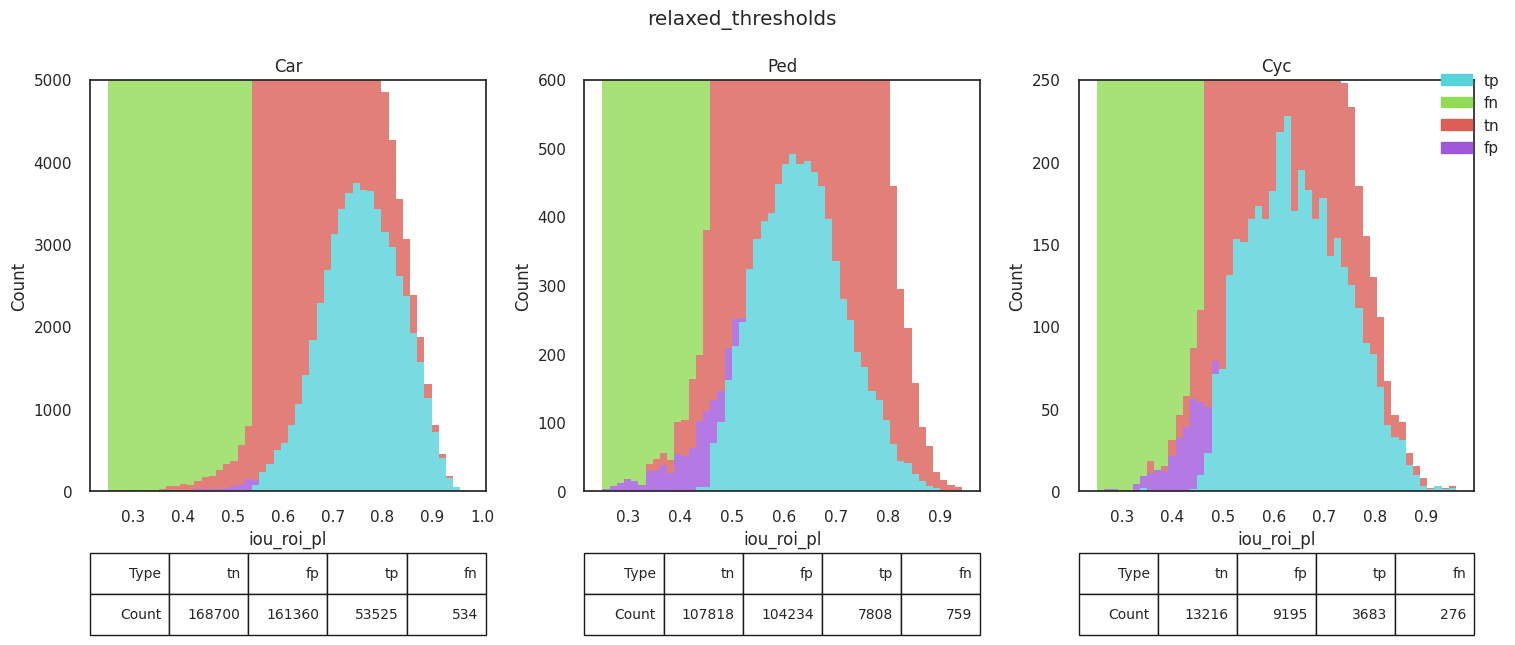

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0          0.000000    0.737889        0.0             1     0.276245  \
1          0.759624    0.885500        0.0             1     0.999320   
2          0.000000    0.587686        0.0             1     0.085128   
3          0.593041    0.814030        0.0             1     0.999633   
4          0.754584    0.738706        0.0             1     0.998924   
...             ...         ...        ...           ...          ...   
1410868    0.000000    0.518355     1439.0             2     0.328488   
1410870    0.000000    0.494149     1439.0             1     0.104503   
1410871    0.000000    0.271440     1439.0             1     0.014293   
1410872    0.000000    0.337491     1439.0             2     0.000168   
1410873    0.000000    0.494149     1439.0             1     0.215524   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   tp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   tp    1.0  
...           ...       ...         ...        ...  ...    ...  
1410868  0.520585  0.020454    0.524567   0.019324   tn   60.0  
1410870  0.548829  0.029893    0.555316   0.029141   tn   60.0  
1410871  0.548829  0.029893    0.555316   0.029141   tn   60.0  
1410872  0.520585  0.020454    0.524567   0.019324   tn   60.0  
1410873  0.548829  0.029893    0.555316   0.029141   tn   60.0  

[631108 rows x 11 columns]

In [83]:
tp_fp_fn_kde(relaxed_thresh,'relaxed_thresholds')
tp_fp_fn_kde(relaxed_thresh,'relaxed_thresholds',True)

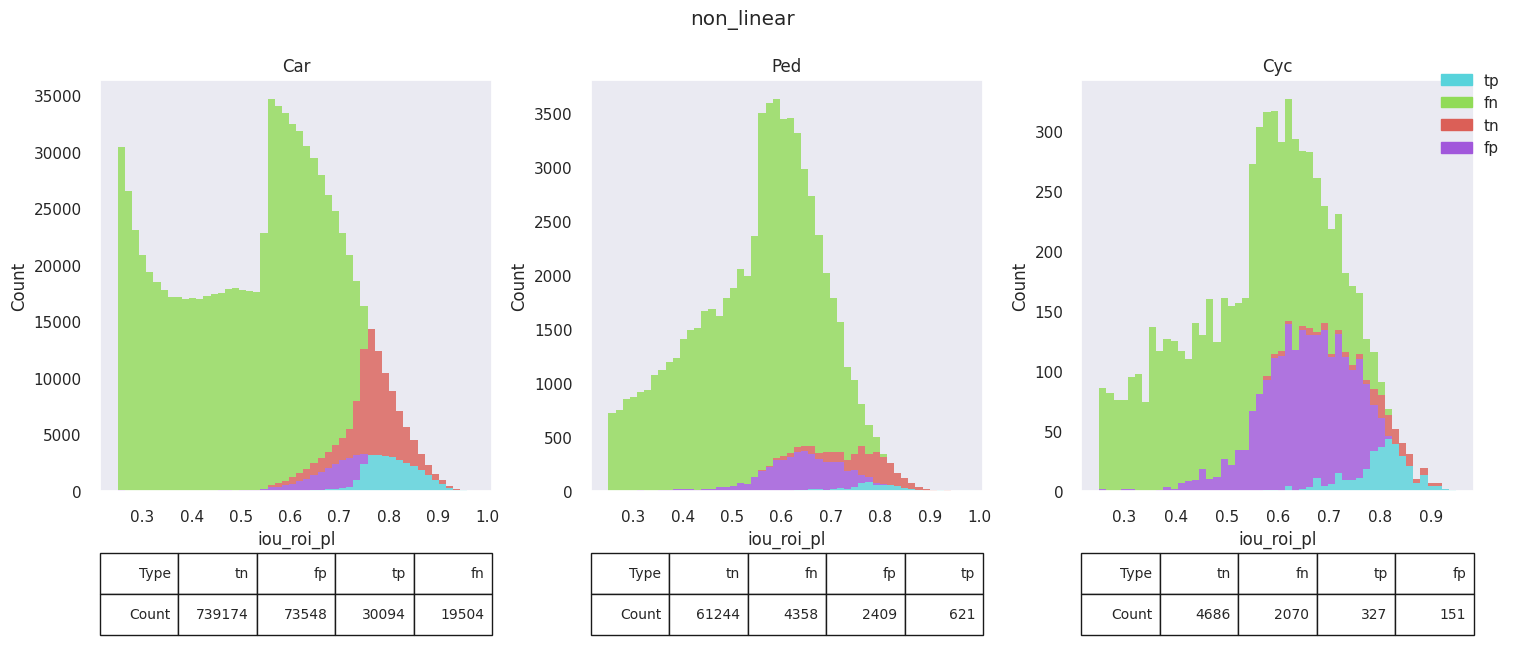

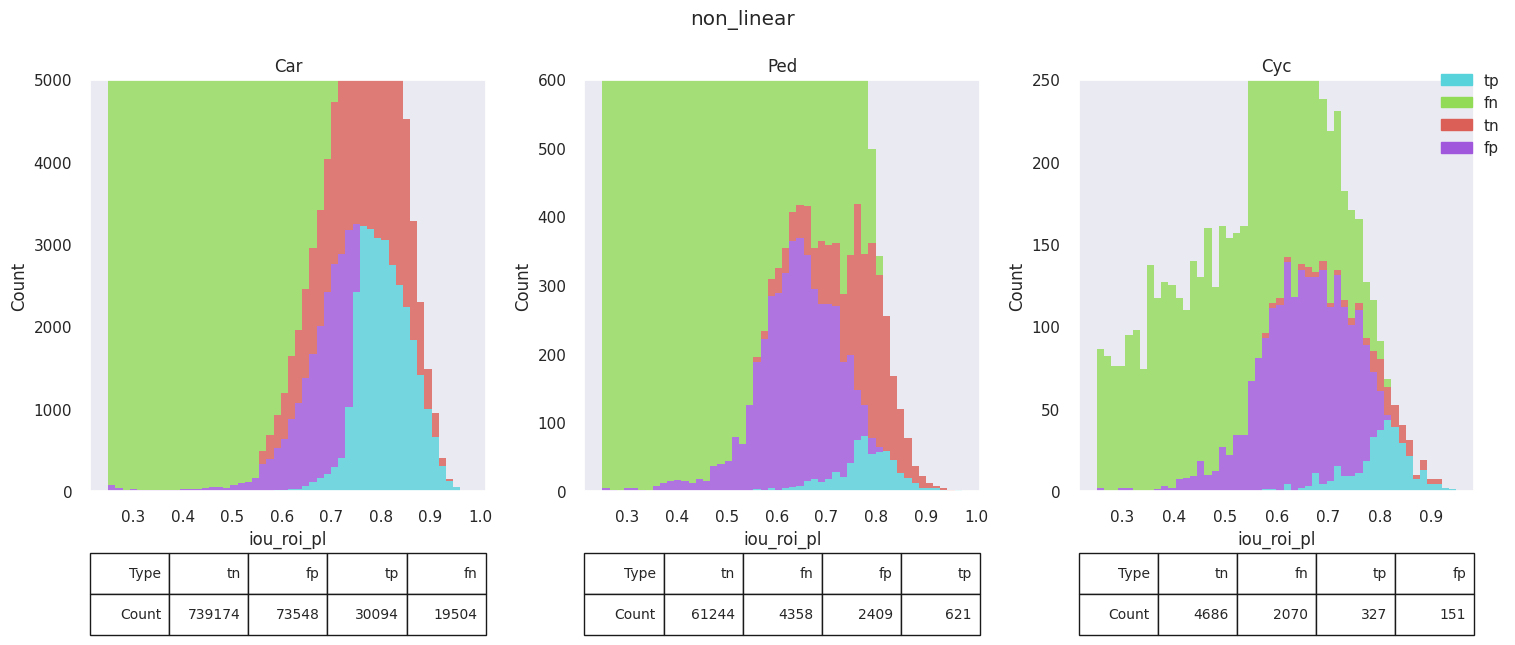

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0           0.00000    0.609064        0.0             1     0.608078  \
1           0.00000    0.753660        0.0             1     0.883725   
2           0.00000    0.771966        0.0             1     0.665967   
3           0.59491    0.705123        0.0             1     0.932722   
4           0.00000    0.651577        0.0             1     0.717420   
...             ...         ...        ...           ...          ...   
1408960     0.00000    0.491774     1439.0             1     0.007021   
1408961     0.00000    0.258140     1439.0             1     0.077568   
1408962     0.00000    0.347594     1439.0             2     0.017698   
1408964     0.00000    0.430008     1439.0             1     0.033237   
1408969     0.00000    0.515750     1439.0             1     0.000551   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.555556  0.000000    0.000000   1.000000   fp    1.0  
1        0.555556  0.000000    0.000000   1.000000   fp    1.0  
2        0.555556  0.000000    0.000000   1.000000   fp    1.0  
3        0.555556  0.000000    0.000000   1.000000   fp    1.0  
4        0.555556  0.000000    0.000000   1.000000   fp    1.0  
...           ...       ...         ...        ...  ...    ...  
1408960  0.755225  0.028051    0.509038   0.028293   tn   60.0  
1408961  0.755225  0.028051    0.509038   0.028293   tn   60.0  
1408962  0.809150  0.017074    0.567324   0.016373   tn   60.0  
1408964  0.755225  0.028051    0.509038   0.028293   tn   60.0  
1408969  0.755225  0.028051    0.509038   0.028293   tn   60.0  

[938186 rows x 11 columns]

In [90]:
tp_fp_fn_kde(no_thresh_non_linear,'non_linear')
tp_fp_fn_kde(no_thresh_non_linear,'non_linear',True)


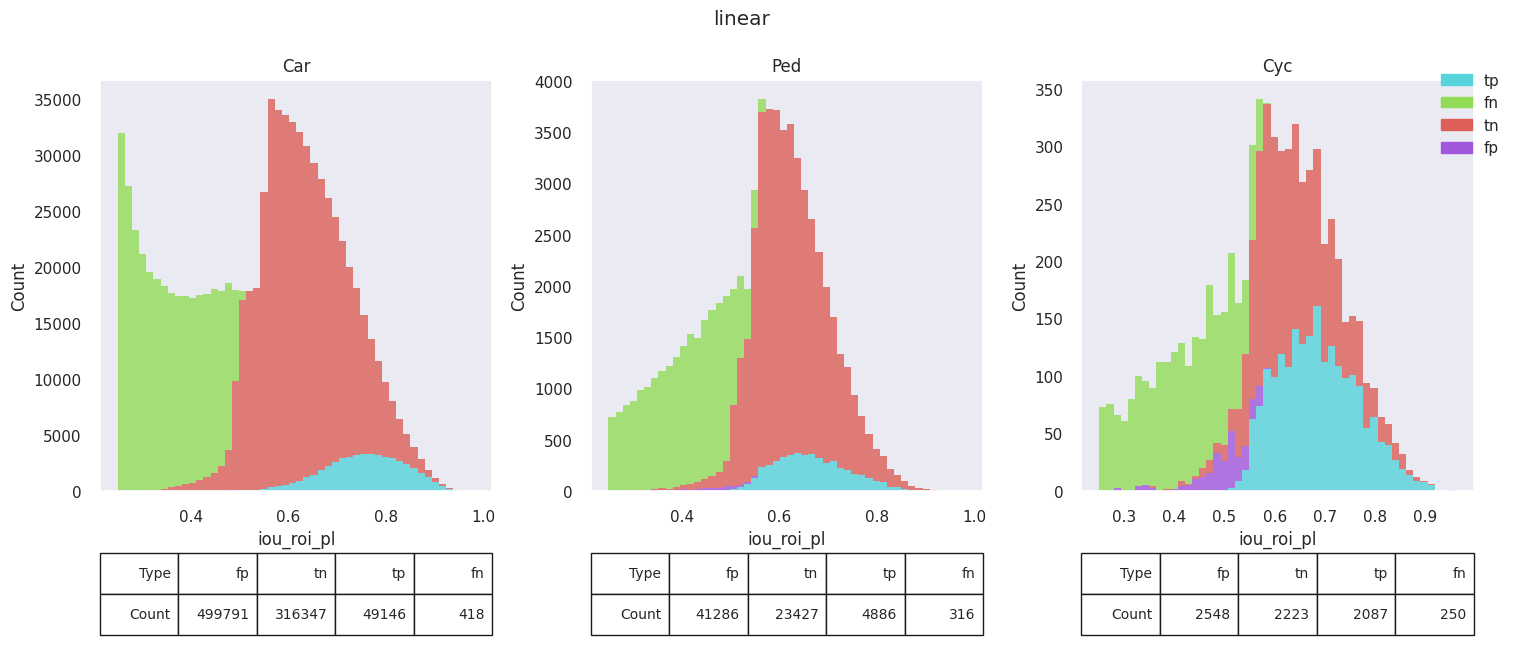

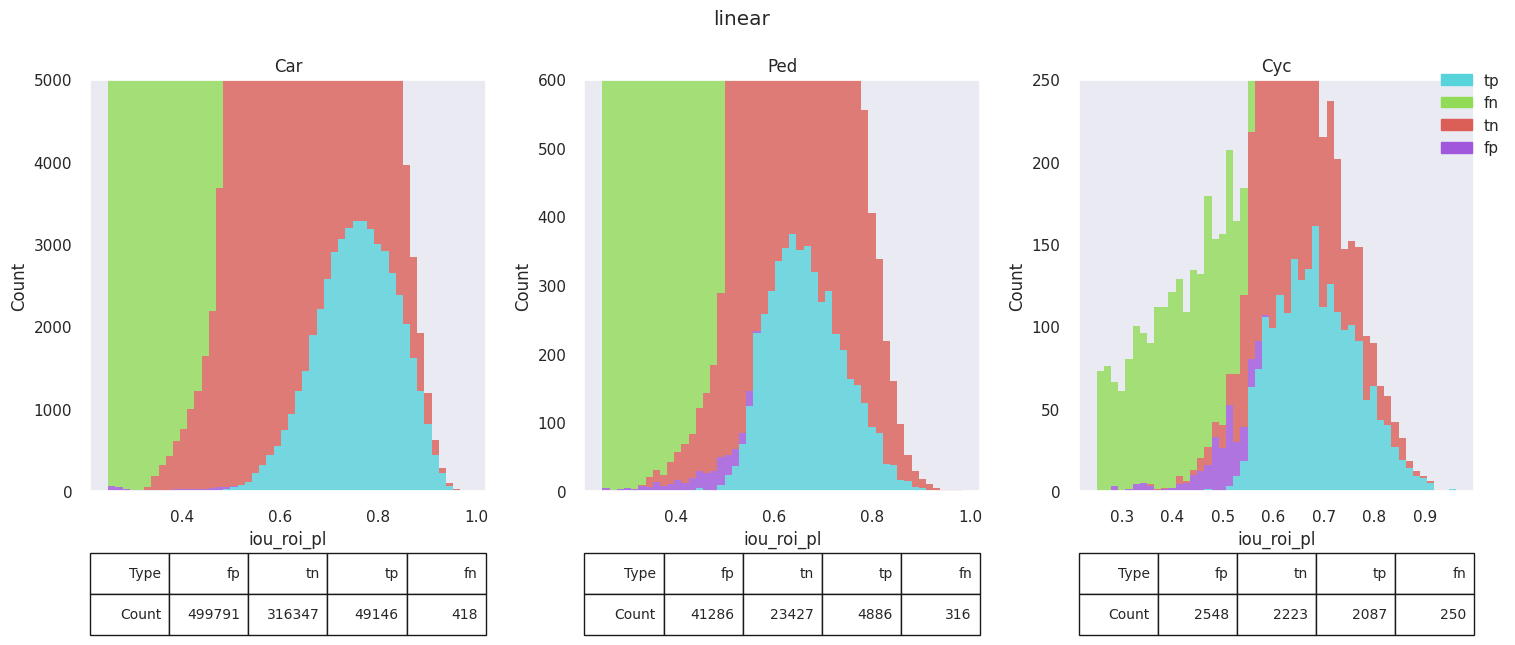

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0          0.590828    0.823261        0.0             1     0.985154  \
1          0.000000    0.573023        0.0             1     0.876250   
2          0.609215    0.587807        0.0             1     0.610560   
3          0.000000    0.834765        0.0             1     0.074297   
4          0.000000    0.665250        0.0             1     0.825216   
...             ...         ...        ...           ...          ...   
1412327    0.000000    0.317107     1439.0             1     0.013604   
1412330    0.000000    0.294051     1439.0             1     0.000053   
1412332    0.000000    0.293455     1439.0             2     0.000082   
1412334    0.000000    0.497533     1439.0             1     0.072880   
1412335    0.000000    0.441029     1439.0             1     0.003772   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   fp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   fp    1.0  
...           ...       ...         ...        ...  ...    ...  
1412327  0.502952  0.028147    0.502744   0.027478   tn   60.0  
1412330  0.502952  0.028147    0.502744   0.027478   tn   60.0  
1412332  0.568608  0.017242    0.562946   0.017833   tn   60.0  
1412334  0.502952  0.028147    0.502744   0.027478   tn   60.0  
1412335  0.502952  0.028147    0.502744   0.027478   tn   60.0  

[942725 rows x 11 columns]

In [92]:
tp_fp_fn_kde(no_thresh_linear,'linear')
tp_fp_fn_kde(no_thresh_linear,'linear',True)

In [93]:
def tp_fp_fn_ecdf(df,title,ylim=False):
    cls_map = {0:'Car',1:'Ped',2:'Cyc'}
    fg_gt_thresh = [0.7, 0.5, 0.5]
    p = sns.color_palette("hls", 4)
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    f, axes = plt.subplots(1,3, 
                        figsize=(15,4))
    if ylim:
        axes[0].set_ylim(0,10000)
        axes[1].set_ylim(0,600)
        axes[2].set_ylim(0,250)
    

    # Find the patches corresponding to 'tp'
    tp_patch = mpatches.Patch(color=p[2], label='tp')
    fn_patch = mpatches.Patch(color=p[3], label='fn')
    tn_patch = mpatches.Patch(color=p[0], label='fp')
    fp_patch = mpatches.Patch(color=p[1], label='tn')


    for i in range(0,3):
        cls_df = df[df['class_labels'] == i + 1]
        cls_mask = df['class_labels'] == i + 1
        tp_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        df.loc[cls_mask,'type'] = cls_df['type']
        g = sns.ecdfplot(ax=axes[i],data=cls_df, x="iou_roi_pl", hue='type',   
                 stat='count',legend=True, alpha=0.8,
                 palette=palettes,complementary=False)
        series = cls_df['type'].value_counts()
        # for j, value in enumerate(series):
            # print(value,j)
            # axes[i].text(1,1.05,str(value)+str(j))
            # text(x, y, s, fontdict=None, **kwargs)
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        axes[i].set_title(cls_map[i])

    # axes[2].legend(handles=[tp_patch,fp_patch,tn_patch,fn_patch],labels=['tp','tn','fp','fn'],bbox_to_anchor=(1.1, 1.05))
        # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    # plt.legend()
        axes[2].legend(handles=[tp_patch,fp_patch,tn_patch,fn_patch],labels=['tp','fn','tn','fp'],bbox_to_anchor=(1.1, 1.05))
        # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    # plt.legend()
    plt.suptitle(title,y=1.05)
    plt.show()
    return df

###### Gets the sum of the TP,FP,FN,TN for the point x, where y= sum of f(x) until all the points before x.

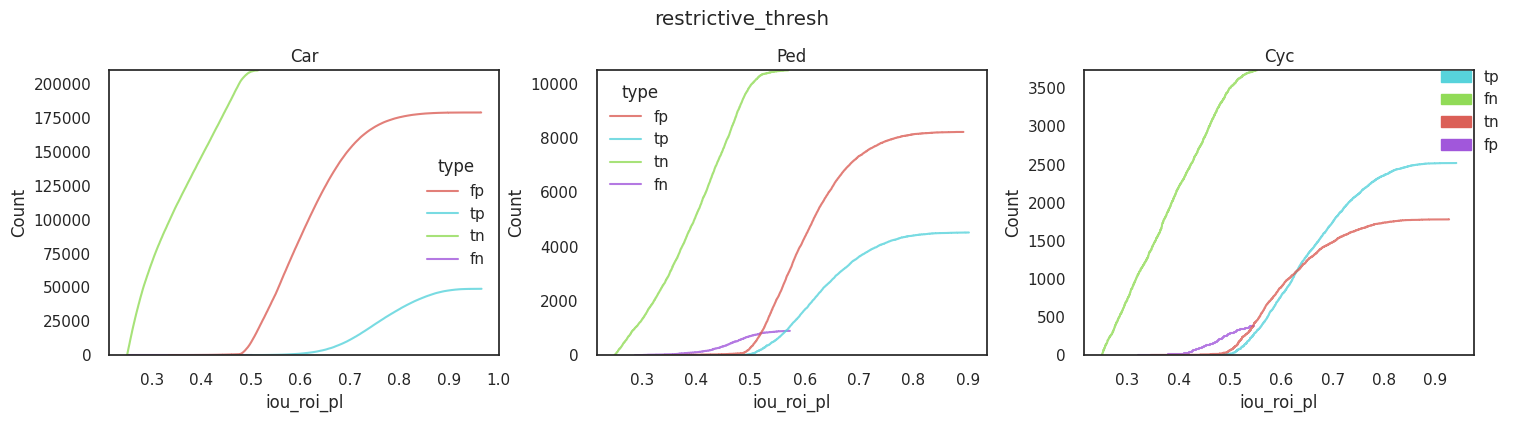

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0          0.685184    0.701416        0.0             1     0.997127  \
1          0.000000    0.701694        0.0             2     0.765312   
2          0.612229    0.655362        0.0             1     0.791199   
3          0.000000    0.606616        0.0             2     0.833461   
4          0.792858    0.836800        0.0             1     0.998138   
...             ...         ...        ...           ...          ...   
1409921    0.428183    0.579811     1439.0             2     0.499169   
1409922    0.426809    0.692184     1439.0             2     0.812090   
1409923    0.385259    0.502816     1439.0             2     0.721074   
1409924    0.311869    0.500046     1439.0             2     0.499289   
1409925    0.521765    0.540902     1439.0             2     0.454171   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   fp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   tp    1.0  
...           ...       ...         ...        ...  ...    ...  
1409921  0.573839  0.019526    0.549618   0.021452   fp   60.0  
1409922  0.573839  0.019526    0.549618   0.021452   fp   60.0  
1409923  0.573839  0.019526    0.549618   0.021452   tn   60.0  
1409924  0.573839  0.019526    0.549618   0.021452   tn   60.0  
1409925  0.573839  0.019526    0.549618   0.021452   fn   60.0  

[471083 rows x 11 columns]

In [30]:
tp_fp_fn_ecdf(res_thresh,'restrictive_thresh')
# tp_fp_fn_ecdf(relaxed_thresh,'relaxed')

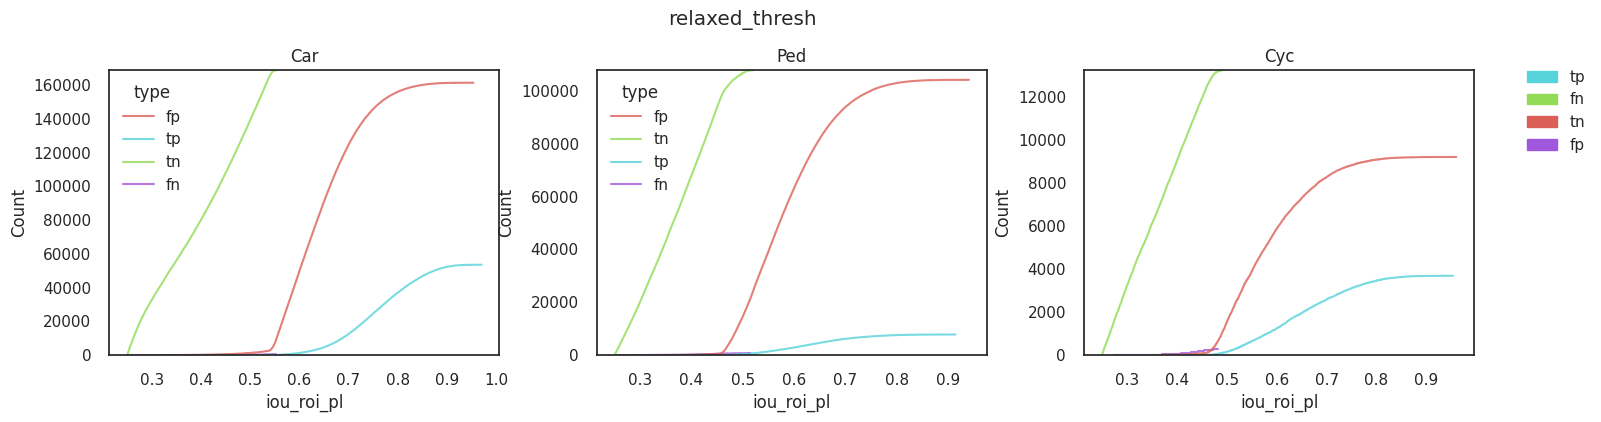

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0          0.000000    0.737889        0.0             1     0.276245  \
1          0.759624    0.885500        0.0             1     0.999320   
2          0.000000    0.587686        0.0             1     0.085128   
3          0.593041    0.814030        0.0             1     0.999633   
4          0.754584    0.738706        0.0             1     0.998924   
...             ...         ...        ...           ...          ...   
1410868    0.000000    0.518355     1439.0             2     0.328488   
1410870    0.000000    0.494149     1439.0             1     0.104503   
1410871    0.000000    0.271440     1439.0             1     0.014293   
1410872    0.000000    0.337491     1439.0             2     0.000168   
1410873    0.000000    0.494149     1439.0             1     0.215524   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   tp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   tp    1.0  
...           ...       ...         ...        ...  ...    ...  
1410868  0.520585  0.020454    0.524567   0.019324   tn   60.0  
1410870  0.548829  0.029893    0.555316   0.029141   tn   60.0  
1410871  0.548829  0.029893    0.555316   0.029141   tn   60.0  
1410872  0.520585  0.020454    0.524567   0.019324   tn   60.0  
1410873  0.548829  0.029893    0.555316   0.029141   tn   60.0  

[631108 rows x 11 columns]

In [31]:
tp_fp_fn_ecdf(relaxed_thresh,'relaxed_thresh')


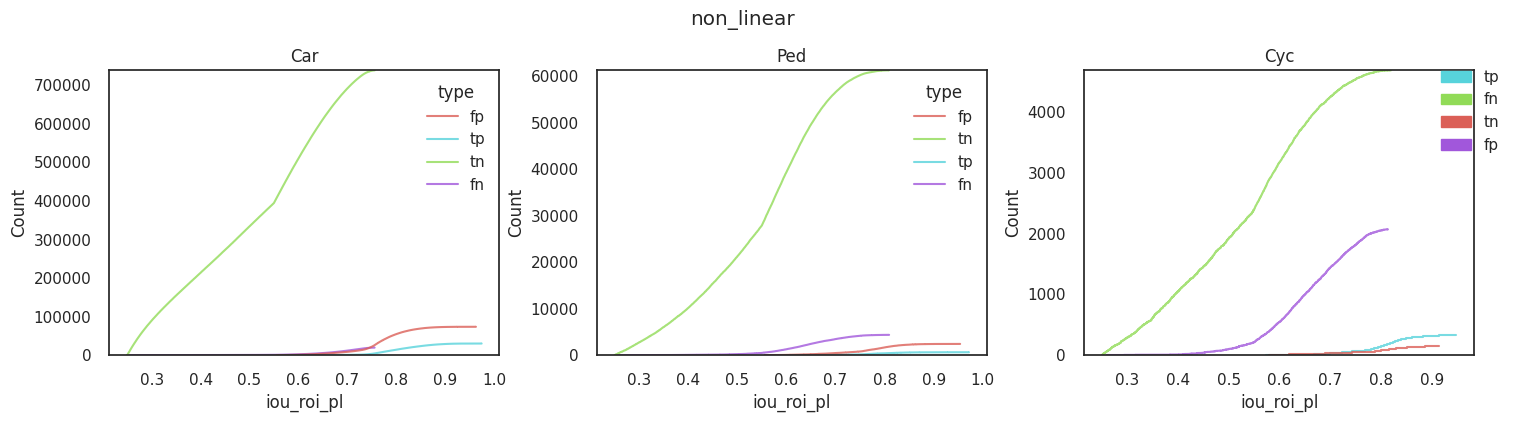

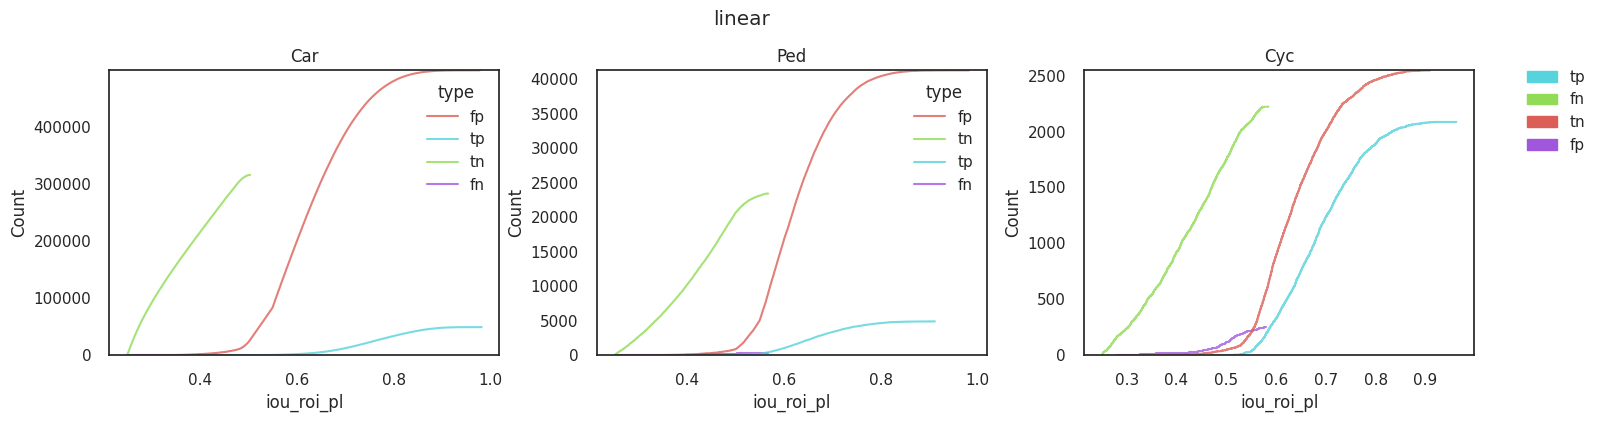

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0          0.590828    0.823261        0.0             1     0.985154  \
1          0.000000    0.573023        0.0             1     0.876250   
2          0.609215    0.587807        0.0             1     0.610560   
3          0.000000    0.834765        0.0             1     0.074297   
4          0.000000    0.665250        0.0             1     0.825216   
...             ...         ...        ...           ...          ...   
1412327    0.000000    0.317107     1439.0             1     0.013604   
1412330    0.000000    0.294051     1439.0             1     0.000053   
1412332    0.000000    0.293455     1439.0             2     0.000082   
1412334    0.000000    0.497533     1439.0             1     0.072880   
1412335    0.000000    0.441029     1439.0             1     0.003772   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   fp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   fp    1.0  
...           ...       ...         ...        ...  ...    ...  
1412327  0.502952  0.028147    0.502744   0.027478   tn   60.0  
1412330  0.502952  0.028147    0.502744   0.027478   tn   60.0  
1412332  0.568608  0.017242    0.562946   0.017833   tn   60.0  
1412334  0.502952  0.028147    0.502744   0.027478   tn   60.0  
1412335  0.502952  0.028147    0.502744   0.027478   tn   60.0  

[942725 rows x 11 columns]

In [96]:
tp_fp_fn_ecdf(no_thresh_non_linear,'non_linear')
tp_fp_fn_ecdf(no_thresh_linear,'linear')

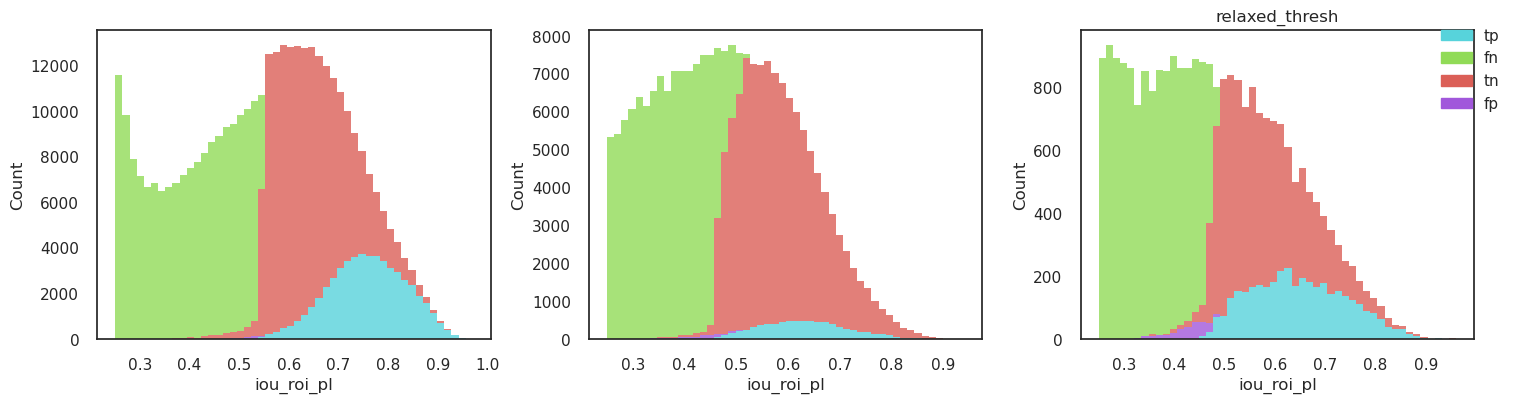

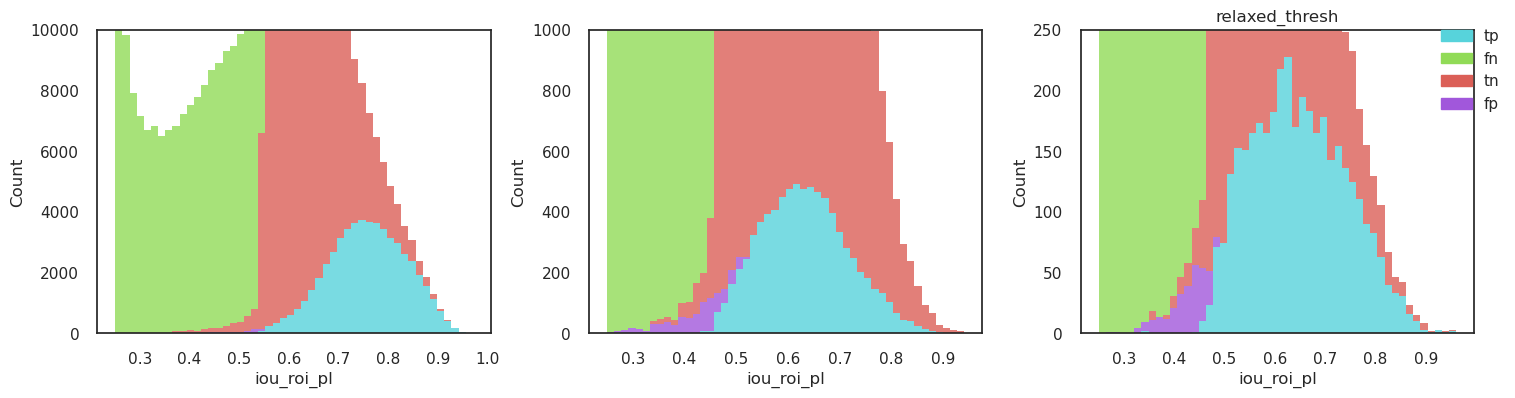

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  \
0          0.000000    0.737889        0.0             1     0.276245   
1          0.759624    0.885500        0.0             1     0.999320   
2          0.000000    0.587686        0.0             1     0.085128   
3          0.593041    0.814030        0.0             1     0.999633   
4          0.754584    0.738706        0.0             1     0.998924   
...             ...         ...        ...           ...          ...   
1410868    0.000000    0.518355     1439.0             2     0.328488   
1410870    0.000000    0.494149     1439.0             1     0.104503   
1410871    0.000000    0.271440     1439.0             1     0.014293   
1410872    0.000000    0.337491     1439.0             2     0.000168   
1410873    0.000000    0.494149     1439.0             1     0.215524   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   tp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   tp    1.0  
...           ...       ...         ...        ...  ...    ...  
1410868  0.520585  0.020454    0.524567   0.019324   tn   60.0  
1410870  0.548829  0.029893    0.555316   0.029141   tn   60.0  
1410871  0.548829  0.029893    0.555316   0.029141   tn   60.0  
1410872  0.520585  0.020454    0.524567   0.019324   tn   60.0  
1410873  0.548829  0.029893    0.555316   0.029141   tn   60.0  

[631108 rows x 11 columns]

In [46]:
tp_fp_fn_kde(relaxed_thresh,'relaxed_thresh')
tp_fp_fn_kde(relaxed_thresh,'relaxed_thresh',True)

type
tn    210303
fp    179169
tp     48975
fn        79
Name: count, dtype: int64
type
tn    10495
fp     8225
tp     4519
fn      895
Name: count, dtype: int64
type
tn    3735
tp    2520
fp    1781
fn     387
Name: count, dtype: int64


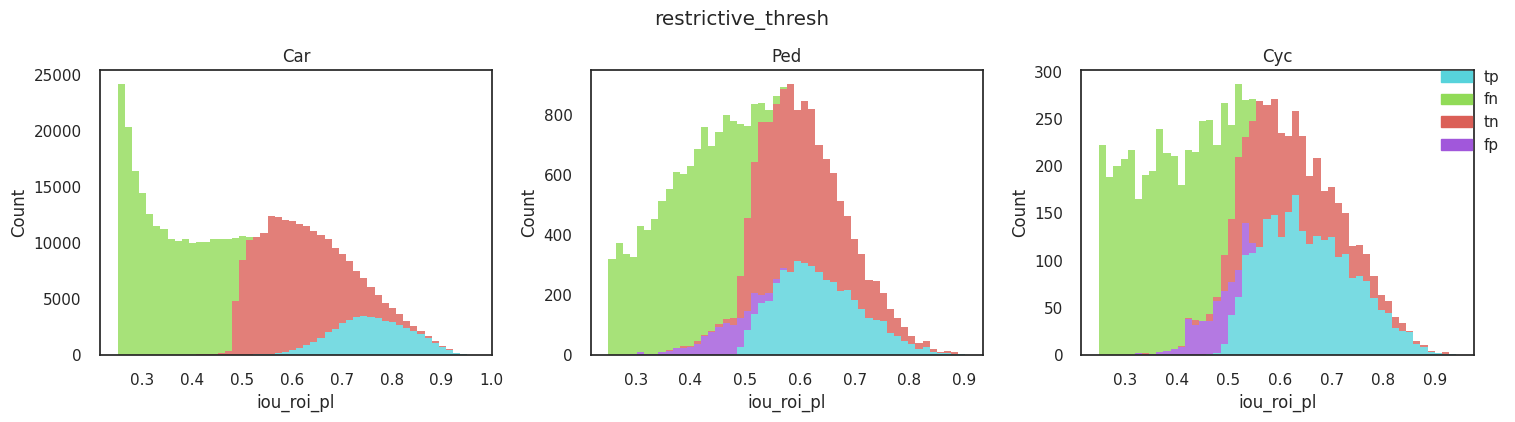

type
tn    210303
fp    179169
tp     48975
fn        79
Name: count, dtype: int64
type
tn    10495
fp     8225
tp     4519
fn      895
Name: count, dtype: int64
type
tn    3735
tp    2520
fp    1781
fn     387
Name: count, dtype: int64


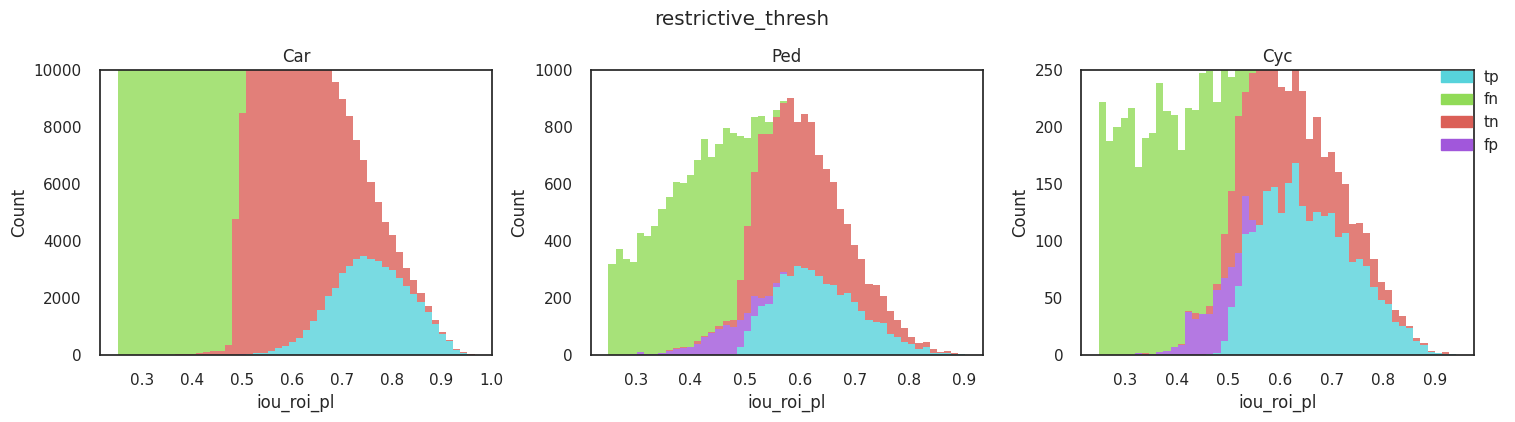

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0          0.685184    0.701416        0.0             1     0.997127  \
1          0.000000    0.701694        0.0             2     0.765312   
2          0.612229    0.655362        0.0             1     0.791199   
3          0.000000    0.606616        0.0             2     0.833461   
4          0.792858    0.836800        0.0             1     0.998138   
...             ...         ...        ...           ...          ...   
1409921    0.428183    0.579811     1439.0             2     0.499169   
1409922    0.426809    0.692184     1439.0             2     0.812090   
1409923    0.385259    0.502816     1439.0             2     0.721074   
1409924    0.311869    0.500046     1439.0             2     0.499289   
1409925    0.521765    0.540902     1439.0             2     0.454171   

         ema_mean   ema_var  batch_mean  batch_var type  epoch  
0        0.333333  0.000000    0.000000   1.000000   fp    1.0  
1        0.333333  0.000000    0.000000   1.000000   fp    1.0  
2        0.333333  0.000000    0.000000   1.000000   fp    1.0  
3        0.333333  0.000000    0.000000   1.000000   fp    1.0  
4        0.333333  0.000000    0.000000   1.000000   tp    1.0  
...           ...       ...         ...        ...  ...    ...  
1409921  0.573839  0.019526    0.549618   0.021452   fp   60.0  
1409922  0.573839  0.019526    0.549618   0.021452   fp   60.0  
1409923  0.573839  0.019526    0.549618   0.021452   tn   60.0  
1409924  0.573839  0.019526    0.549618   0.021452   tn   60.0  
1409925  0.573839  0.019526    0.549618   0.021452   fn   60.0  

[471083 rows x 11 columns]

In [17]:
tp_fp_fn_kde(res_thresh,'restrictive_thresh')
tp_fp_fn_kde(res_thresh,'restrictive_thresh',True)

0.0
0.0
0.0


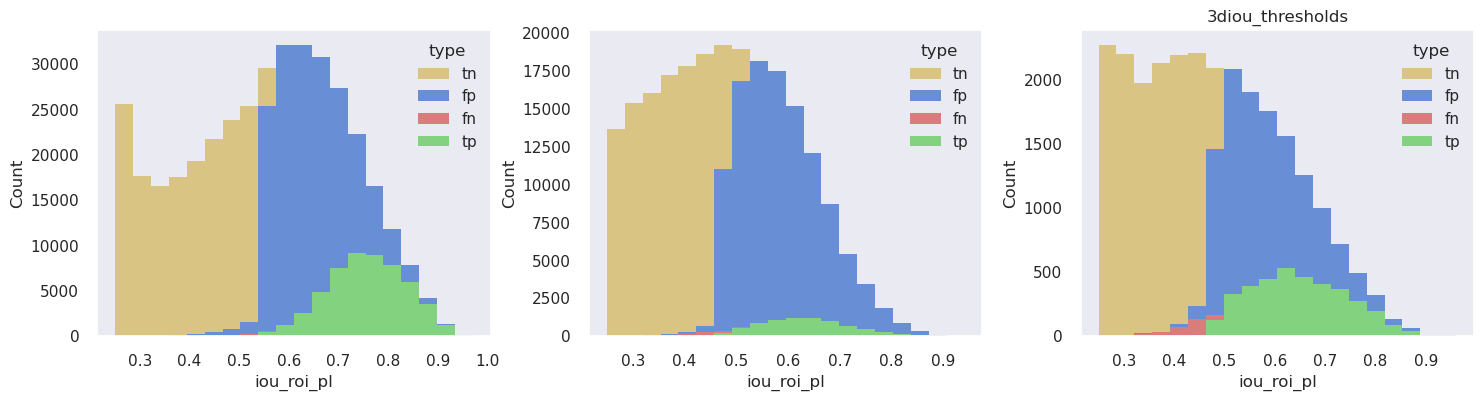

In [39]:
temp_dict_old = {
    'iou_roi_gt': smt_old['iou_roi_gt'],
    'iou_roi_pl': smt_old['iou_roi_pl'],
    'iteration' : smt_old['iteration'],
    'class_labels': smt_old['class_labels'],
    'pred_scores': smt_old['pred_scores'],
    'ema_mean': smt_old['ema_mean'],
    'ema_var': smt_old['ema_var'],
    'batch_mean': smt_old['batch_mean'],
    'batch_var': smt_old['batch_var'],

}
old_df = pd.DataFrame(temp_dict_old)
old_df['type'] = 'none'
old_df['epoch'] = (old_df['iteration']) // 24 + 1
old_df = old_df[0.25 <= old_df['iou_roi_pl']]
relaxed_thresh = tp_fp_fn_hist(old_df,'3diou_thresholds')

0.0
0.0
0.0


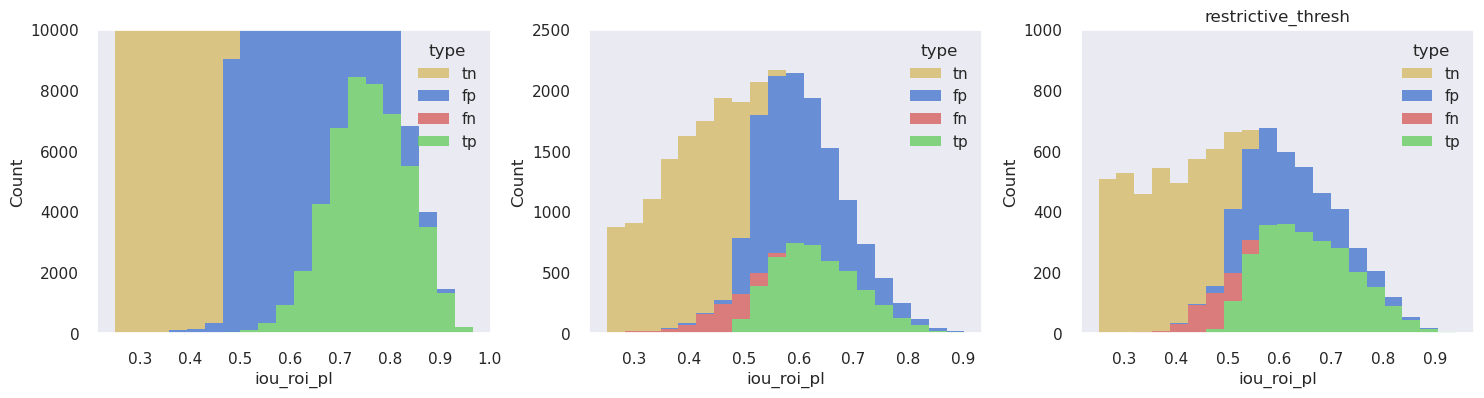

In [40]:

df_ = tp_fp_fn_hist(new_df,'restrictive_thresh',ylim=True)

0.0
0.0
0.0


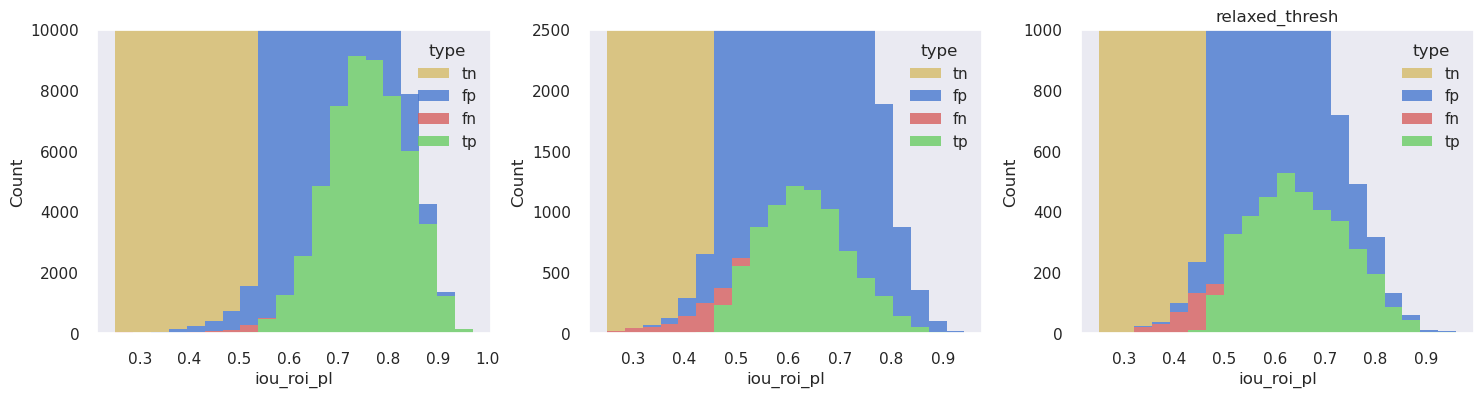

In [41]:
df_ = tp_fp_fn_hist(old_df,'relaxed_thresh',ylim=True)

## Plot epoch wise tp,fp,fn,tn

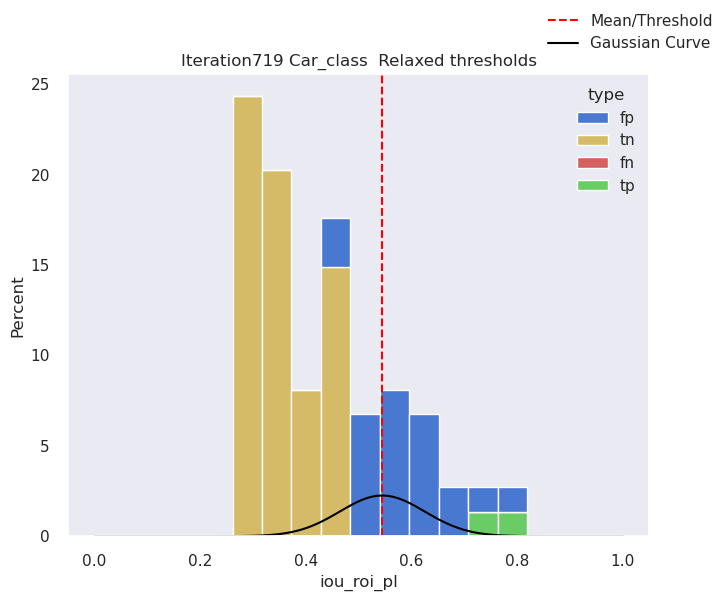

In [44]:
from scipy.stats import norm
from scipy import stats
def gaussian_plot(df,height):
    x = np.linspace(0,1.0,100)
    mu=df['ema_mean'].iloc[0]
    sigma =4* np.var(df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = height
    return coefficient * np.exp(exponent)

def plot(func_df,start,end,cls,path1):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'fp':p[0],'tn':p[-2],'fn':p[3],'tp':p[2]}
    grouped_df = func_df.groupby('iteration')
    files = []
    for i in range(start,end):
        # axes
        f, axes = plt.subplots(1,figsize=(7.5,6))
        # Joining the paths
        path2 = cls+str(int(i))+'_iter'
        joined_path = os.path.join(path1, path2) + '.png'
        files.append(joined_path)
        # df and plots
        try:
            df = grouped_df.get_group(i)
        except:
            continue
        df['class_labels'] == cls_map[cls]
        g =sns.histplot(data=df,x='iou_roi_pl',hue='type',multiple='stack',stat='percent',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        heights =[]
        for val in g.patches:
            heights.append(val.get_height())
        height = (max(heights)) # varying heights
        height = 2.25 # fixed heights
        plt.axvline(x=df['ema_mean'].iloc[0],color = 'red',linestyle = '--')
        plt.plot(np.linspace(0,1.0,100), gaussian_plot(df,height), color = "black") #plotting normal curve 
        plt.title(f'Iteration{int(i)} {cls}_class  Relaxed thresholds')
        f.legend(handles=[plt.Line2D([], [], color='red', linestyle='--'), plt.Line2D([], [], color='black')],
            labels=["Mean/Threshold", "Gaussian Curve"])
        sleep(0.5)
        plt.show()
        break
        # plt.savefig(joined_path) # Change the file extension to save in a different format
        # plt.close()
        
     
    # images = [Image.open(filename) for filename in files]

    # # Save the images as an animated GIF
    # output_filename = f'{path1}/{cls}_{start}_{end}_iter.gif'
    # images[0].save(output_filename, save_all=True, append_images=images[1:], duration=600, loop=0)   
    # plt.show()
# for cls in ['Car','Ped','Cyc']:    
cls = 'Car'
path = f'/mnt/data/deka01/plots/relaxed_thresh/{cls}'
plot(old_df,719,725,cls,path)

In [108]:
from scipy.stats import norm
from scipy import stats
def gaussian_plot(df,height):
    x = np.linspace(0,1.0,100)
    mu=df['ema_mean'].iloc[0]
    sigma =4* np.var(df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = height
    return coefficient * np.exp(exponent)

def plot(func_df,start,end,cls,path1):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'fp':p[0],'tn':p[-2],'fn':p[3],'tp':p[2]}
    grouped_df = func_df.groupby('iteration')
    files = []
    for i in range(start,end):
        # axes
        f, axes = plt.subplots(1,figsize=(7.5,6))
        # Joining the paths
        path2 = cls+str(int(i))+'_iter'
        joined_path = os.path.join(path1, path2) + '.png'
        files.append(joined_path)
        # df and plots
        try:
            df = grouped_df.get_group(i)
        except:
            continue
        df['class_labels'] == cls_map[cls]
        g =sns.histplot(data=df,x='iou_roi_pl',hue='type',multiple='stack',stat='percent',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        heights =[]
        for val in g.patches:
            heights.append(val.get_height())
        height = (max(heights)) # varying heights
        height = 2.25 # fixed heights
        plt.axvline(x=df['ema_mean'].iloc[0],color = 'red',linestyle = '--')
        plt.plot(np.linspace(0,1.0,100), gaussian_plot(df,height), color = "black") #plotting normal curve 
        plt.title(f'Iteration{int(i)} {cls}_class  Relaxed thresholds')
        f.legend(handles=[plt.Line2D([], [], color='red', linestyle='--'), plt.Line2D([], [], color='black')],
            labels=["Mean/Threshold", "Gaussian Curve"])
        sleep(0.5)

        plt.savefig(joined_path) # Change the file extension to save in a different format
        plt.close()
        
     
    images = [Image.open(filename) for filename in files]

    # Save the images as an animated GIF
    output_filename = f'{path1}/{cls}_{start}_{end}_iter.gif'
    images[0].save(output_filename, save_all=True, append_images=images[1:], duration=600, loop=0)   
    # plt.show()
# for cls in ['Car','Ped','Cyc']:    
cls = 'Car'
path = f'/mnt/data/deka01/plots/relaxed_thresh/{cls}'
plot(old_df,719,725,cls,path)

In [18]:
BATCH_SIZE = 8
WINDOW_SIZE = BATCH_SIZE * 4
MAX_PLT_COLS = 5
MAX_PLT_ROWS = 9
CLS_IDX = 2  # Analyzing {1: Car, 2: Ped, 3: Cycl}
fg_gt_thresh = [0.7, 0.5, 0.5]
fg_pl_thresh = [0.65, 0.45, 0.4]
pre_filtering_thresh = fg_pl_thresh[CLS_IDX-1]
cls_names = ['Car', 'Pedestrian', 'Cyclist']

In [19]:
"""
Accumulate the stats with the rolling window (with the window_size based on the iteration) and show the histograms
of `roi_iou_pl` or `pred_scores` throughout the training
"""

def plot_corres_gt(stats_df: pd.DataFrame, cls_ind=CLS_IDX, window_size=WINDOW_SIZE):
    stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
    stats_df['iteration'] = stats_df['iteration'].astype('int32')
    f, axes = plt.subplots(MAX_PLT_ROWS, MAX_PLT_COLS, sharex='col', sharey='row', figsize=(12,20), layout="compressed")
    
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    hist_args = dict(hue='type', fill=True, stat='count', legend=True, bins=np.arange(pre_filtering_thresh, 1.02, 0.02), alpha=0.8, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
    num_windows = stats_df.iteration.max() // window_size
    
    for w, ax in tqdm(zip(range(num_windows), axes.flat), total=num_windows):
        df_subgroups = []
        for it in range(window_size):
           try:        
              subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
              df_subgroups.append(subgroup)
           except KeyError:
               break
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        sns.histplot(ax=ax, data=cls_df, x="iou_roi_pl", **hist_args)
        ax.set_title(f"Window {w}")
        
        if (w + 1) % MAX_PLT_COLS == 1:  # First col
            ax.xaxis.set_tick_params(bottom=False)
        
        elif (w + 1) // MAX_PLT_COLS == MAX_PLT_ROWS - 1:  # Last row
            ax.yaxis.set_tick_params(left=False)
        else:
            ax.xaxis.set_tick_params(bottom=False)
            ax.yaxis.set_tick_params(left=False)
        
    
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    f.suptitle(f"Histograms of {cls_names[cls_ind-1]} class.")
#     f.tight_layout()
    # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()

### GIF Generation


In [22]:
from scipy.stats import norm
from scipy import stats
def gaussian_plot(df,height):
    x = np.linspace(0,1.0,100)
    mu=df['ema_mean'].iloc[0]
    sigma =4* np.var(df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = height
    return coefficient * np.exp(exponent)

def plot(func_df,start,end,cls,path1,cls_ind=CLS_IDX, window_size=WINDOW_SIZE,ylim=500):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'fp':p[0],'tn':p[-2],'fn':p[3],'tp':p[2]}
    grouped_df = func_df.groupby('iteration')
    files = []
    stats_df = func_df
    stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
    stats_df['iteration'] = stats_df['iteration'].astype('int32')
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    # hist_args = dict(hue='type', fill=True, stat='count', legend=True, bins=np.arange(pre_filtering_thresh, 1.02, 0.02), alpha=0.8, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
    num_windows = stats_df.iteration.max() // window_size
    for w in tqdm(range(num_windows), total=num_windows):
        df_subgroups = []
        for it in range(window_size):
           try:        
              subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
              df_subgroups.append(subgroup)
           except KeyError:
               break
        path2 = f'{cls}_{int(w)}_window'
        joined_path = os.path.join(path1, path2) + '.png'
        files.append(joined_path)
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        sns.histplot(data=cls_df,x='iou_roi_pl',hue='type',multiple='stack',stat='count',hue_order=['tn', 'fp', 'fn', 'tp'],bins=30,fill=True,legend=True,palette=palettes,alpha=1.0,edgecolor="None")
        
        sleep(0.5)
        plt.ylim(0,ylim)
        plt.xlim(0.25,1.0)
        plt.title(f'Window_{int(w)} {cls}_class Non Linear function')
        plt.savefig(joined_path) # Change the file extension to save in a different format
        plt.close()
        # if w==5:
        #     break
       
     
    images = [Image.open(filename) for filename in files]
    # Save the images as an animated GIF
    output_filename = f'{path1}/{cls}_window.gif'
    images[0].save(output_filename, save_all=True, append_images=images[1:], duration=600, loop=0)  

for cls in [['Car',1,1600],['Ped',2,180],['Cyc',3,50]]:    
# for cls in [['Ped',2,200]]:    
    # cls = 'Cyc'
    # ylim=cls[2]
    path = f'/mnt/data/deka01/plots/non_linear/{cls[0]}'
    plot(no_thresh_non_linear,719,725,cls[0],path,cls[1],WINDOW_SIZE,cls[2])

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:01<?, ?it/s]

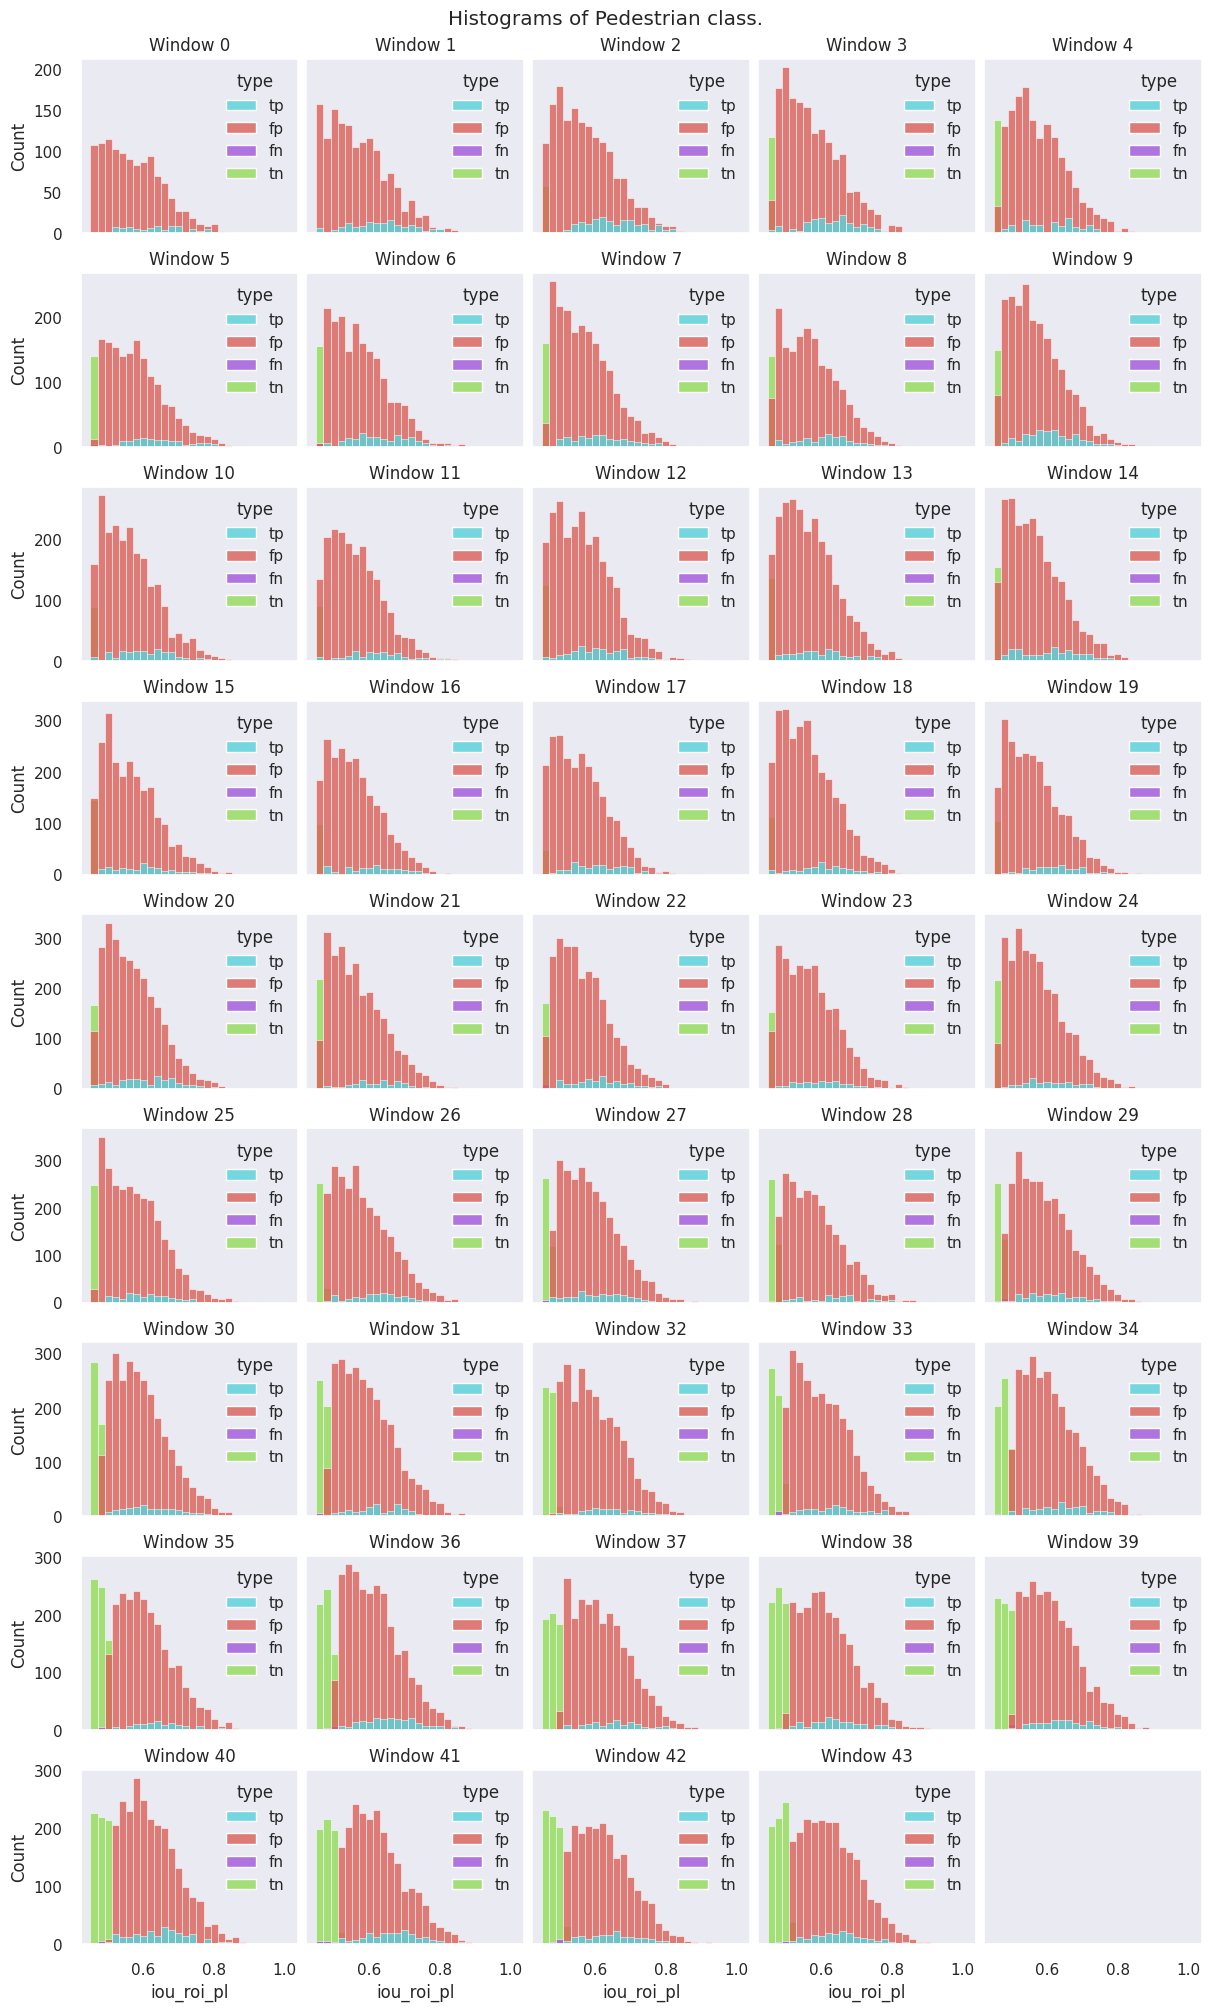

In [67]:
plot_corres_gt(relaxed_thresh)


  0%|          | 0/44 [00:00<?, ?it/s]

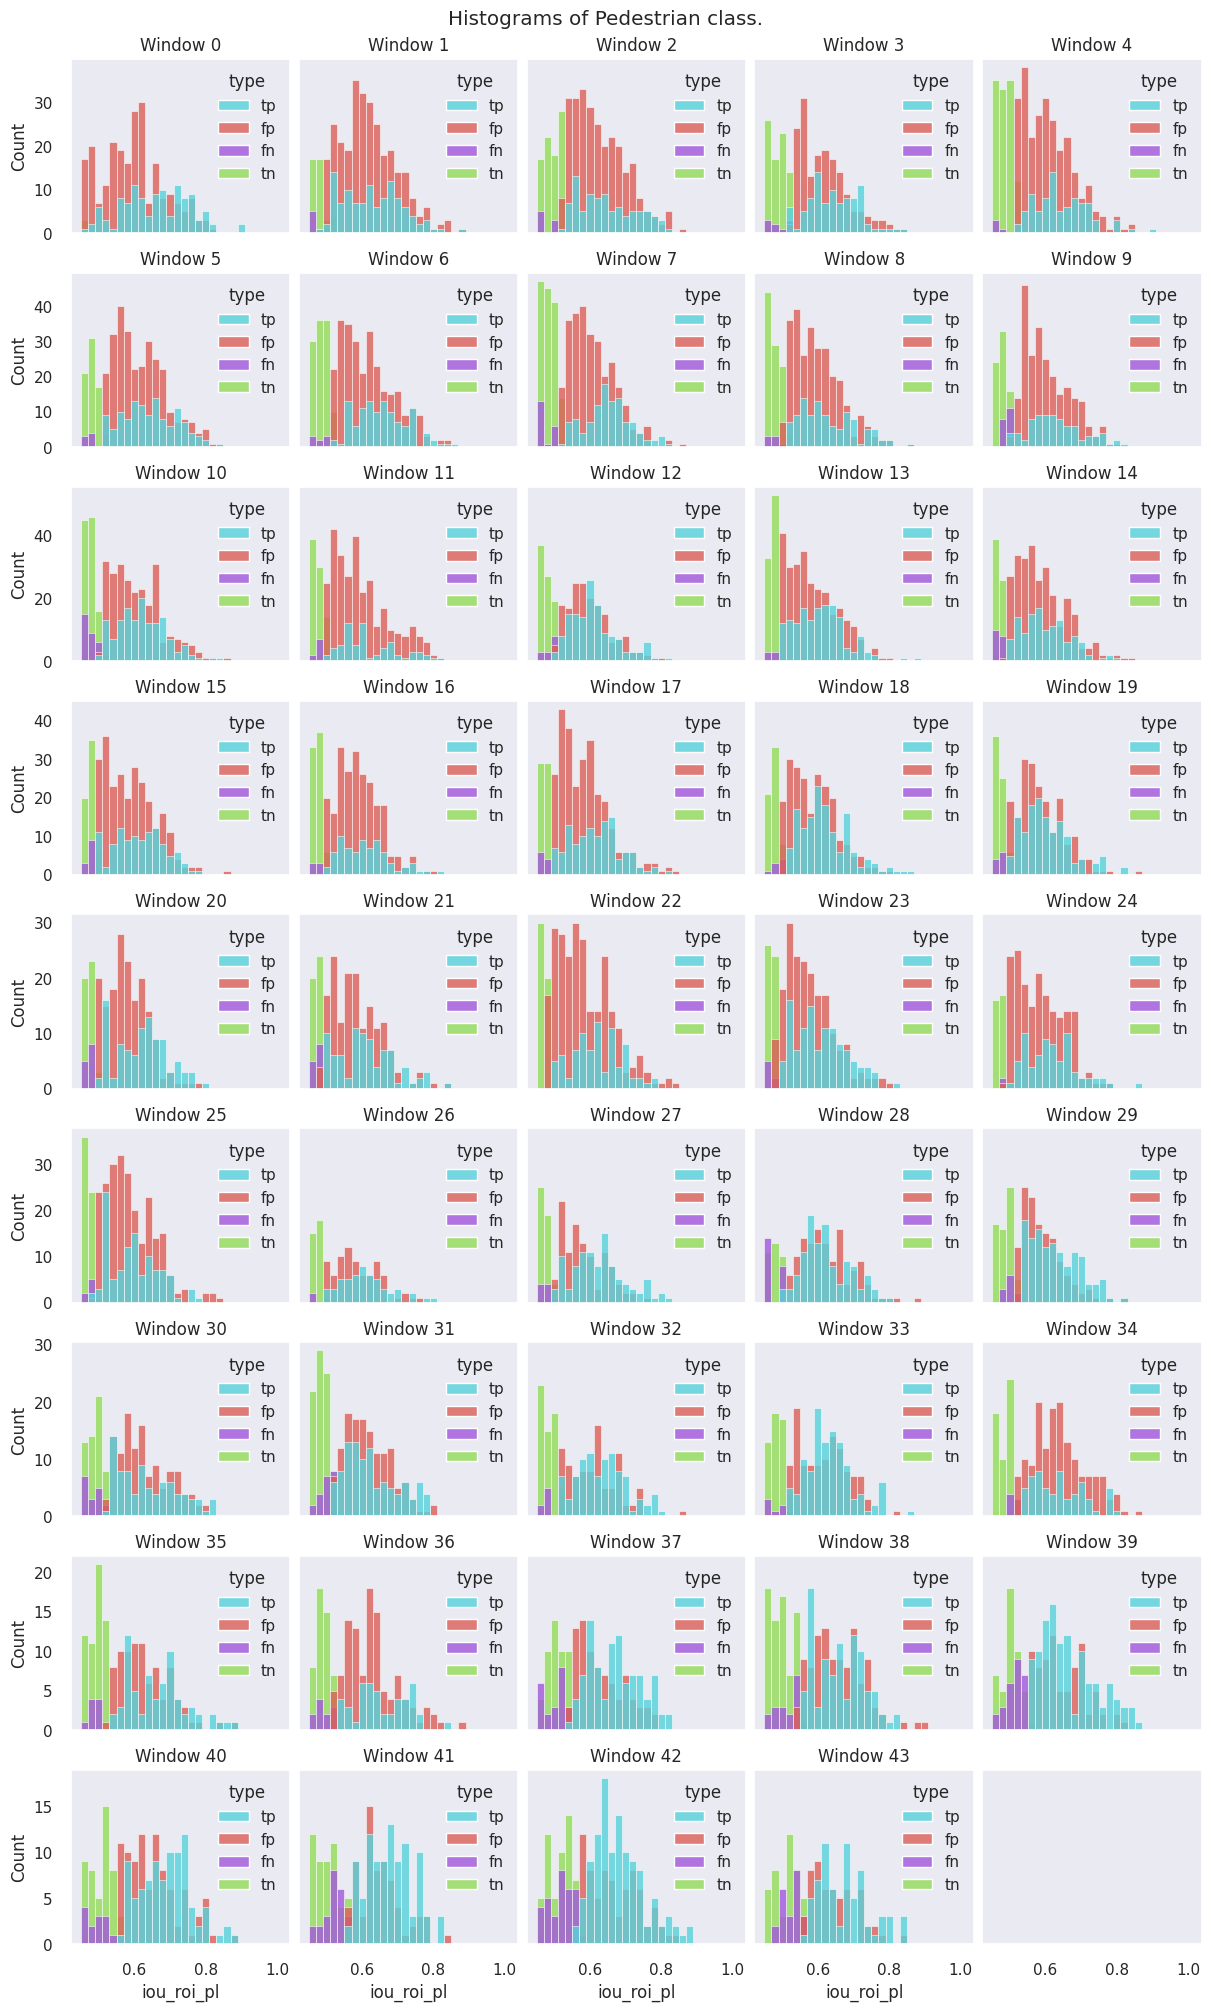

In [51]:
plot_corres_gt(res_thresh)

In [ ]:
plot_corres_gt(no_thresh_non_linear)


In [ ]:
plot_corres_gt(no_thresh_linear)

In [35]:
"""
Accumulate the stats with the rolling window (with the window_size based on the iteration) and show the histograms
of `roi_iou_pl` or `pred_scores` throughout the training
"""

def plot_corres_gt_kde(stats_df: pd.DataFrame, cls_ind=CLS_IDX, window_size=WINDOW_SIZE):
    stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
    stats_df['iteration'] = stats_df['iteration'].astype('int32')
    f, axes = plt.subplots(MAX_PLT_ROWS, MAX_PLT_COLS, sharex='col', sharey='row', figsize=(12,20), layout="compressed")
    
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    hist_args = dict(hue='type', fill=True, stat='count', legend=True, bins=np.arange(pre_filtering_thresh, 1.02, 0.02), alpha=0.8, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
    num_windows = stats_df.iteration.max() // window_size
    
    for w, ax in tqdm(zip(range(num_windows), axes.flat), total=num_windows):
        df_subgroups = []
        for it in range(window_size):
           try:        
              subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
              df_subgroups.append(subgroup)
           except KeyError:
               break
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        g = sns.histplot(ax=ax,data=cls_df, x="iou_roi_pl", hue='type', fill=True, kde=False,  
                 stat='count', multiple="stack", legend=False, bins=50, alpha=0.8,
                 palette=palettes, hue_order=['tn', 'fp', 'fn', 'tp'], edgecolor="None")
        ax.set_title(f"Window {w}")
        
        if (w + 1) % MAX_PLT_COLS == 1:  # First col
            ax.xaxis.set_tick_params(bottom=False)
        
        elif (w + 1) // MAX_PLT_COLS == MAX_PLT_ROWS - 1:  # Last row
            ax.yaxis.set_tick_params(left=False)
        else:
            ax.xaxis.set_tick_params(bottom=False)
            ax.yaxis.set_tick_params(left=False)
        
    
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    f.suptitle(f"Histograms of {cls_names[cls_ind-1]} class.")
#     f.tight_layout()
    # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()

  0%|          | 0/44 [00:00<?, ?it/s]

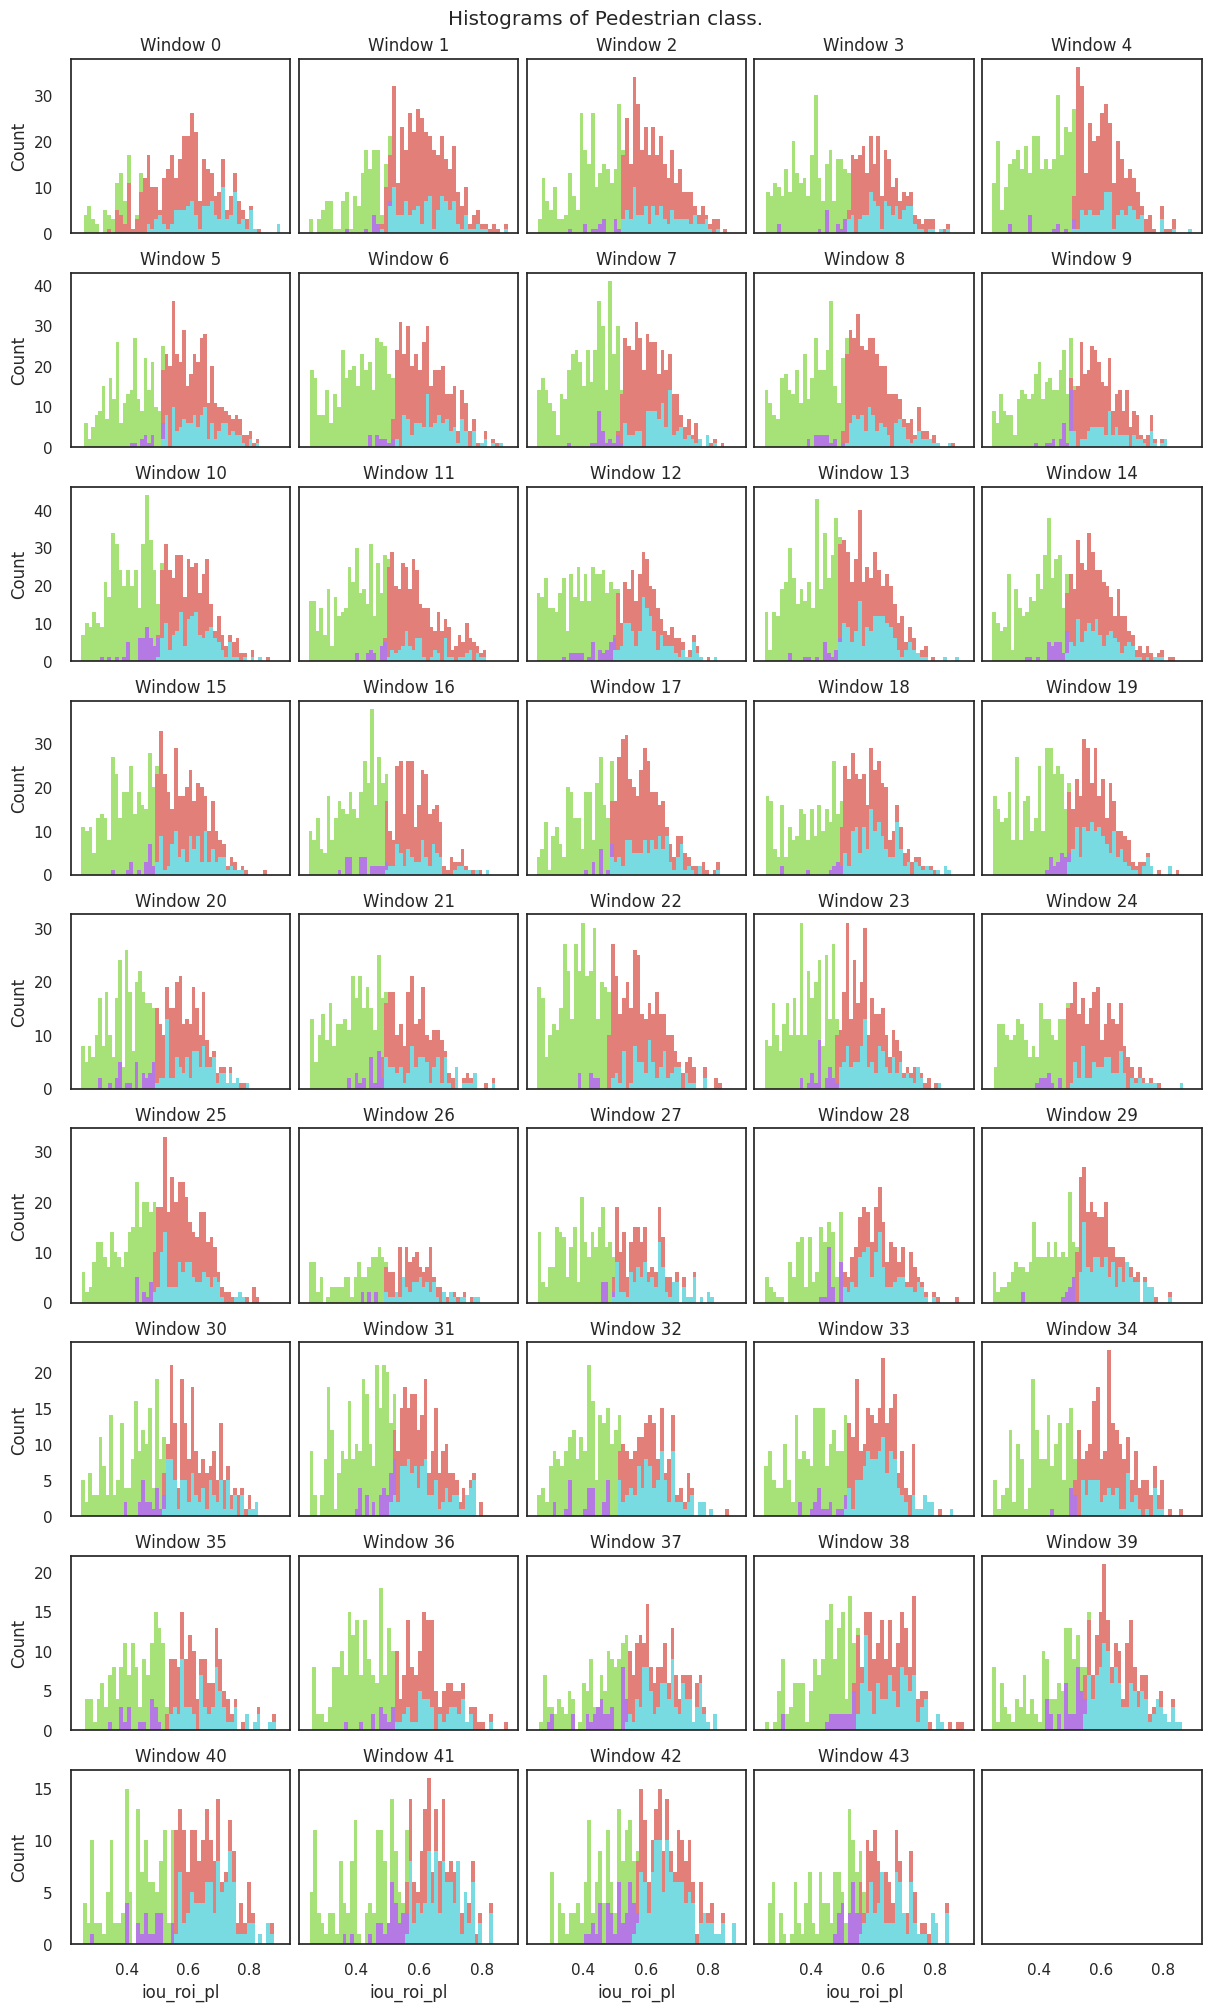

In [36]:
plot_corres_gt_kde(res_thresh)

In [ ]:
def tp_fp_fn_kde(df,title,ylim=False):
    cls_map = {0:'Car',1:'Ped',2:'Cyc'}
    
    fg_gt_thresh = [0.7, 0.5, 0.5]
    p = sns.color_palette("hls", 4)
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    f, axes = plt.subplots(1,3, 
                        figsize=(15,6))
    if ylim:
        axes[0].set_ylim(0,5000)
        axes[1].set_ylim(0,600)
        axes[2].set_ylim(0,250)
    

    # Find the patches corresponding to 'tp'
    tp_patch = mpatches.Patch(color=p[2], label='tp')
    fn_patch = mpatches.Patch(color=p[3], label='fn')
    tn_patch = mpatches.Patch(color=p[0], label='fp')
    fp_patch = mpatches.Patch(color=p[1], label='tn')


    for i in range(0,3):
        cls_df = df[df['class_labels'] == i + 1]
        cls_mask = df['class_labels'] == i + 1
        tp_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['ema_mean'] <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['iou_roi_pl'] < cls_df['ema_mean'])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        df.loc[cls_mask,'type'] = cls_df['type']
        g = sns.histplot(ax=axes[i],data=cls_df, x="iou_roi_pl", hue='type', fill=True, kde=False,  
                 stat='count', multiple="stack", legend=False, bins=50, alpha=0.8,
                 palette=palettes, hue_order=['tn', 'fp', 'fn', 'tp'], edgecolor="None")
        axes[i].set_title(cls_map[i])
        # print(cls_df['type'].value_counts())
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        print(cls_df['type'].value_counts())
        val = (cls_df['type'].value_counts().reset_index())
        counts = (list(val['count'].tolist()))
        cols = list(val['type'].tolist())
        # table_data = [[str(c)] for c in counts] + [[str(col)] for col in cols]
        table_data = [["Type"] + [str(col) for col in cols], ["Count"] + [str(c) for c in counts]]
        table =axes[i].table(cellText=table_data, loc='bottom', bbox=[0, -0.35, 1, 0.2])
        # Format the table cells
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.25)
    axes[2].legend(handles=[tp_patch,fp_patch,tn_patch,fn_patch],labels=['tp','fn','tn','fp'],bbox_to_anchor=(1.1, 1.05))
        # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    # plt.legend()
   

    plt.suptitle(title,y=1.05)
    plt.show()
    return df

##
 Rough Work, do not refer

In [45]:
def plot_line(df):
    grouped_old_df = df.groupby('iteration')
    for cls_idx in range(0,3):
        temp_dict = {'tn':[], 'fp':[], 'tp':[], 'fn':[]}
        for i,groups in grouped_old_df:
            cls_group = groups[groups['class_labels']== cls_idx + 1] 
            val = cls_group['type'].value_counts().reset_index().rename(columns={'type': 'type'})
            for k in temp_dict.keys():
                try:
                    temp_dict[k].append(float(val[val['type']==k]['count']))
                except:
                    temp_dict[k].append(0)
        cls_df = pd.DataFrame(temp_dict)
        sns.lineplot(cls_df.ewm.mean(alpha = 0.7))
        # print(cls_df)
        plt.show()
        break
plot_line(old_df)


AttributeError: 'function' object has no attribute 'mean'

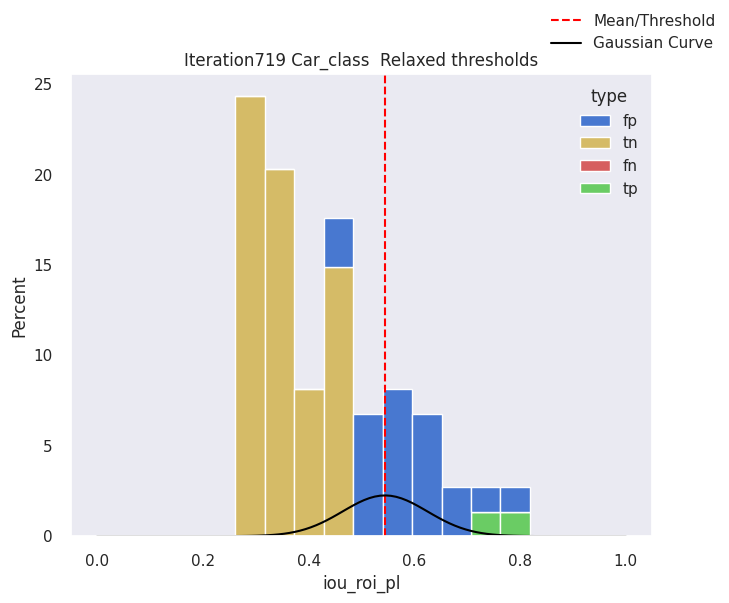

In [42]:
from scipy.stats import norm
from scipy import stats
def gaussian_plot(df,height):
    x = np.linspace(0,1.0,100)
    mu=df['ema_mean'].iloc[0]
    sigma =4* np.var(df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = height
    return coefficient * np.exp(exponent)

def plot(func_df,start,end,cls,path1):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'fp':p[0],'tn':p[-2],'fn':p[3],'tp':p[2]}
    grouped_df = func_df.groupby('iteration')
    files = []
    for i in range(start,end):
        # axes
        f, axes = plt.subplots(1,figsize=(7.5,6))
        # Joining the paths
        path2 = cls+str(int(i))+'_iter'
        joined_path = os.path.join(path1, path2) + '.png'
        files.append(joined_path)
        # df and plots
        try:
            df = grouped_df.get_group(i)
        except:
            continue
        df['class_labels'] == cls_map[cls]
        g =sns.histplot(data=df,x='iou_roi_pl',hue='type',multiple='stack',stat='percent',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        heights =[]
        for val in g.patches:
            heights.append(val.get_height())
        height = (max(heights)) # varying heights
        height = 2.25 # fixed heights
        plt.axvline(x=df['ema_mean'].iloc[0],color = 'red',linestyle = '--')
        plt.plot(np.linspace(0,1.0,100), gaussian_plot(df,height), color = "black") #plotting normal curve 
        plt.title(f'Iteration{int(i)} {cls}_class  Relaxed thresholds')
        f.legend(handles=[plt.Line2D([], [], color='red', linestyle='--'), plt.Line2D([], [], color='black')],
            labels=["Mean/Threshold", "Gaussian Curve"])
        sleep(0.5)
        plt.show()
        break
        # plt.savefig(joined_path) # Change the file extension to save in a different format
        # plt.close()
        
     
    # images = [Image.open(filename) for filename in files]

    # # Save the images as an animated GIF
    # output_filename = f'{path1}/{cls}_{start}_{end}_iter.gif'
    # images[0].save(output_filename, save_all=True, append_images=images[1:], duration=600, loop=0)   
    # plt.show()
# for cls in ['Car','Ped','Cyc']:    
cls = 'Car'
path = f'/mnt/data/deka01/plots/relaxed_thresh/{cls}'
plot(old_df,719,725,cls,path)

In [ ]:
"""
Accumulate the stats with the rolling window (with the window_size based on the iteration) and show the histograms
of `roi_iou_pl` or `pred_scores` throughout the training
"""

def plot_corres_gt_kde(stats_df: pd.DataFrame, cls_ind=CLS_IDX, window_size=WINDOW_SIZE):
    stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
    stats_df['iteration'] = stats_df['iteration'].astype('int32')
    f, axes = plt.subplots(MAX_PLT_ROWS, MAX_PLT_COLS, sharex='col', sharey='row', figsize=(12,20), layout="compressed")
    
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    hist_args = dict(hue='type', fill=True, stat='count', legend=True, bins=np.arange(pre_filtering_thresh, 1.02, 0.02), alpha=0.8, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
    num_windows = stats_df.iteration.max() // window_size
    
    for w, ax in tqdm(zip(range(num_windows), axes.flat), total=num_windows):
        df_subgroups = []
        for it in range(window_size):
           try:        
              subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
              df_subgroups.append(subgroup)
           except KeyError:
               break
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        g = sns.histplot(ax=ax,data=cls_df, x="iou_roi_pl", hue='type', fill=True, kde=False,  
                 stat='count', multiple="stack", legend=False, bins=50, alpha=0.8,
                 palette=palettes, hue_order=['tn', 'fp', 'fn', 'tp'], edgecolor="None")
        ax.set_title(f"Window {w}")
        
        if (w + 1) % MAX_PLT_COLS == 1:  # First col
            ax.xaxis.set_tick_params(bottom=False)
        
        elif (w + 1) // MAX_PLT_COLS == MAX_PLT_ROWS - 1:  # Last row
            ax.yaxis.set_tick_params(left=False)
        else:
            ax.xaxis.set_tick_params(bottom=False)
            ax.yaxis.set_tick_params(left=False)
        
    
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    f.suptitle(f"Histograms of {cls_names[cls_ind-1]} class.")
#     f.tight_layout()
    # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()

In [43]:
temp_dict = {'tn':[], 'fp':[], 'tp':[], 'fn':[]}
temp_dict.keys

<function dict.keys>

In [44]:
temp_dict = {'tn':[], 'fp':[], 'tp':[], 'fn':[]}
val = groups['type'].value_counts().reset_index().rename(columns={'type': 'type'})
for k in temp_dict.keys():
    try:
        temp_dict[k].append(float(val[val['type']==k]['count']))
    except:
        temp_dict[k].append(0)

NameError: name 'groups' is not defined

In [124]:
val = groups['type'].value_counts().reset_index().rename(columns={'type': 'type'})
(val[val['type']==k]['count'])
k

'fn'

In [125]:
val

type  count
0   fp    145
1   tn    139
2   tp     58

In [101]:
val['type'].to_list() == temp_dict.keys()

False

In [220]:
def number_of_tp(stats_df: pd.DataFrame, cls_ind=CLS_IDX, window_size=WINDOW_SIZE):
    stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
    stats_df['iteration'] = stats_df['iteration'].astype('int32')
    
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    hist_args = dict(hue='type', fill=True, stat='count', legend=True, bins=np.arange(pre_filtering_thresh, 1.02, 0.02), alpha=0.8, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
    num_windows = stats_df.iteration.max() // window_size
    count = 0
    for w in tqdm(range(num_windows), total=num_windows):
        groups = []
        df_subgroups = []
        count_groups = []
        for it in range(window_size):
            try:        
              subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
              df_subgroups.append(subgroup[subgroup['class_labels'] == cls_ind])
              count_sub = subgroup['type'].value_counts().reset_index()
              count_groups.append(count_sub)
            except KeyError:
               break
                   
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        count_df = pd.concat(count_groups)
        groups.append(count_df)
        # sns.lineplot(ax=ax, data=cls_df, x="iteration", **hist_args)
        # ax.set_title(f"Window {w}")
        
        # if (w + 1) % MAX_PLT_COLS == 1:  # First col
        #     ax.xaxis.set_tick_params(bottom=False)
        
        # elif (w + 1) // MAX_PLT_COLS == MAX_PLT_ROWS - 1:  # Last row
        #     ax.yaxis.set_tick_params(left=False)
        # else:
        #     ax.xaxis.set_tick_params(bottom=False)
        #     ax.yaxis.set_tick_params(left=False)
        # if count == 2:
        #    break
    # print(count_df.to_dict) 
    # print(count_df) 
    final_df = pd.concat(groups)
    return final_df
#     f.subplots_adjust(wspace=0.1, hspace=0.2)
#     f.suptitle(f"Histograms of {cls_names[cls_ind-1]} class.")
# #     f.tight_layout()
#     # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
#     plt.show()

In [221]:
template_dict = {'tp':[],'fp':[],'fn':[],'tn':[]}
value_dict = df.to_dict(orient='records')
for dicts in value_dict:
    template_dict[dicts['type']].append(dicts['count'])
    

In [219]:
grouped_df = old_df.groupby('iteration')
for i in grouped_df.get_group(1)['type'].value_counts():
    print(i)

145
139
58


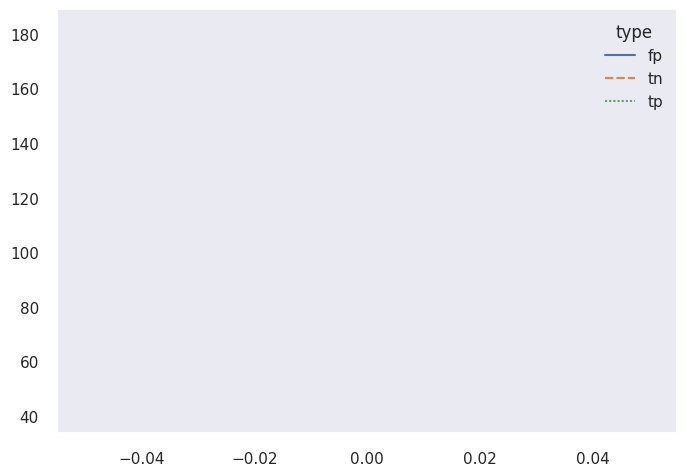

In [119]:
sns.lineplot(data=df)
plt.show()

In [103]:
pivot_df = df.pivot_table(index=(df.index // 4), columns='type', values='count')

In [104]:
pivot_df

type   fn         fp        tn       tp
0     2.6  208.59375  219.8125  53.9375

In [98]:
sns.lineplot(data=df,y='type')
plt.show()

KeyError: 'x'

In [51]:
"""
Accumulate the stats with the rolling window (with the window_size based on the iteration) and show the histograms
of `roi_iou_pl` or `pred_scores` throughout the training
"""

def plot_corres_gt_percent(stats_df: pd.DataFrame, cls_ind=CLS_IDX, window_size=WINDOW_SIZE):
    stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
    stats_df['iteration'] = stats_df['iteration'].astype('int32')
    f, axes = plt.subplots(MAX_PLT_ROWS, MAX_PLT_COLS, sharex='col', sharey='row', figsize=(12,20), layout="compressed")
    
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    hist_args = dict(hue='type', legend=True, alpha=0.8, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
    num_windows = stats_df.iteration.max() // window_size
    
    for w, ax in tqdm(zip(range(num_windows), axes.flat), total=num_windows):
        df_subgroups = []
        for it in range(window_size):
           try:        
              subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
              df_subgroups.append(subgroup)
           except KeyError:
               break
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        # sns.histplot(ax=ax, data=cls_df, x="iou_roi_pl", **hist_args)
        # sns.relplot(ax=ax,data=cls_df,x="iou_roi_pl", y="iou_roi_gt", hue="type", size="pred_scores",
        #     sizes=(40, 400), alpha=.5, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
        sns.swarmplot(ax=ax,data=cls_df, x="iteration", y="iou_roi_pl", hue="type",hue_order=['tp', 'fp', 'fn', 'tn'])
        ax.set_title(f"Window {w}")
        
        if (w + 1) % MAX_PLT_COLS == 1:  # First col
            ax.xaxis.set_tick_params(bottom=False)
        
        elif (w + 1) // MAX_PLT_COLS == MAX_PLT_ROWS - 1:  # Last row
            ax.yaxis.set_tick_params(left=False)
        else:
            ax.xaxis.set_tick_params(bottom=False)
            ax.yaxis.set_tick_params(left=False)
        
    
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    f.suptitle(f"Histograms of {cls_names[cls_ind-1]} class.")
#     f.tight_layout()
    # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()

In [53]:
old_df['type'].value_counts()

type
tn    285187
fp    284162
tp     65349
fn      1415
Name: count, dtype: int64

In [54]:
import os
def gaussian_plot(func_df):
    x = np.linspace(0,1.0,100)
    mu=func_df['ema_mean'].iloc[0]
    sigma =4* np.var(func_df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = 2.15
    return coefficient * np.exp(exponent)


def plot(func_df,start,end):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'fp':p[0],'tn':p[-2],'fn':p[3],'tp':p[2]}
    f, axes = plt.subplots(1,figsize=(7.5,6))
    grouped_func_df = func_df.groupby('iteration')

    for i in range(1,4):
        func_df = grouped_func_df.get_group(i)
        func_df['class_labels'] == cls_map['Cyc']
        path1 = '/mnt/data/deka01/plots/gaus_relthresh/cyc'
        path2 = 'Cyc'+str(int(i))+'th_iteration'
        joined_path = os.path.join(path1, path2)
        histplot = sns.histplot(data=func_df,x='iou_roi_pl',hue='type',multiple='stack',stat='density',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0,ax=axes)
        h,l = histplot.get_legend_handles_labels()
        plt.axvline(x=func_df['ema_mean'].iloc[0],color = 'black',linestyle = '--')
        plt.plot(np.linspace(0,1.0,100), gaussian_plot(func_df), color = "black") #plotting normal curve 
        plt.title(f'Iteration {int(i)+1} Cyc_class  Restrictive thresholds')
        f.legend(handles=[plt.Line2D([], [], color='black', linestyle='--'), plt.Line2D([], [], color='black')],
                labels=["Mean/Threshold", "Gaussian Curve"])
        sleep(0.5)
        # plt.show()
        plt.savefig(joined_path+'.png')  # Change the file extension to save in a different format
        plt.close()

    # for i,func_df in grouped_func_df:
    #     path1 = '/mnt/data/deka01/plots/gaus_relthresh/cyc'
    #     path2 = 'Cyc'+str(int(i))+'th_iteration'
        
    #     func_df['class_labels'] == cls_map['Cyc']
    #     # Joining the paths
    #     joined_path = os.path.join(path1, path2)
        
    #     sns.histplot(data=func_df,x='iou_roi_pl',hue='type',multiple='stack',stat='density',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0,ax=axes)
    #     # h,l = histplot.get_legend_handles_labels()
    #     plt.axvline(x=func_df['ema_mean'][0],color = 'black',linestyle = '--')
    #     plt.plot(np.linspace(0,1.0,100), gaussian_plot(func_df), color = "black") #plotting normal curve 
    #     plt.title(f'Iteration {int(i)+1} Cyc_class  Restrictive thresholds')

    # # keep same handles, edit labels with names of choice
    #     f.legend(handles=[plt.Line2D([], [], color='black', linestyle='--'), plt.Line2D([], [], color='black')],
    #             labels=["Mean/Threshold", "Gaussian Curve"])

    #     sleep(0.5)
    #     plt.show()

    #     plt.savefig(joined_path+'.png')  # Change the file extension to save in a different format
    #     plt.close()
    #     break

    
path ='gaus_relthresh/cyc'
plot(new_df,1,3)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/deka01/plots/gaus_relthresh/cyc/Cyc1th_iteration.png'

In [160]:
from scipy.stats import norm
from scipy import stats
def gaussian_plot(df,height):
    x = np.linspace(0,1.0,100)
    mu=df['ema_mean'].iloc[0]
    sigma =4* np.var(df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = height
    return coefficient * np.exp(exponent)

def plot(func_df,start,end,cls,path1):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'fp':p[0],'tn':p[-2],'fn':p[3],'tp':p[2]}
    grouped_df = func_df.groupby('iteration')
    files = []
    for i in range(start,end):
        # axes
        f, axes = plt.subplots(1,figsize=(7.5,6))
        axes.set_ylim(ymin=0,ymax=3)
        # Joining the paths
        path2 = cls+str(int(i))+'_iter'
        joined_path = os.path.join(path1, path2) + '.png'
        files.append(joined_path)
        # df and plots
        df = grouped_df.get_group(i)
        df['class_labels'] == cls_map[cls]
        g =sns.histplot(data=df,x='iou_roi_pl',hue='type',multiple='stack',stat='percent',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        heights =[]
        for val in g.patches:
            heights.append(val.get_height())
        height = (max(heights)) # varying heights
        height = 2.25 # fixed heights
        plt.axvline(x=df['ema_mean'].iloc[0],color = 'red',linestyle = '--')
        plt.plot(np.linspace(0,1.0,100), gaussian_plot(df,height), color = "black") #plotting normal curve 
        plt.title(f'Iteration{int(i)} {cls}_class  Relaxed thresholds')
        f.legend(handles=[plt.Line2D([], [], color='red', linestyle='--'), plt.Line2D([], [], color='black')],
            labels=["Mean/Threshold", "Gaussian Curve"])
        sleep(0.5)

#         plt.savefig(joined_path) # Change the file extension to save in a different format
#         plt.close()
        
     
#     images = [Image.open(filename) for filename in files]

#     # Save the images as an animated GIF
#     output_filename = f'{path1}/{cls}_{start}_{end}_iter.gif'
#     images[0].save(output_filename, save_all=True, append_images=images[1:], duration=600, loop=0)   
#     # plt.show()
# for cls in ['Car','Ped','Cyc']:    
# # cls = 'Car'
    path = f'/mnt/data/deka01/plots/relaxed_thresh/{cls}'
    plot(old_df,2,730,cls,path)
plot(old_df,1,30,cls,path)

KeyError: 719

In [150]:
grouped_df = new_df.groupby('iteration').get_group(25)
grouped_df[grouped_df['class_labels'] == 1]

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  ema_mean   
24448    0.688447    0.696648       25.0             1     0.982858  0.394883  \
24449    0.622557    0.659875       25.0             1     0.796663  0.394883   
24450    0.520815    0.557323       25.0             1     0.547379  0.394883   
24451    0.721477    0.773687       25.0             1     0.982923  0.394883   
24452    0.632446    0.641242       25.0             1     0.995685  0.394883   
...           ...         ...        ...           ...          ...       ...   
25429    0.000000    0.268458       25.0             1     0.007056  0.394883   
25430    0.612276    0.532580       25.0             1     0.469884  0.394883   
25433    0.181974    0.252290       25.0             1     0.036502  0.394883   
25434    0.000000    0.401696       25.0             1     0.010053  0.394883   
25436    0.612276    0.532580       25.0             1     0.507068  0.394883   

        ema_var  batch_mean  batch_var type  epoch  
24448  0.007232    0.563334   0.024806   fp    2.0  
24449  0.007232    0.563334   0.024806   fp    2.0  
24450  0.007232    0.563334   0.024806   fp    2.0  
24451  0.007232    0.563334   0.024806   tp    2.0  
24452  0.007232    0.563334   0.024806   fp    2.0  
...         ...         ...        ...  ...    ...  
25429  0.007232    0.563334   0.024806   tn    2.0  
25430  0.007232    0.563334   0.024806   fp    2.0  
25433  0.007232    0.563334   0.024806   tn    2.0  
25434  0.007232    0.563334   0.024806   fp    2.0  
25436  0.007232    0.563334   0.024806   fp    2.0  

[195 rows x 11 columns]

In [ ]:
        # bars = [rect.get_height() for rect in plt.gca().patches]
        # labels = g.legend_.get_texts()
        # patches = g.patches
        # print(len(patches))
        # for i in range(0,len(patches),4):
        #     bin_height = 0
        #     print(patches[i])
        #     if i == 10:
        #         break
            # for j in range(0,4):
            #     bin_height+= patches[i+j].get_height()
            # print(bin_height)
        # bar_heights = [patch.get_height() for patch in bar_patches]
        # for height in bar_heights:
        #     print(height)
        # bar_x = [patch.get_bar() for patch in bar_patches]
        # for x in bar_x:
        #     print(x)
        # categories = g.get_legend_handles_labels()
        # print(categories)
        # heights = {category: 0 for category in categories}
        # heights = {label.get_text(): 0 for label in labels}
        # for rect, label in zip(g.containers, labels):
        #     print(len(g.containers[0].patches))
        #     for bar in rect.patches:
        #         height = bar.get_y()
        #         x = bar.get_x()
        #         print(x,height)
                # category = label.get_text()
                # heights[category] += height
        # print(heights)

In [54]:
new_df.groupby('iteration').get_group(60)


iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  ema_mean   
59136    0.000000    0.605156       60.0             2     0.105081  0.410558  \
59137    0.694719    0.729952       60.0             1     0.999924  0.452501   
59138    0.000000    0.686576       60.0             2     0.009199  0.410558   
59139    0.567987    0.605579       60.0             1     0.682850  0.452501   
59140    0.679236    0.759428       60.0             1     0.992867  0.452501   
...           ...         ...        ...           ...          ...       ...   
60075    0.000000    0.405364       60.0             2     0.446037  0.410558   
60078    0.000000    0.383610       60.0             2     0.479649  0.410558   
60079    0.000000    0.291910       60.0             2     0.004144  0.410558   
60080    0.000000    0.405364       60.0             2     0.477583  0.410558   
60081    0.000000    0.479844       60.0             2     0.587476  0.410558   

        ema_var  batch_mean  batch_var type  epoch  
59136  0.009084    0.474957   0.015693   fp    3.0  
59137  0.013938    0.557580   0.027020   fp    3.0  
59138  0.009084    0.474957   0.015693   fp    3.0  
59139  0.013938    0.557580   0.027020   fp    3.0  
59140  0.013938    0.557580   0.027020   fp    3.0  
...         ...         ...        ...  ...    ...  
60075  0.009084    0.474957   0.015693   tn    3.0  
60078  0.009084    0.474957   0.015693   tn    3.0  
60079  0.009084    0.474957   0.015693   tn    3.0  
60080  0.009084    0.474957   0.015693   tn    3.0  
60081  0.009084    0.474957   0.015693   fp    3.0  

[359 rows x 11 columns]

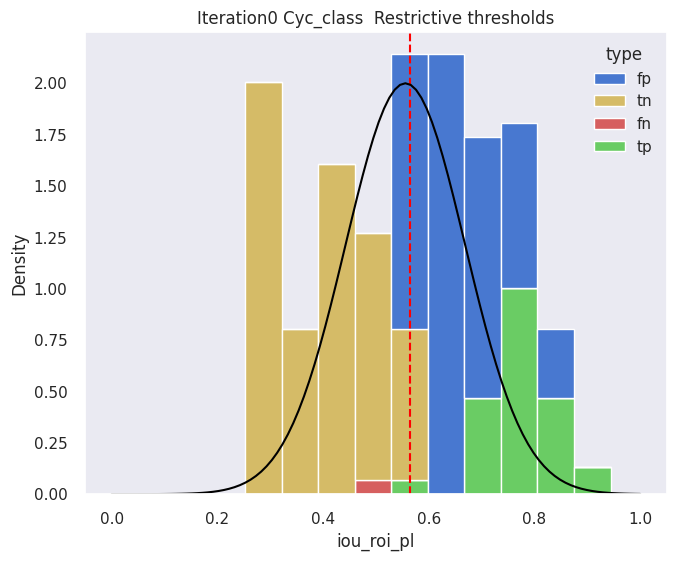

In [55]:
from scipy.stats import norm
from scipy import stats
def gaussian_plot(df):
    x = np.linspace(0,1.0,100)
    mu=df['ema_mean'][0]
    sigma =4* np.var(df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = 2
    return coefficient * np.exp(exponent)

cls_map = {'Car':1,'Ped':2,'Cyc':3}
p = sns.color_palette("muted")
sns.set_theme(style='dark')
palette = {'fp':p[0],'tn':p[-2],'fn':p[3],'tp':p[2]}
f, axes = plt.subplots(1,figsize=(7.5,6))
grouped_df = new_df.groupby('iteration')

for i,df in grouped_df:
    path1 = '/mnt/data/deka01/plots/test'
    path2 = 'Cyc'+str(int(i))+'th_epoch'
    df['class_labels'] == cls_map['Cyc']
    # Joining the paths
    joined_path = os.path.join(path1, path2)
    sns.histplot(data=df,x='iou_roi_pl',hue='type',multiple='stack',stat='density',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
    plt.axvline(x=np.mean(df['iou_roi_pl']),color = 'red',linestyle = '--',label='Epoch_mean')
    plt.plot(np.linspace(0,1.0,100), gaussian_plot(df), color = "black") #plotting normal curve 
    plt.title(f'Iteration{int(i)} Cyc_class  Restrictive thresholds')
    sleep(0.5)
    # plt.legend()
    # plt.savefig(joined_path+'.png')  # Change the file extension to save in a different format
    # plt.close()
    break
plt.show()

In [348]:
name_list = []
for i,df in grouped_df:
    path1 = '/mnt/data/deka01/plots/cyc'
    path2 = 'Cyc'+str(int(i))+'th_epoch.png'
    joined_path = os.path.join(path1, path2)
    name_list.append(joined_path)

In [349]:
from PIL import Image
images = [Image.open(filename) for filename in name_list]

# Save the images as an animated GIF
output_filename = '/mnt/data/deka01/plots/cyc/cyc.gif'
images[0].save(output_filename, save_all=True, append_images=images[1:], duration=600, loop=0)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/deka01/plots/cyc/Cyc61th_epoch.png'

In [12]:
def plot_epochwise_tp_fp_fn_tn(df,cls,path):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'tp':p[2],'fp':p[0],'fn':p[3], 'tn':p[-2]}
    f, axes = plt.subplots(1,figsize=(7.5,6))
    grouped_df = df.groupby('epoch')
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'tp':p[2],'fp':p[0],'fn':p[3], 'tn':p[-2]}
    for i,df in grouped_df:
        path1 = '/mnt/data/deka01/plots/'+str(path)
        path2 = cls+str(int(i))+'th_epoch'
        df['class_labels'] == cls_map[cls]
        # Joining the paths
        joined_path = os.path.join(path1, path2)
        sns.histplot(data=df,x='iou_roi_pl',hue='type',multiple='stack',stat='count',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        plt.title(f'Epoch {int(i)} {cls}_Class  Restrictive thresholds')
        plt.ylim(0, 1200)
        
        sleep(0.5)
        plt.savefig(joined_path+'.png')  # Change the file extension to save in a different format
        plt.close()
        break
path='3diou_thresh/cyc'
plot_epochwise_tp_fp_fn_tn(old_df,'Cyc',path)

In [ ]:
def plot_epochwise_tp_fp_fn_tn(df,cls,path):
    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'tp':p[2],'fp':p[0],'fn':p[3], 'tn':p[-2]}
    f, axes = plt.subplots(1,figsize=(7.5,6))
    grouped_df = df.groupby('epoch')
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'tp':p[2],'fp':p[0],'fn':p[3], 'tn':p[-2]}
    for i,df in grouped_df:
        path1 = '/mnt/data/deka01/plots/'+str(path)
        path2 = cls+str(int(i))+'th_epoch'
        df['class_labels'] == cls_map[cls]
        # Joining the paths
        joined_path = os.path.join(path1, path2)
        sns.histplot(data=df,x='iou_roi_pl',hue='type',multiple='stack',stat='count',hue_order=palette.keys(),bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        plt.title(f'Epoch {int(i)} {cls}_Class  Restrictive thresholds')
        plt.ylim(0, 1200)
        
        sleep(0.5)
        plt.savefig(joined_path+'.png')  # Change the file extension to save in a different format
        plt.close()
path='3diou_thresh/cyc'
plot_epochwise_tp_fp_fn_tn(old_df,'Cyc',path)

In [ ]:
old_df


iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  \
0          0.000000    0.673390        0.0             1     0.653702   
1          0.733902    0.608265        0.0             1     0.806161   
2          0.709852    0.700730        0.0             1     0.987132   
3          0.581061    0.563769        0.0             1     0.682443   
4          0.000000    0.559483        0.0             1     0.864726   
...             ...         ...        ...           ...          ...   
1410824    0.334752    0.722300     1439.0             3     0.776019   
1410825    0.395007    0.675905     1439.0             3     0.638296   
1410826    0.404621    0.560519     1439.0             3     0.405471   
1410827    0.319122    0.532851     1439.0             3     0.700423   
1410828    0.319122    0.532851     1439.0             3     0.734636   

         ema_mean  ema_var  batch_mean  batch_var type  epoch  
0        0.555556  0.00000    0.000000   1.000000   fp    1.0  
1        0.555556  0.00000    0.000000   1.000000   tp    1.0  
2        0.555556  0.00000    0.000000   1.000000   tp    1.0  
3        0.555556  0.00000    0.000000   1.000000   fp    1.0  
4        0.555556  0.00000    0.000000   1.000000   fp    1.0  
...           ...      ...         ...        ...  ...    ...  
1410824  0.540209  0.02461    0.525217   0.024365   fp   60.0  
1410825  0.540209  0.02461    0.525217   0.024365   fp   60.0  
1410826  0.540209  0.02461    0.525217   0.024365   fp   60.0  
1410827  0.540209  0.02461    0.525217   0.024365   tn   60.0  
1410828  0.540209  0.02461    0.525217   0.024365   tn   60.0  

[470331 rows x 11 columns]

In [ ]:
def plot_corres_gt(grouped_df,start,end):
    start = 1
    end = 6
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='darkgrid')
    # for i in range(0,3):
    for i in range(start,end):
        f, axes = plt.subplots(1,2, figsize=(8,5))
        sns.histplot(ax=axes[0],data=grouped_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[1],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',fill=True,bins=10,palette=palette,alpha=1.0)
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        plt.title(f'Epoch {i} FG_thresh= {threshold}')
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()
plot_corres_gt(grouped_df,start=1,end=5)

ValueError: Could not interpret value `fg_wrt_gt` for parameter `hue`

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def gaussian_plot(df):
    x = np.linspace(0, 1.0, 100)
    mu = df['ema_mean'][0]
    sigma = 4 * np.var(df['iou_roi_pl'])
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = 2
    return coefficient * np.exp(exponent)

cls_map = {'Car': 1, 'Ped': 2, 'Cyc': 3}

sns.set_theme(style='dark')
palette = {'tp':p[2],'fp':p[0],'fn':p[3], 'tn':p[-2]}

f, axes = plt.subplots(1, figsize=(7.5, 6))

grouped_df = df.groupby('iteration')

handles, labels = [], []  # Initialize empty lists for handles and labels

for i, df in grouped_df:
    path1 = '/mnt/data/deka01/plots/cyc'
    path2 = 'Cyc' + str(int(i)) + 'th_epoch'
    joined_path = os.path.join(path1, path2)
    
    histplot = sns.histplot(data=df, x='iou_roi_pl', hue='type', multiple='stack', stat='density',
                            hue_order=palette.keys(), bins=10, fill=True, legend=False, palette=palette,
                            alpha=1.0, ax=axes)  # Specify the axes object for the histplot
    
    legend_elements = histplot.get_legend_handles_labels()
    handles.extend(legend_elements[0])  # Add handles for the histplot
    labels.extend(legend_elements[1])  # Add labels for the histplot
    
    plt.axvline(x=df['ema_mean'][0], color='black', linestyle='--')
    plt.plot(np.linspace(0, 1.0, 100), gaussian_plot(df), color="black")
    
    plt.title(f'Iteration {int(i)} Cyc_class Restrictive thresholds')

# Display combined legend for both plots
# f.legend(handles=handles + [plt.Line2D([], [], color='black', linestyle='--'), plt.Line2D([], [], color='black')],
#             labels=labels + ["Mean", "Gaussian Curve"])
plt.legend()
# Save the plot
# plt.savefig(joined_path + '.png')
# plt.close()

plt.show()

KeyError: 0

In [ ]:
cls_df = old_df[old_df['class_labels'] == 1]
cls_df_mask = old_df['class_labels'] == 1
old_df[cls_df_mask]


iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  \
0          0.000000    0.673390        0.0             1     0.653702   
1          0.733902    0.608265        0.0             1     0.806161   
2          0.709852    0.700730        0.0             1     0.987132   
3          0.581061    0.563769        0.0             1     0.682443   
4          0.000000    0.559483        0.0             1     0.864726   
...             ...         ...        ...           ...          ...   
1410666    0.497475    0.512125     1438.0             1     0.364707   
1410668    0.336752    0.318784     1438.0             1     0.070495   
1410670    0.599603    0.511716     1438.0             1     0.362061   
1410671    0.000000    0.473922     1438.0             1     0.464521   
1410672    0.325600    0.314716     1438.0             1     0.166218   

         ema_mean   ema_var  batch_mean  batch_var  type  epoch  
0        0.555556  0.000000    0.000000   1.000000  none    1.0  
1        0.555556  0.000000    0.000000   1.000000  none    1.0  
2        0.555556  0.000000    0.000000   1.000000  none    1.0  
3        0.555556  0.000000    0.000000   1.000000  none    1.0  
4        0.555556  0.000000    0.000000   1.000000  none    1.0  
...           ...       ...         ...        ...   ...    ...  
1410666  0.496234  0.031416    0.495249   0.031137  none   60.0  
1410668  0.496234  0.031416    0.495249   0.031137  none   60.0  
1410670  0.496234  0.031416    0.495249   0.031137  none   60.0  
1410671  0.496234  0.031416    0.495249   0.031137  none   60.0  
1410672  0.496234  0.031416    0.495249   0.031137  none   60.0  

[371281 rows x 11 columns]

##### Extract mean from a raw list of means 

In [ ]:
thresh_list = []
for i in range(0,len(cat_list_new)):
    start = i*128
    end = (i+1)*128
    a=torch.tensor(cat_list_new[i])
    b=torch.tensor(new_df['class_labels'])[start:end]-1
    threshold = a.unsqueeze(dim=0).repeat(128,1).gather(1,index=b.unsqueeze(dim=1)).tolist()
    thresh_list.extend(threshold)

In [ ]:
len(thresh_list)

128

In [ ]:
b.unsqueeze(dim=1).shape

torch.Size([128, 1])

In [ ]:
df['ema_mean'] = df['class_labels'].apply(lambda x: cat_list_new[i][x-1])

In [ ]:
grouped_df.get_group(i)

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  sample   
1411200    0.584648    0.672755     1439.0             1     0.913463   11025  \
1411201    0.000000    0.764587     1439.0             1     0.885602   11025   
1411202    0.000000    0.758040     1439.0             1     0.934972   11025   
1411203    0.783677    0.857290     1439.0             1     0.999956   11025   
1411204    0.468549    0.550244     1439.0             1     0.664506   11025   
...             ...         ...        ...           ...          ...     ...   
1411323    0.000000    0.000000     1439.0             1     0.036478   11025   
1411324    0.000000    0.000000     1439.0             1     0.001391   11025   
1411325    0.000000    0.000000     1439.0             1     0.017456   11025   
1411326    0.000000    0.000000     1439.0             1     0.025617   11025   
1411327    0.000000    0.000000     1439.0             1     0.005244   11025   

        threshold  
1411200       Nan  
1411201       Nan  
1411202       Nan  
1411203       Nan  
1411204       Nan  
...           ...  
1411323       Nan  
1411324       Nan  
1411325       Nan  
1411326       Nan  
1411327       Nan  

[128 rows x 7 columns]

In [ ]:
new_df = grouped_df.apply(lambda x: x.reset_index(drop=False))

In [ ]:
for i in range(len(cat_list_new)):
    start = (i*128)
    end = ((i+1)*128)
    for j in range(start,end):
        new_df['ema_mean'][j] = cat_list_new[new_df['class_labels'][j]-1]

TypeError: list indices must be integers or slices, not Series

In [ ]:
new_df

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores
0          0.608926    0.610662        0.0             1     0.798637
1          0.616228    0.614590        0.0             1     0.640534
2          0.844059    0.813937        0.0             1     0.999992
3          0.724802    0.731550        0.0             1     0.998264
4          0.698061    0.735532        0.0             1     0.954222
...             ...         ...        ...           ...          ...
1411323    0.000000    0.000000     1439.0             1     0.036478
1411324    0.000000    0.000000     1439.0             1     0.001391
1411325    0.000000    0.000000     1439.0             1     0.017456
1411326    0.000000    0.000000     1439.0             1     0.025617
1411327    0.000000    0.000000     1439.0             1     0.005244

[1411328 rows x 5 columns]

In [ ]:
for i in range(len(cat_list_old)):
    start = (i*128)
    end = ((i+1)*128)
    old_df[start:end]['ema_mean'] = cat_list_old[i]

In [ ]:
old_df

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores
0          0.000000    0.654307        0.0             2     0.005736
1          0.629951    0.692538        0.0             1     0.917623
2          0.684521    0.714953        0.0             1     0.996485
3          0.632128    0.669652        0.0             1     0.930351
4          0.662309    0.625660        0.0             1     0.907292
...             ...         ...        ...           ...          ...
1412347    0.000000    0.000000     1439.0             1     0.001413
1412348    0.000000    0.000000     1439.0             2     0.001933
1412349    0.000000    0.000000     1439.0             1     0.095177
1412350    0.000000    0.000000     1439.0             2     0.000964
1412351    0.000000    0.000000     1439.0             2     0.028855

[1412352 rows x 5 columns]

#### Generating TP and FP based on 3diouMatch Threshold FG = 0.75

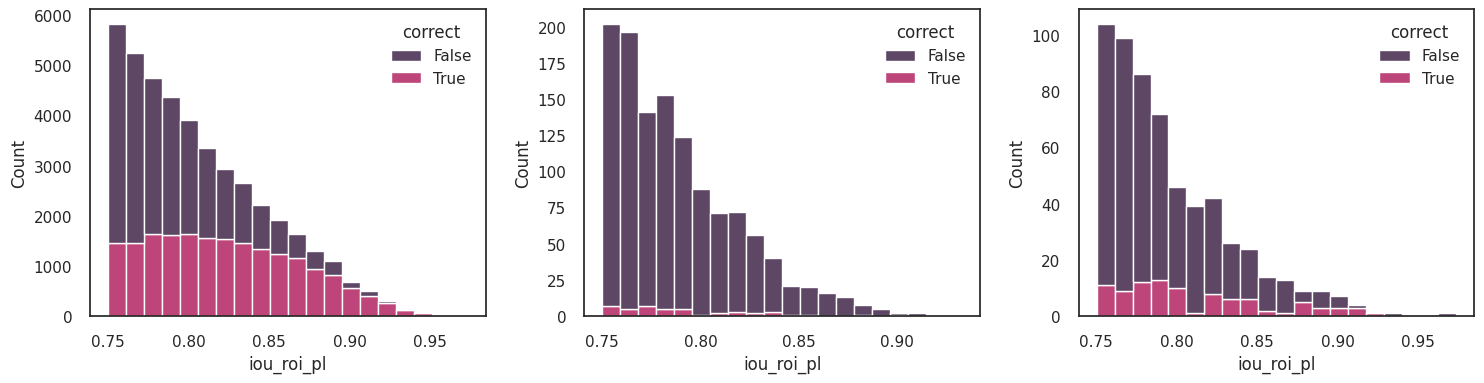

In [ ]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
    'pred_scores': iou3d['pred_scores']
}
thresh_3diou = pd.DataFrame(scores)
thresh_3diou['correct'] = (thresh_3diou['iou_roi_gt'] > 0.75) & (thresh_3diou['iou_roi_pl'] > 0.75)
thresh_3diou['filtered_wrt_pl'] = (thresh_3diou['iou_roi_pl'] > 0.75)
filtered_thresh_df = thresh_3diou[thresh_3diou['filtered_wrt_pl'] == True]
scores_cls = []
p = sns.color_palette('rocket')
palette = [p[0],p[2]]
f, axes = plt.subplots(1,3, figsize=(15,4))
for i in range(0,3):
    # thresh_3diou['correct'] = (thresh_3diou['iou_roi_gt'] >= 0.50) & (thresh_3diou['iou_roi_pl'] >= 0.50)
    mask = (thresh_3diou['class_labels'] == i+1) & (thresh_3diou['iou_roi_pl'] >= 0.75) 
    scores_cls.append(thresh_3diou[mask])
    sns.histplot(ax=axes[i],data=scores_cls[i], x="iou_roi_pl",hue='correct',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, palette=palette, alpha=0.8)
    #sns.lineplot(ax=axes[i],data=scores_cls[i], x=thresh_3diou.index,y="correct",palette=palette, alpha=0.8)
    f.tight_layout()
    f.subplots_adjust(wspace=0.25, hspace=0.2)
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
thresh_3diou['pred_scores']

0           1.080634
1          10.418470
2           0.404545
3           0.847471
4          -1.530079
             ...    
1412091    -3.424217
1412092   -10.724598
1412093    -2.249504
1412094    -9.197587
1412095    -0.692683
Name: pred_scores, Length: 1412096, dtype: float64

In [ ]:
# watch out normalized only if not. 
values = torch.tensor(iou3d['pred_scores'],device='cuda')
values = values.sigmoid()
iou3d['pred_scores'] = values.tolist()

In [ ]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
    'pred_scores': iou3d['pred_scores'],
}
iou3d_df = pd.DataFrame(scores)

In [ ]:
threshold = 0.65
iou3d_df['threshold'] = threshold
iou3d_df['epoch'] = (iou3d_df['iteration']) // 24 + 1
iou3d_df['correct'] = (iou3d_df['iou_roi_pl'] >= threshold) & (iou3d_df['iou_roi_gt'] >= threshold)
iou3d_df['correct_pred'] = (iou3d_df['pred_scores'] >= threshold) & (iou3d_df['iou_roi_gt'] >= threshold)
iou3d_df['fg_wrt_gt'] = (iou3d_df['iou_roi_gt'] >= threshold)
grouped_df = iou3d_df.groupby('epoch')

# Plot Epochwise correspondance of 3dIOUMatch(with changed sem,global thresholds) with GTs 

#### Epoch 1-5

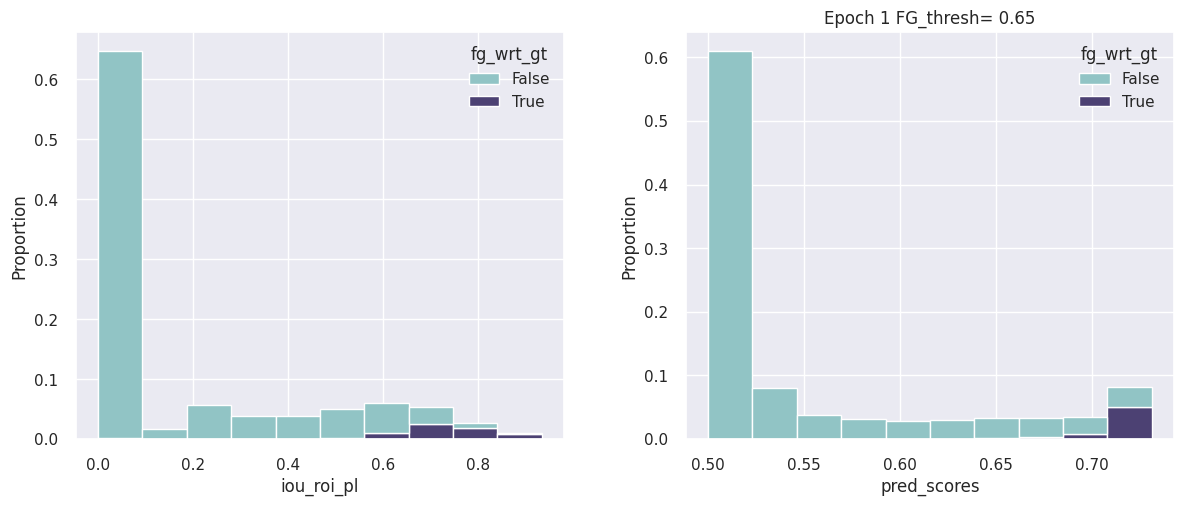

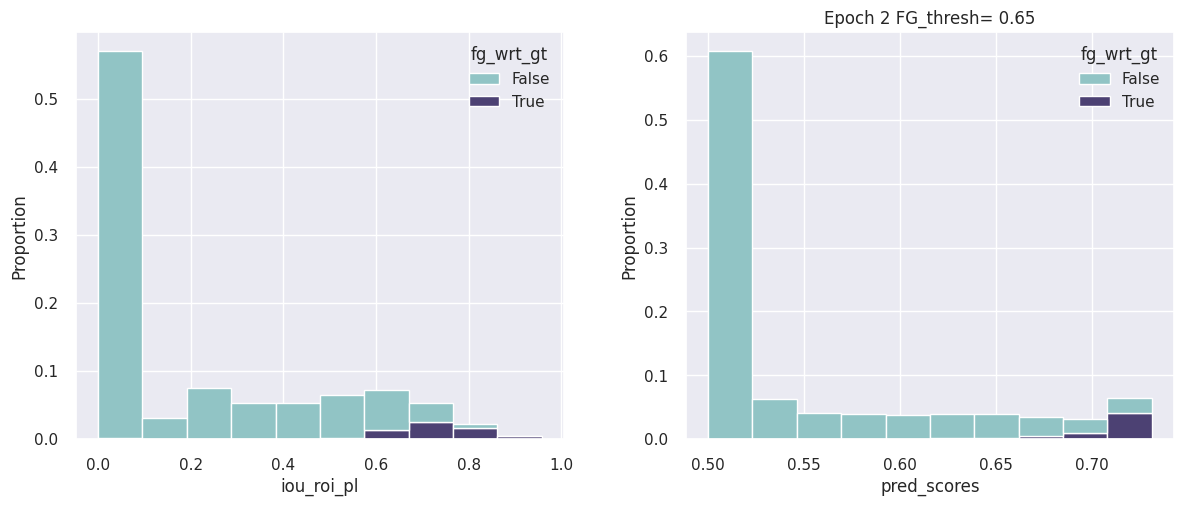

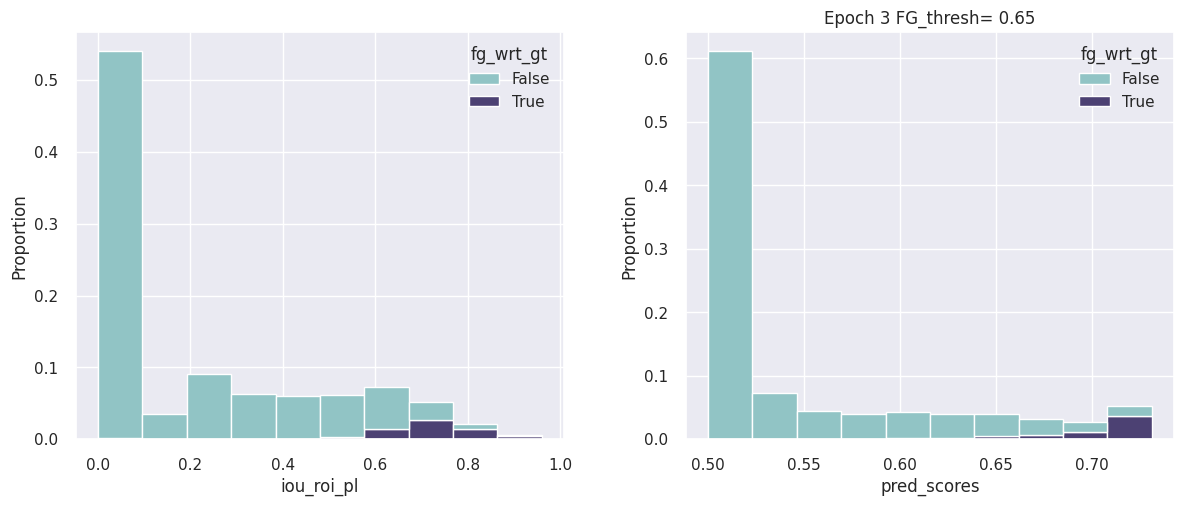

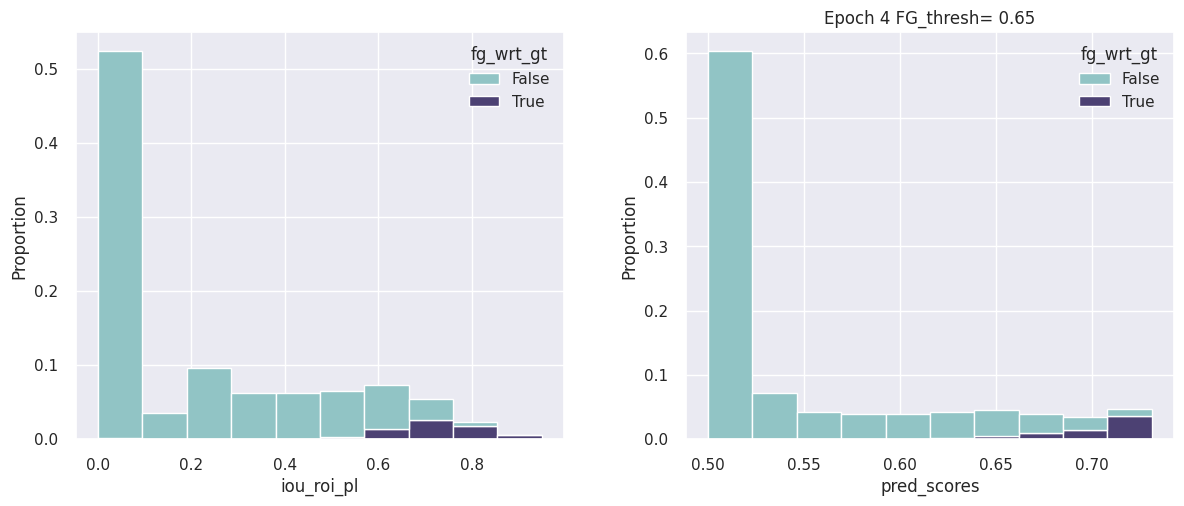

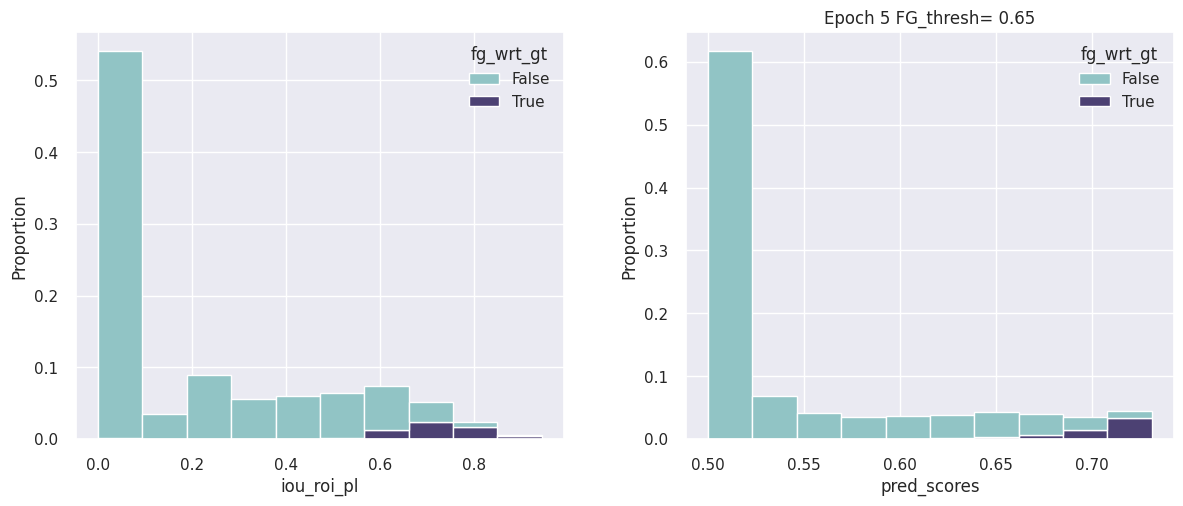

In [ ]:
def plot_corres_gt(grouped_df,start,end):
    start = 1
    end = 6
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='darkgrid')
    # for i in range(0,3):
    for i in range(start,end):
        f, axes = plt.subplots(1,2, figsize=(12,5))
        sns.histplot(ax=axes[0],data=grouped_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[1],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',fill=True,bins=10,palette=palette,alpha=1.0)
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        plt.title(f'Epoch {i} FG_thresh= {threshold}')
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()
plot_corres_gt(grouped_df,start=1,end=5)

#### Epochs 40-45

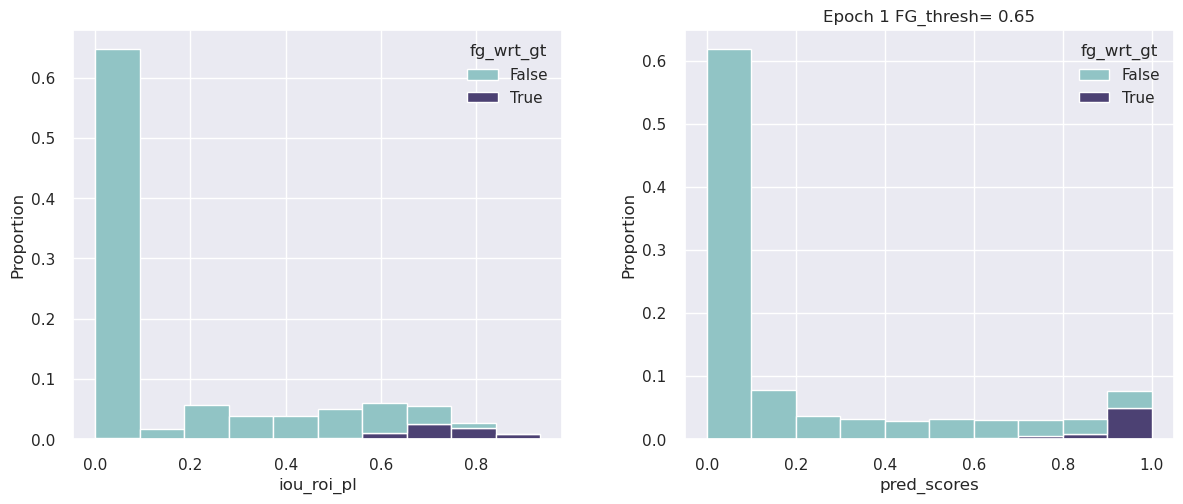

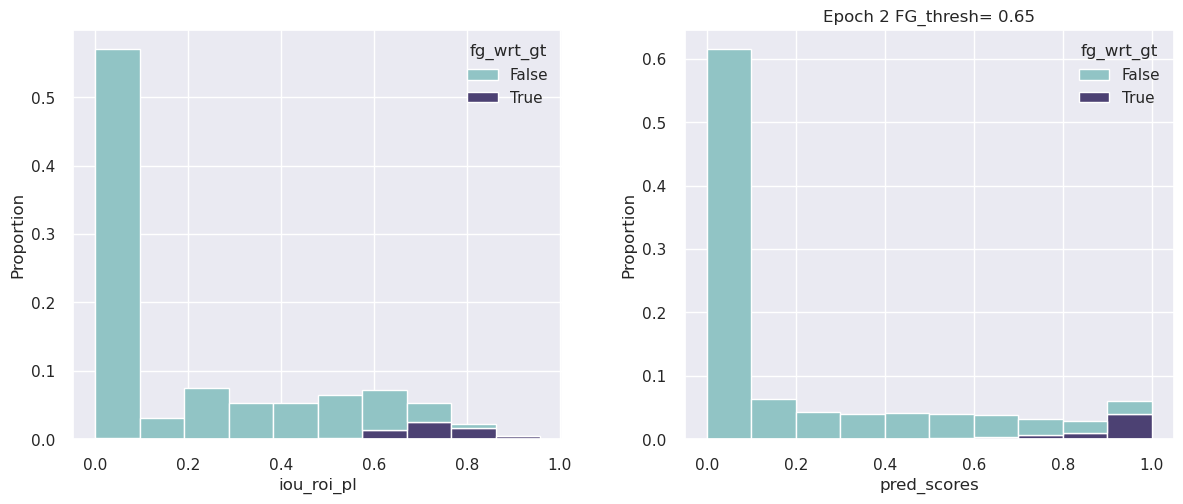

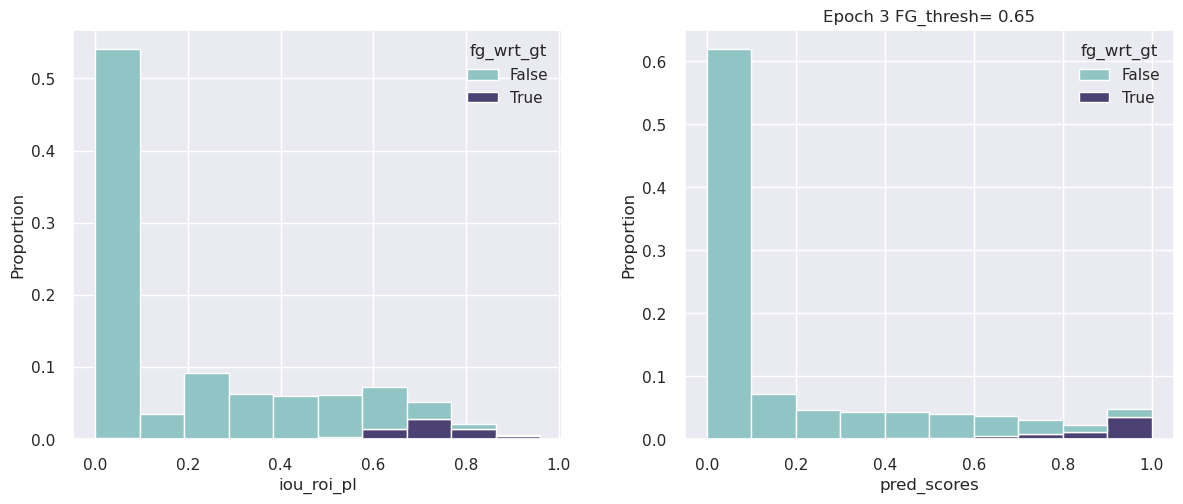

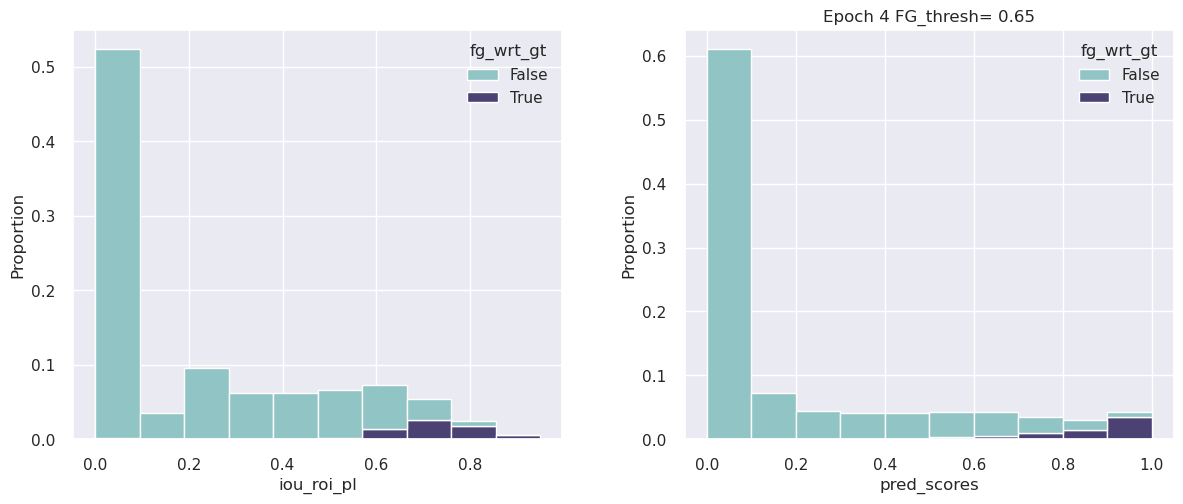

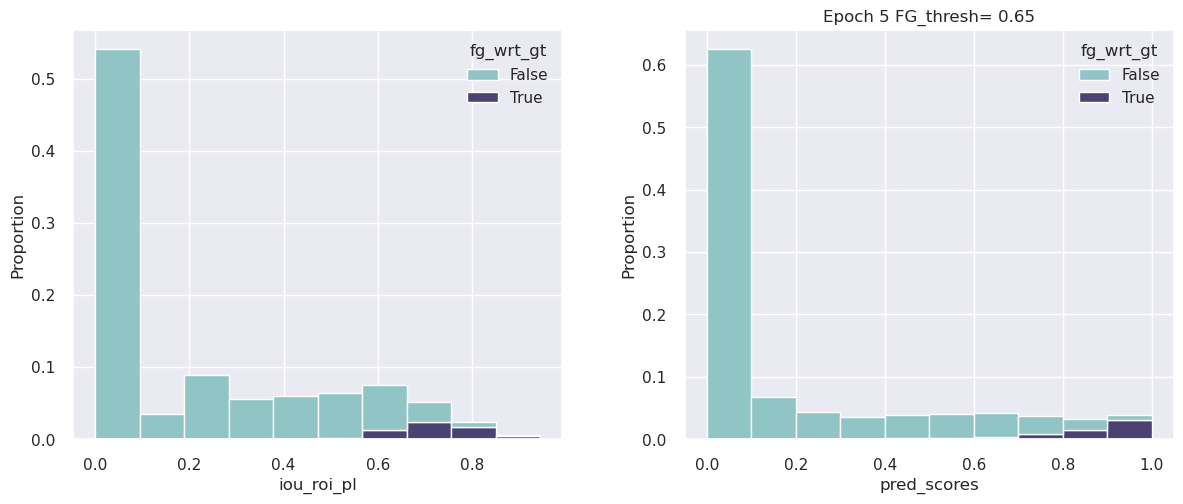

In [ ]:
plot_corres_gt(grouped_df,start=40,end=45)

In [ ]:
threshold = 0.60
scores = {
    'iou_roi_gt': iou3d_old_thresh['iou_roi_gt'],
    'iou_roi_pl': iou3d_old_thresh['iou_roi_pl'],
    'iteration' : iou3d_old_thresh['iteration'],
    'class_labels': iou3d_old_thresh['class_labels'],
    'pred_scores': iou3d_old_thresh['pred_scores'],
    'threshold': threshold,
    'roi_scores': iou3d_old_thresh['roi_scores']
}
iou3d_ot_df = pd.DataFrame(scores)

In [ ]:
iou3d_ot_df.head()

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  threshold   
0    0.594777    0.697189        0.0             1     0.924146        0.6  \
1    0.686190    0.640282        0.0             1     0.880578        0.6   
2    0.000000    0.721479        0.0             1     0.771008        0.6   
3    0.000000    0.742094        0.0             2     0.814994        0.6   
4    0.000000    0.570624        0.0             1     0.601770        0.6   

   roi_scores  
0    0.036497  
1    0.043485  
2    0.829503  
3    0.491779  
4    0.057287

In [ ]:
iou3d_ot_df['threshold'] = threshold
iou3d_ot_df['epoch'] = (iou3d_ot_df['iteration']) // 24 + 1
iou3d_ot_df['correct'] = (iou3d_ot_df['iou_roi_pl'] >= threshold) & (iou3d_ot_df['iou_roi_gt'] >= threshold)
iou3d_ot_df['fg_wrt_gt'] = (iou3d_ot_df['iou_roi_gt'] >= threshold)
grouped_ot_df = iou3d_ot_df.groupby('epoch')

# Plot of correspondance of 3dIOUMatch with default thresholds as in Paper

#### Epochs 1 - 5

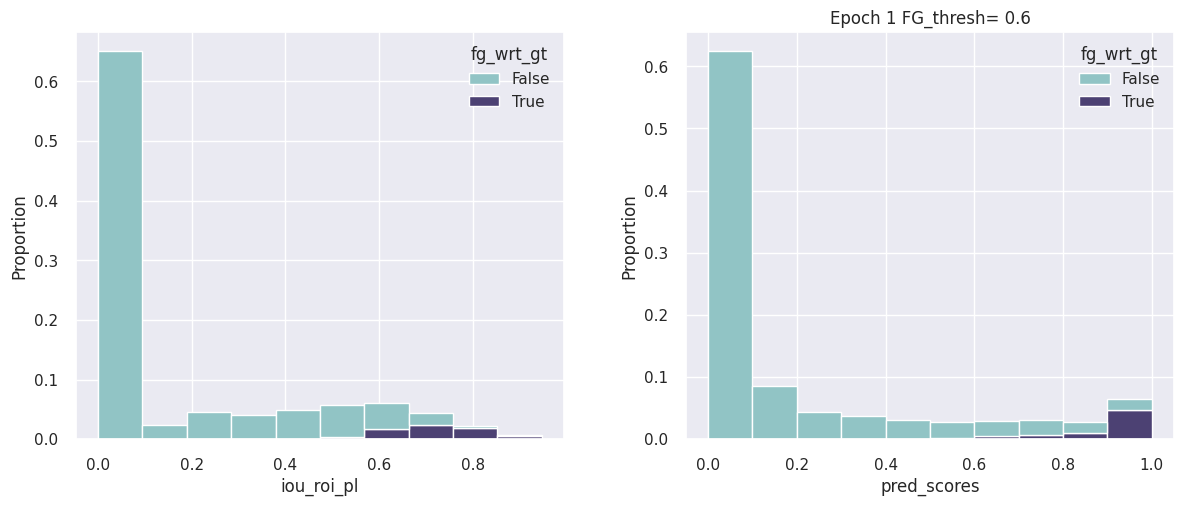

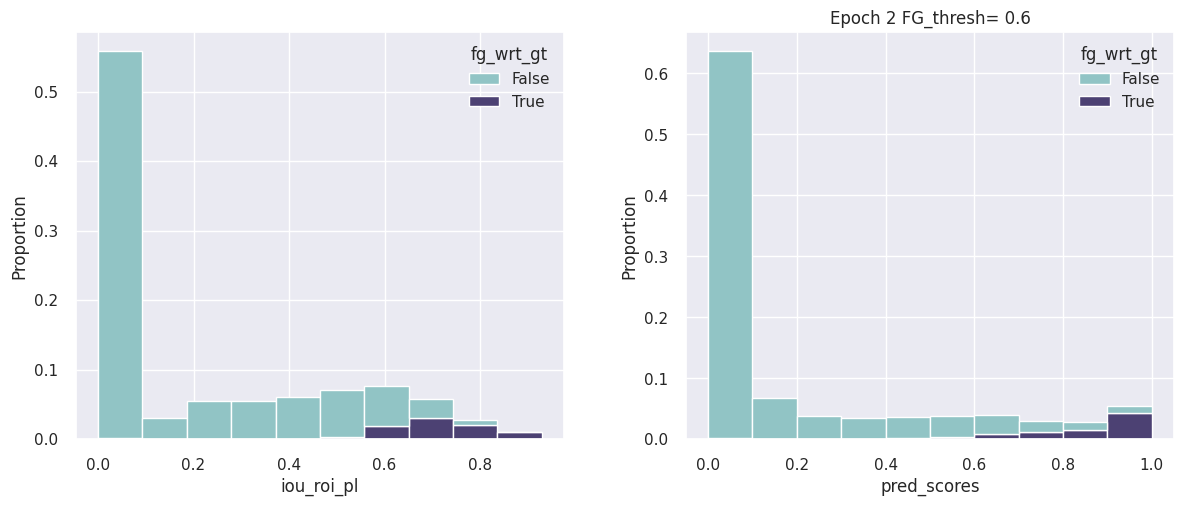

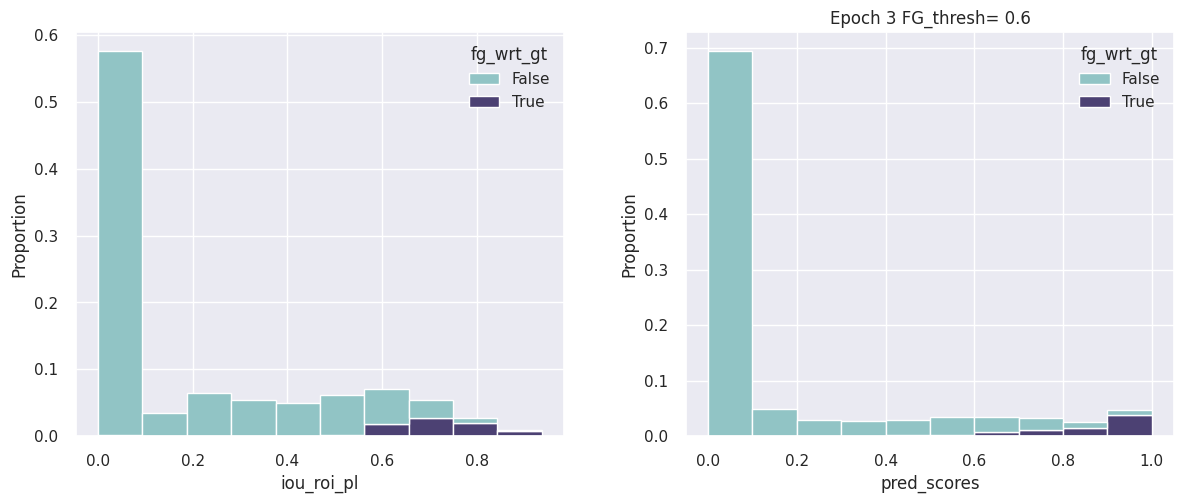

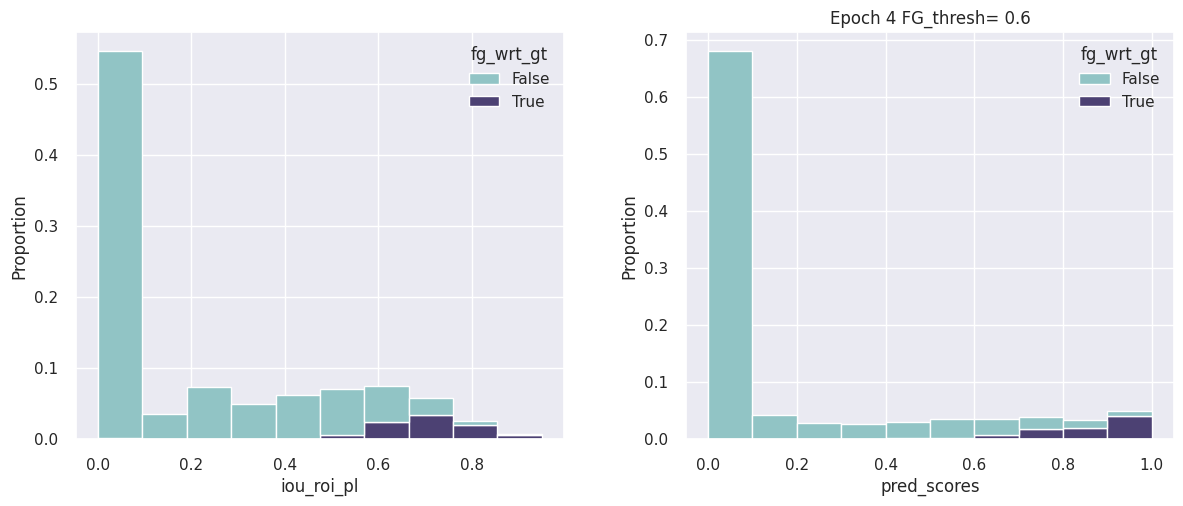

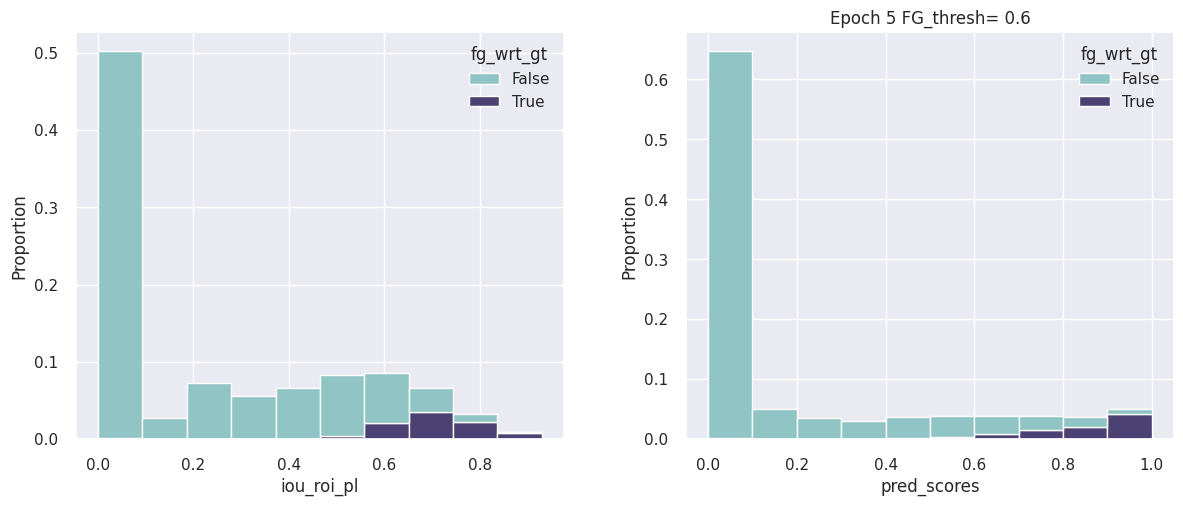

In [ ]:
plot_corres_gt(grouped_ot_df,start=1,end=5)

#### Epoch 45-50

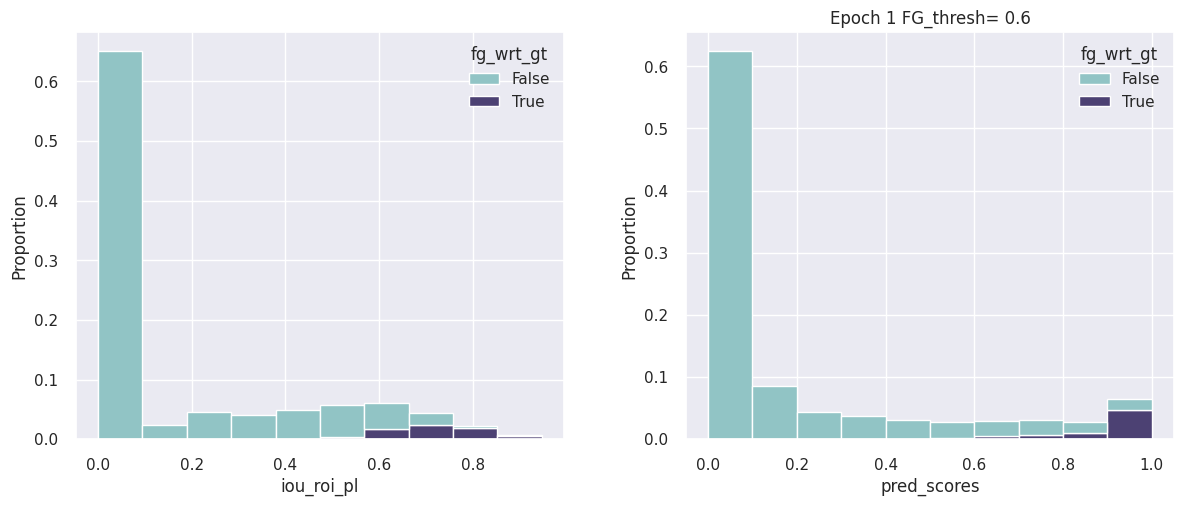

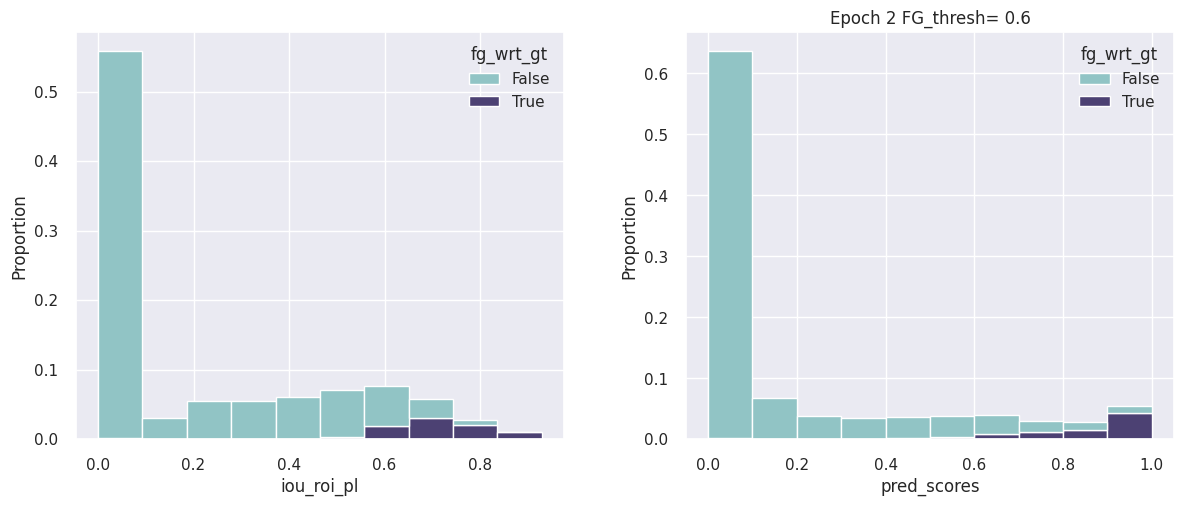

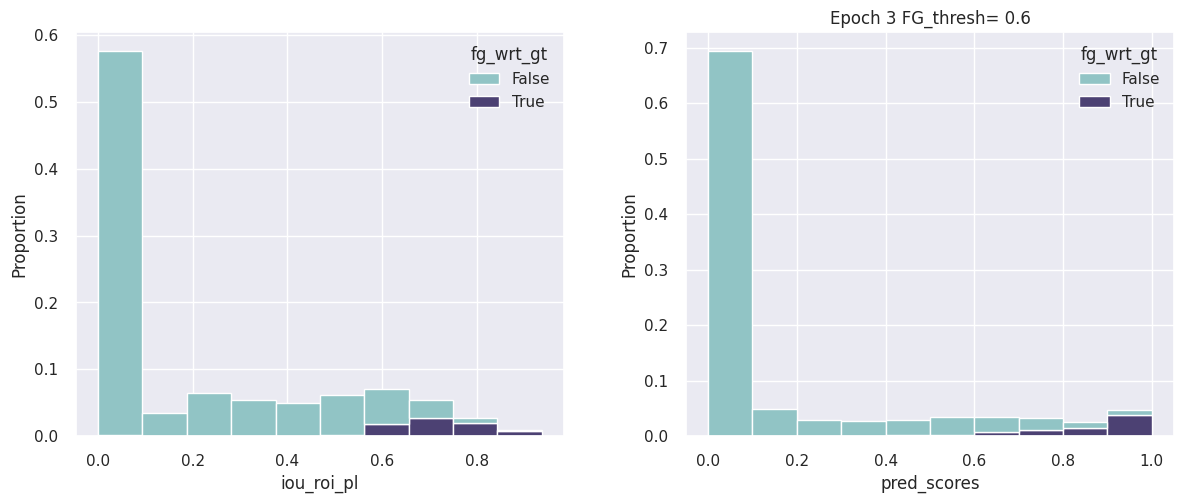

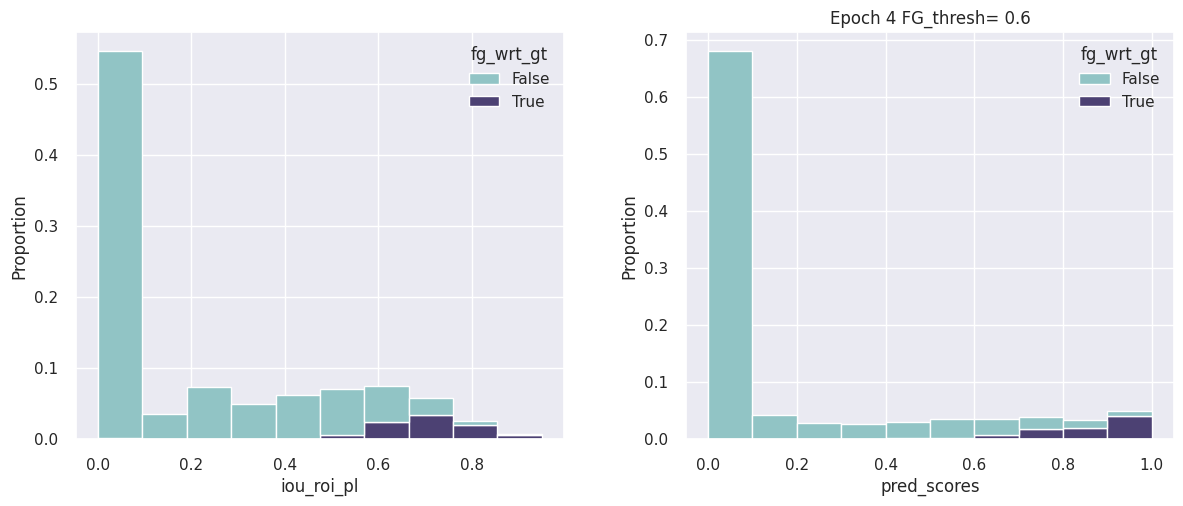

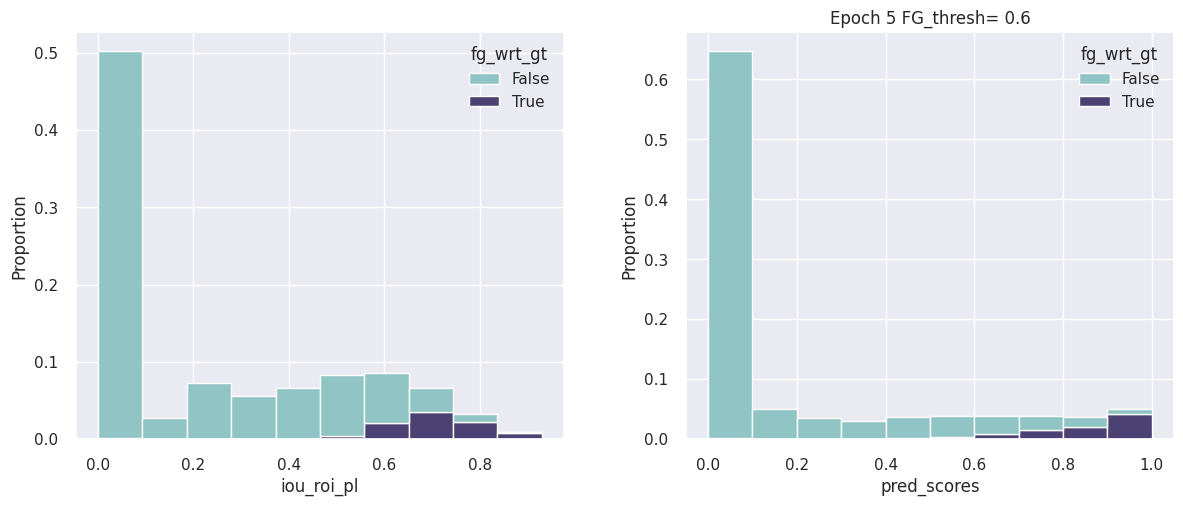

In [ ]:
plot_corres_gt(grouped_ot_df,45,50)

#### Zoomed in Visualization

In [ ]:
# to visualize in terms of iou
iou3d_ot_iou_df = iou3d_ot_df[iou3d_ot_df['iou_roi_pl']>= 0.25]
grouped_ot_iou_df = iou3d_ot_iou_df.groupby('epoch')
# only sees the pred values above 0.25 for better visualization
iou3d_ot_df['pred_bins'] = iou3d_ot_iou_df['pred_scores'].apply(lambda x: round(x,1))
iou3d_ot_pred_df = iou3d_ot_df[iou3d_ot_df['pred_scores']>= 0.25]
grouped_ot_pred_df = iou3d_ot_pred_df.groupby('epoch')

In [ ]:
iou3d_ot_pred_car_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 1)]
iou3d_ot_pred_ped_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 2)]
iou3d_ot_pred_cyc_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 3)]
grouped_ot_pred_car_df = iou3d_ot_pred_car_df.groupby('epoch')
grouped_ot_pred_ped_df = iou3d_ot_pred_ped_df.groupby('epoch')
grouped_ot_pred_cyc_df = iou3d_ot_pred_cyc_df.groupby('epoch')

In [ ]:
df = grouped_ot_pred_car_df.get_group(1)
values = {
    'range': [],
    'prob': [],
    'tp': []
}
x = np.linspace(0.25,0.975,29)
interval = (x[1]-x[0])
for i,val in enumerate(x):
    iter_df = df[(df['pred_scores'] >= val) & (df['pred_scores'] < (val+interval)) & (df['class_labels']==1)]
    values['prob'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0])
    values['range'].append(val)
    values['tp'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0])
    

## Probability that a sample is a TP

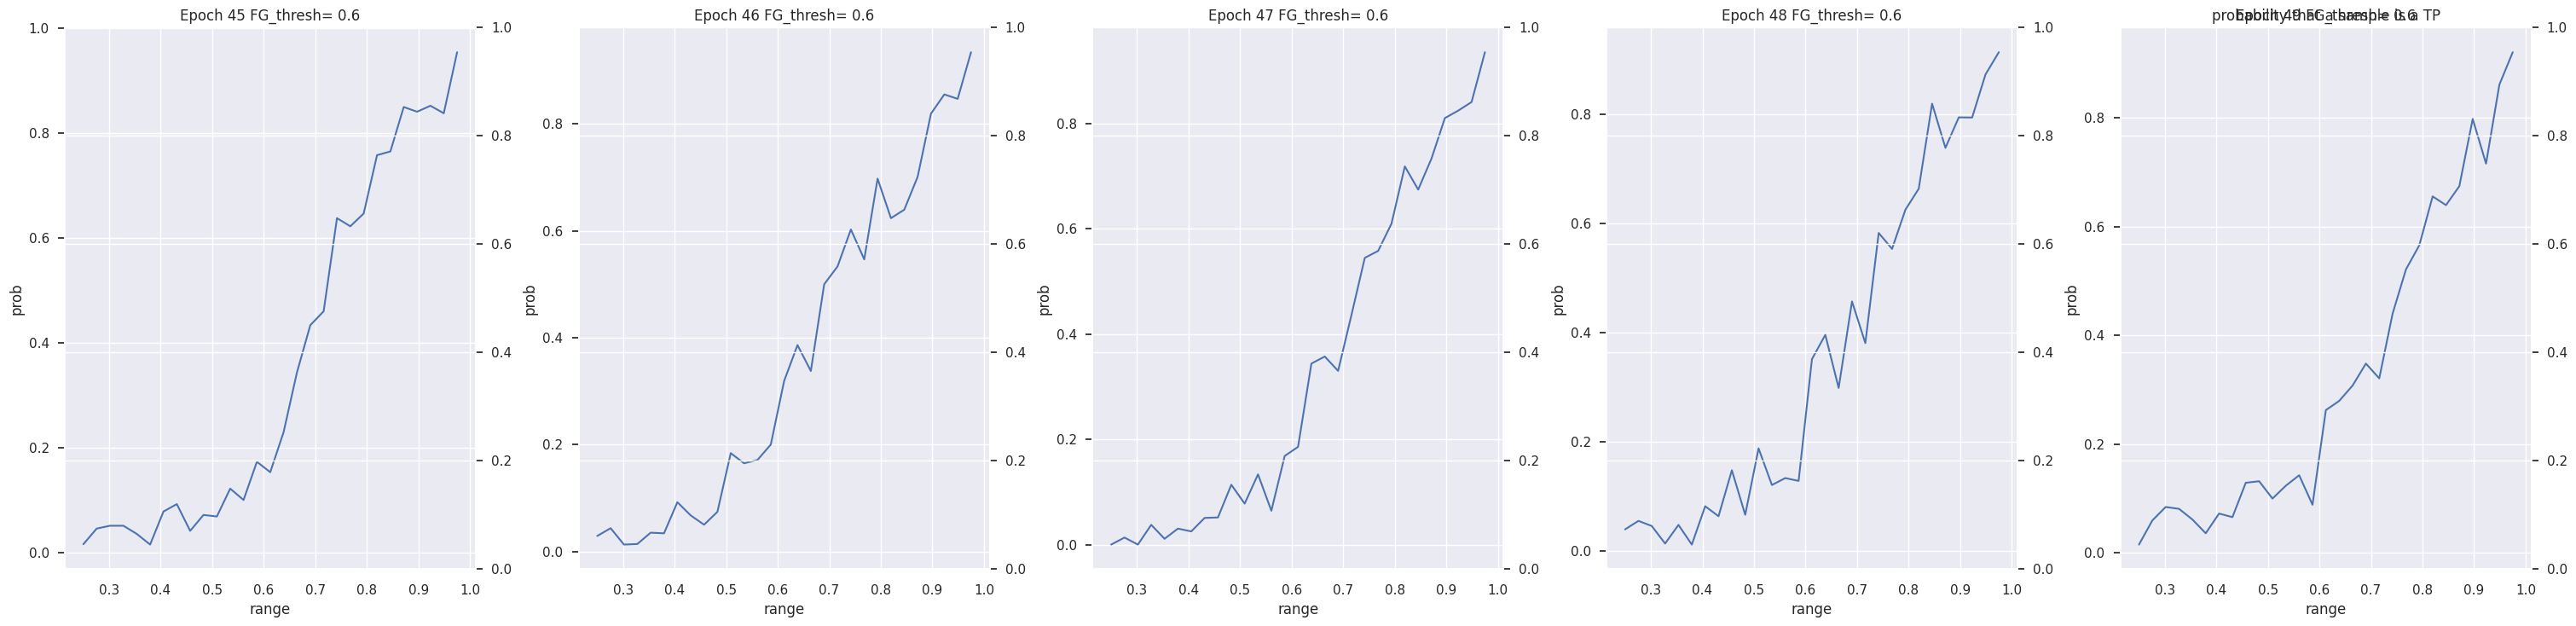

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch_prob(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='darkgrid')
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for iter in range(start,end):
        df = grouped_df.get_group(iter)
        values = {
        'range': [],
        'prob': [],
    }
        x = np.linspace(0.25,0.975,29)
        interval = (x[1]-x[0])
        for i,val in enumerate(x):
            iter_df = df[(df['pred_scores'] >= val) & (df['pred_scores'] < (val+interval)) & (df['class_labels']==1)]
            values['prob'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0])
            values['range'].append(val)
        filter_df = pd.DataFrame(values)
        sns.lineplot(ax=axes[iter-start],data=filter_df,x='range',y='prob',markers=True,palette=palette,alpha=1.0)
        axes[iter-start].set_title(f'Epoch {iter} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[iter-start].twinx()
        ax2.set_ylim(0, 1)
    plt.title("probability that a sample is a TP")
    plt.show()
plot_epoch_prob(grouped_ot_pred_car_df,45,50)

In [ ]:
prob_df = pd.DataFrame(values)
prob_df

range      prob   tp
0   0.250000  0.012821    1
1   0.275893  0.010753    1
2   0.301786  0.011905    1
3   0.327679  0.000000    0
4   0.353571  0.013158    1
5   0.379464  0.038961    3
6   0.405357  0.000000    0
7   0.431250  0.055556    4
8   0.457143  0.000000    0
9   0.483036  0.051724    3
10  0.508929  0.032258    2
11  0.534821  0.044118    3
12  0.560714  0.068493    5
13  0.586607  0.096154    5
14  0.612500  0.137255    7
15  0.638393  0.109589    8
16  0.664286  0.266667   20
17  0.690179  0.289157   24
18  0.716071  0.240506   19
19  0.741964  0.258621   15
20  0.767857  0.197183   14
21  0.793750  0.433333   26
22  0.819643  0.405405   30
23  0.845536  0.392857   22
24  0.871429  0.492958   35
25  0.897321  0.649351   50
26  0.923214  0.674157   60
27  0.949107  0.712766   67
28  0.975000  0.890511  366

In [ ]:
interval

0.025892857142857162

In [ ]:
iou3d_ot_pred_car_df

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0         0.594777    0.697189        0.0             1     0.924146  \
1         0.686190    0.640282        0.0             1     0.880578   
2         0.000000    0.721479        0.0             1     0.771008   
4         0.000000    0.570624        0.0             1     0.601770   
5         0.000000    0.707966        0.0             1     0.948557   
...            ...         ...        ...           ...          ...   
707569    0.000000    0.000000     1438.0             1     0.754854   
707570    0.000000    0.000000     1438.0             1     0.306326   
707571    0.000000    0.000000     1438.0             1     0.564434   
707638    0.000000    0.000000     1439.0             1     0.579544   
707656    0.000000    0.000000     1439.0             1     0.786990   

        threshold  roi_scores  epoch  correct  fg_wrt_gt  pred_bins  
0             0.6    0.036497    1.0    False      False        0.9  
1             0.6    0.043485    1.0     True       True        0.9  
2             0.6    0.829503    1.0    False      False        0.8  
4             0.6    0.057287    1.0    False      False        0.6  
5             0.6    0.029311    1.0    False      False        0.9  
...           ...         ...    ...      ...        ...        ...  
707569        0.6    0.143605   60.0    False      False        NaN  
707570        0.6    0.032402   60.0    False      False        NaN  
707571        0.6    0.030909   60.0    False      False        NaN  
707638        0.6    0.080209   60.0    False      False        NaN  
707656        0.6    0.045346   60.0    False      False        NaN  

[160018 rows x 11 columns]

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
start = 1
end = 6
p =sns.cubehelix_palette(start=.5, rot=-.5)
palette = [p[1],p[4]]
sns.set_theme(style='dark')
for i in range(0,3):
 with PdfPages('plots.pdf') as pdf:
    for i in range(start,end):
        f, axes = plt.subplots(1,2, figsize=(15,5))
        sns.histplot(ax=axes[0],data=grouped_ot_iou_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[1],data=grouped_ot_pred_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)

        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        plt.title(f'Epoch {i} FG_thresh= {threshold}')
        # Iterate over the subplots in axes
        ax2_1 = axes[0].twinx()
        ax2_2 = axes[1].twinx()

        # Set the y-axis limits to 0 and 1 for each twin axes
        ax2_1.set_ylim(0, 1)
        ax2_2.set_ylim(0, 1)

        # Remove the spines and ticks of the left y-axis for each subplot
        ax2_1.spines['left'].set_visible(False)
        ax2_1.yaxis.set_ticks_position('none')
        ax2_2.spines['left'].set_visible(False)
        ax2_2.yaxis.set_ticks_position('none')

        # Remove the spines and ticks of the right y-axis for each subplot
        ax2_1.spines['right'].set_linewidth(0.5)
        ax2_1.spines['right'].set_color('black')
        ax2_1.spines['right'].set_visible(True)
        ax2_1.yaxis.tick_right()
        ax2_1.yaxis.set_label_position('right')

        ax2_2.spines['right'].set_linewidth(0.5)
        ax2_2.spines['right'].set_color('black')
        ax2_2.spines['right'].set_visible(True)
        ax2_2.yaxis.tick_right()
        ax2_2.yaxis.set_label_position('right')
        pdf.savefig(f)
        plt.close(f)
    # Set the label for the right y-axis
f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()


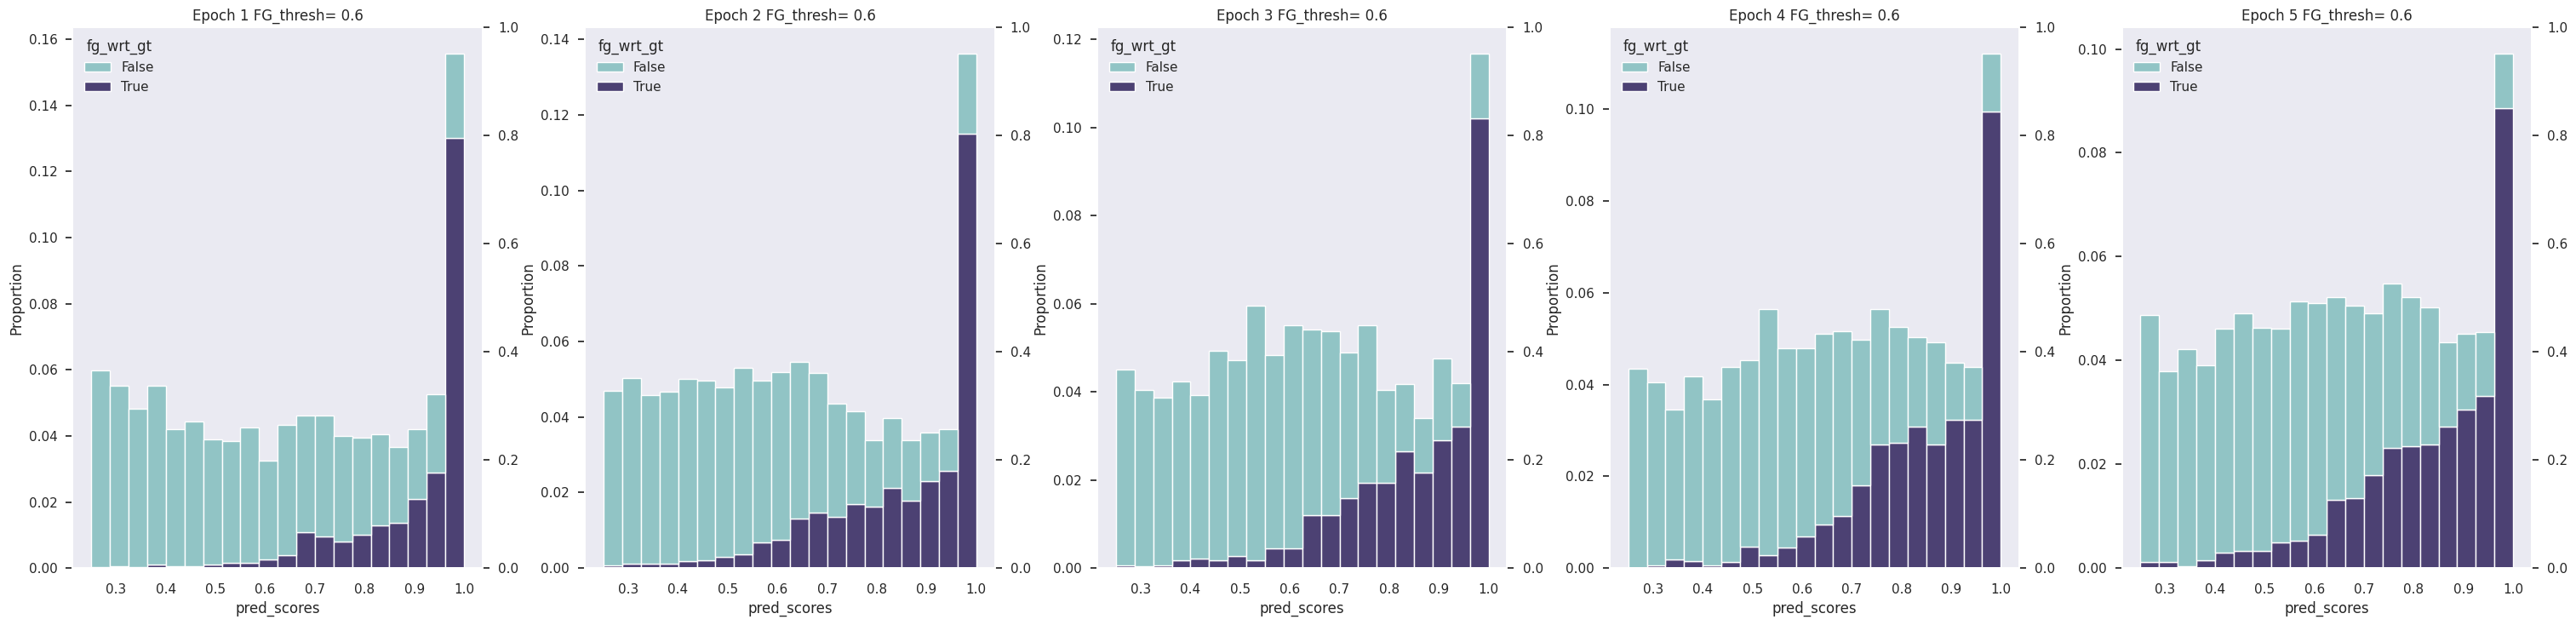

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    grouped_ot_pred_df = iou3d_ot_pred_df.groupby('epoch')
    # for i in range(0,3):
    # with PdfPages('plots.pdf') as pdf:
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(grouped_ot_pred_df,1,6)


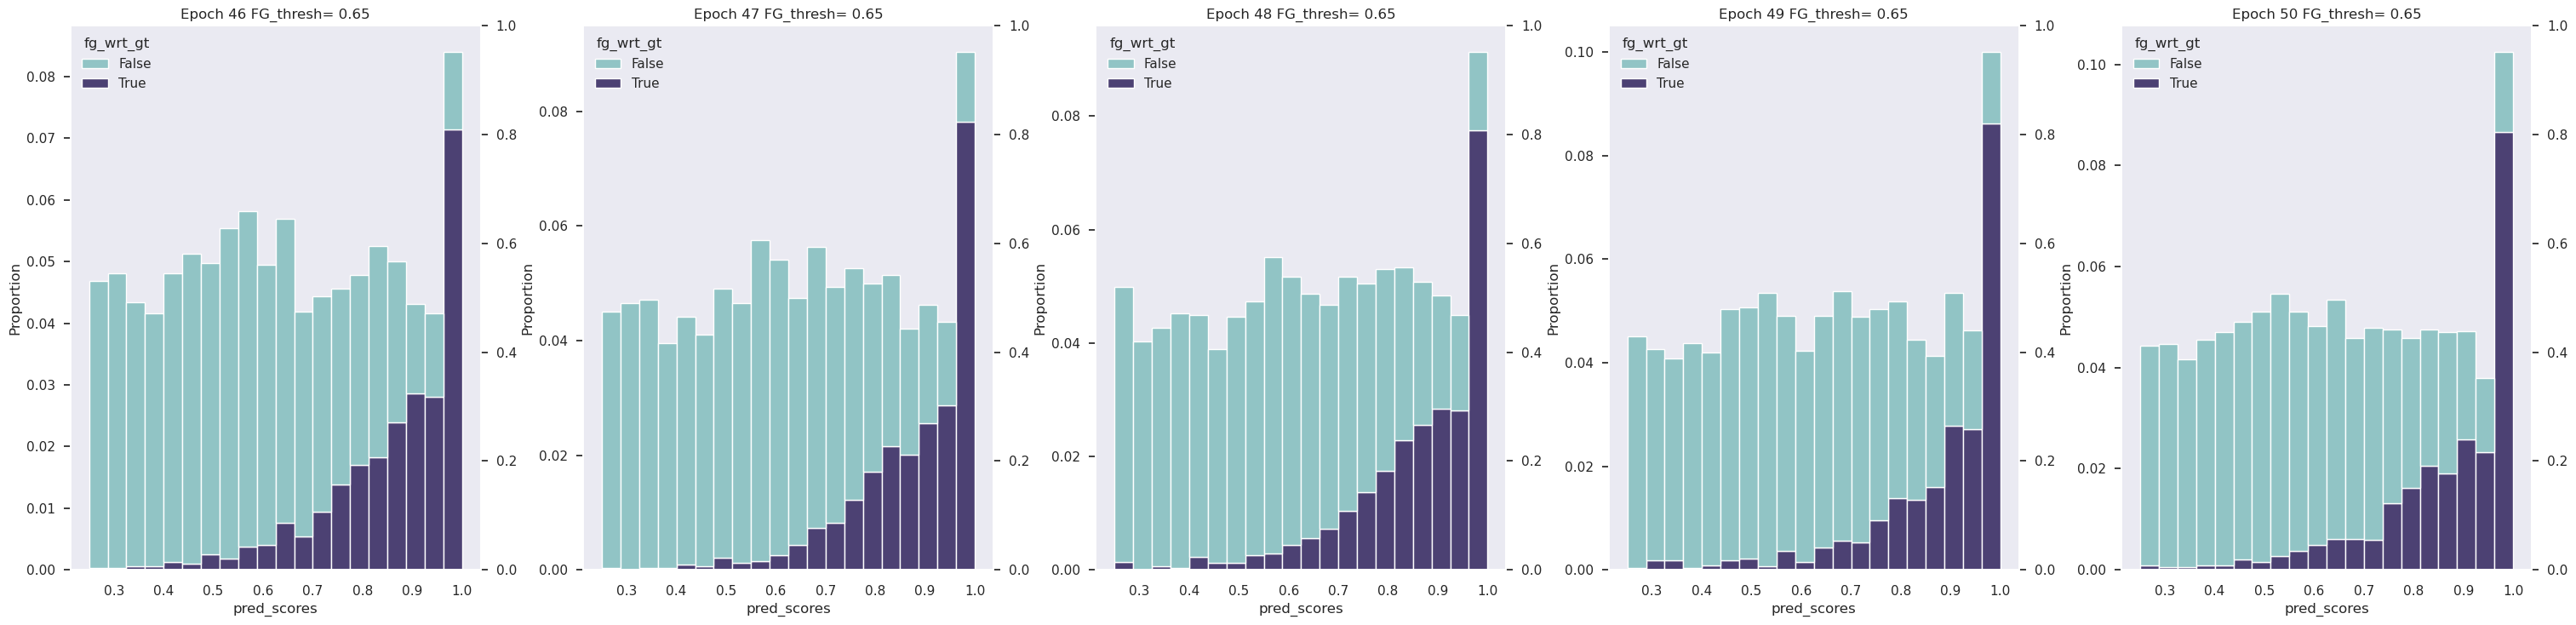

In [ ]:
plot_epoch(grouped_ot_pred_df,46,51)

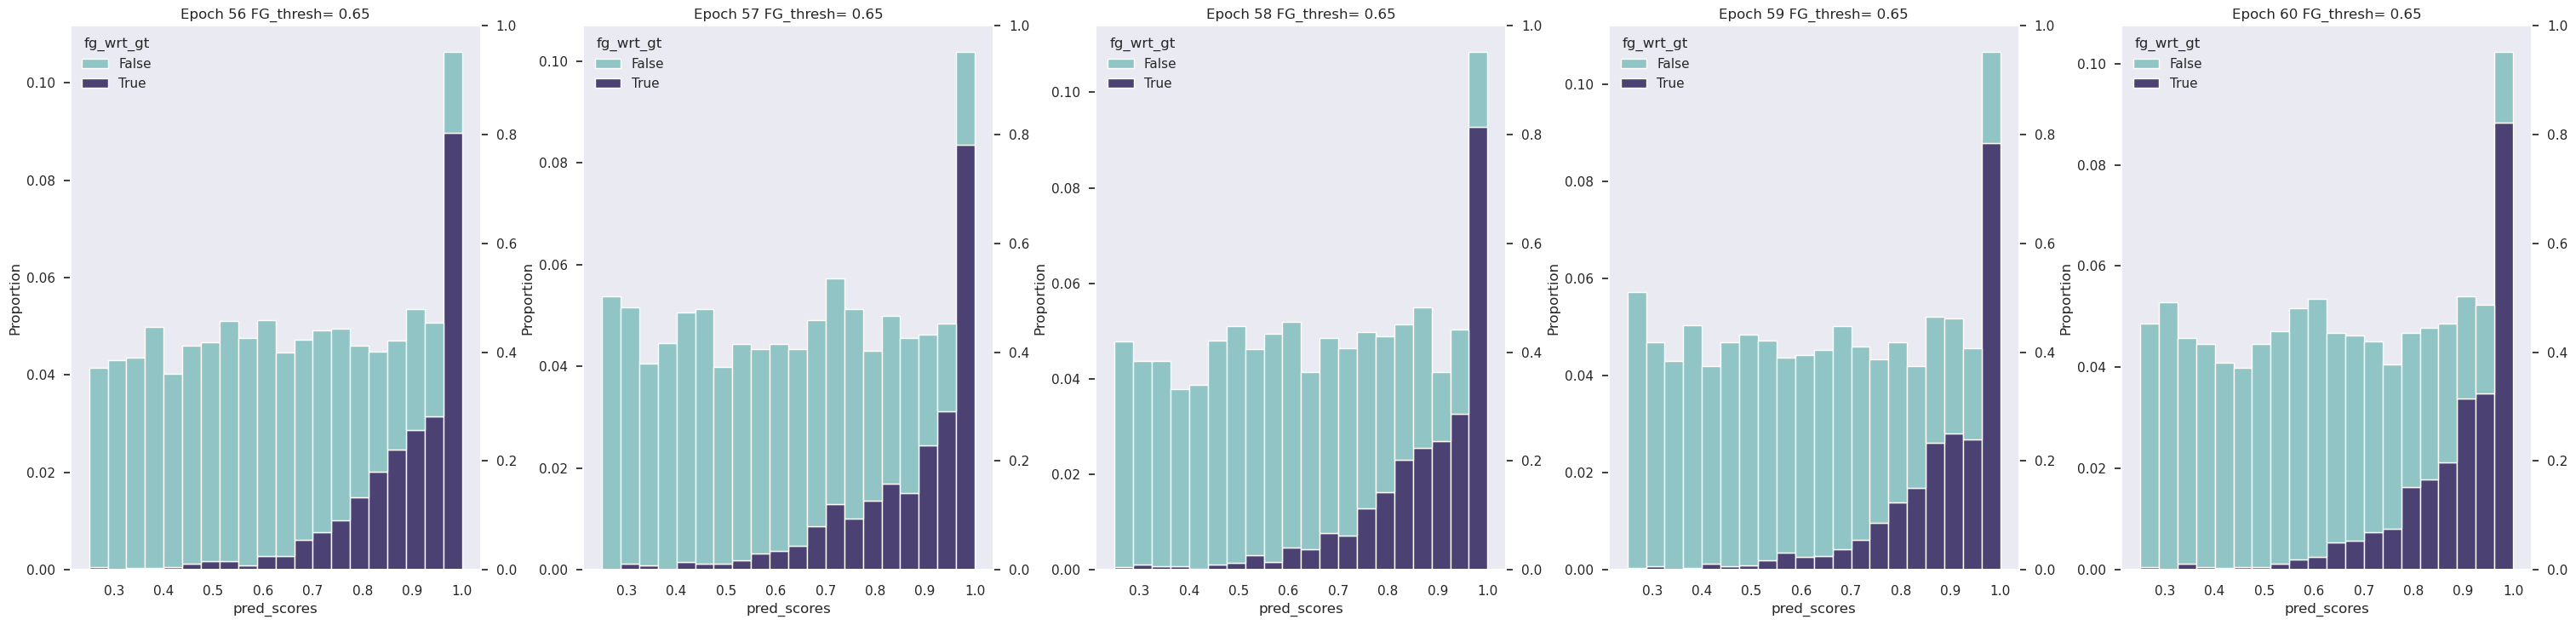

In [ ]:
plot_epoch(grouped_ot_pred_df,56,61)

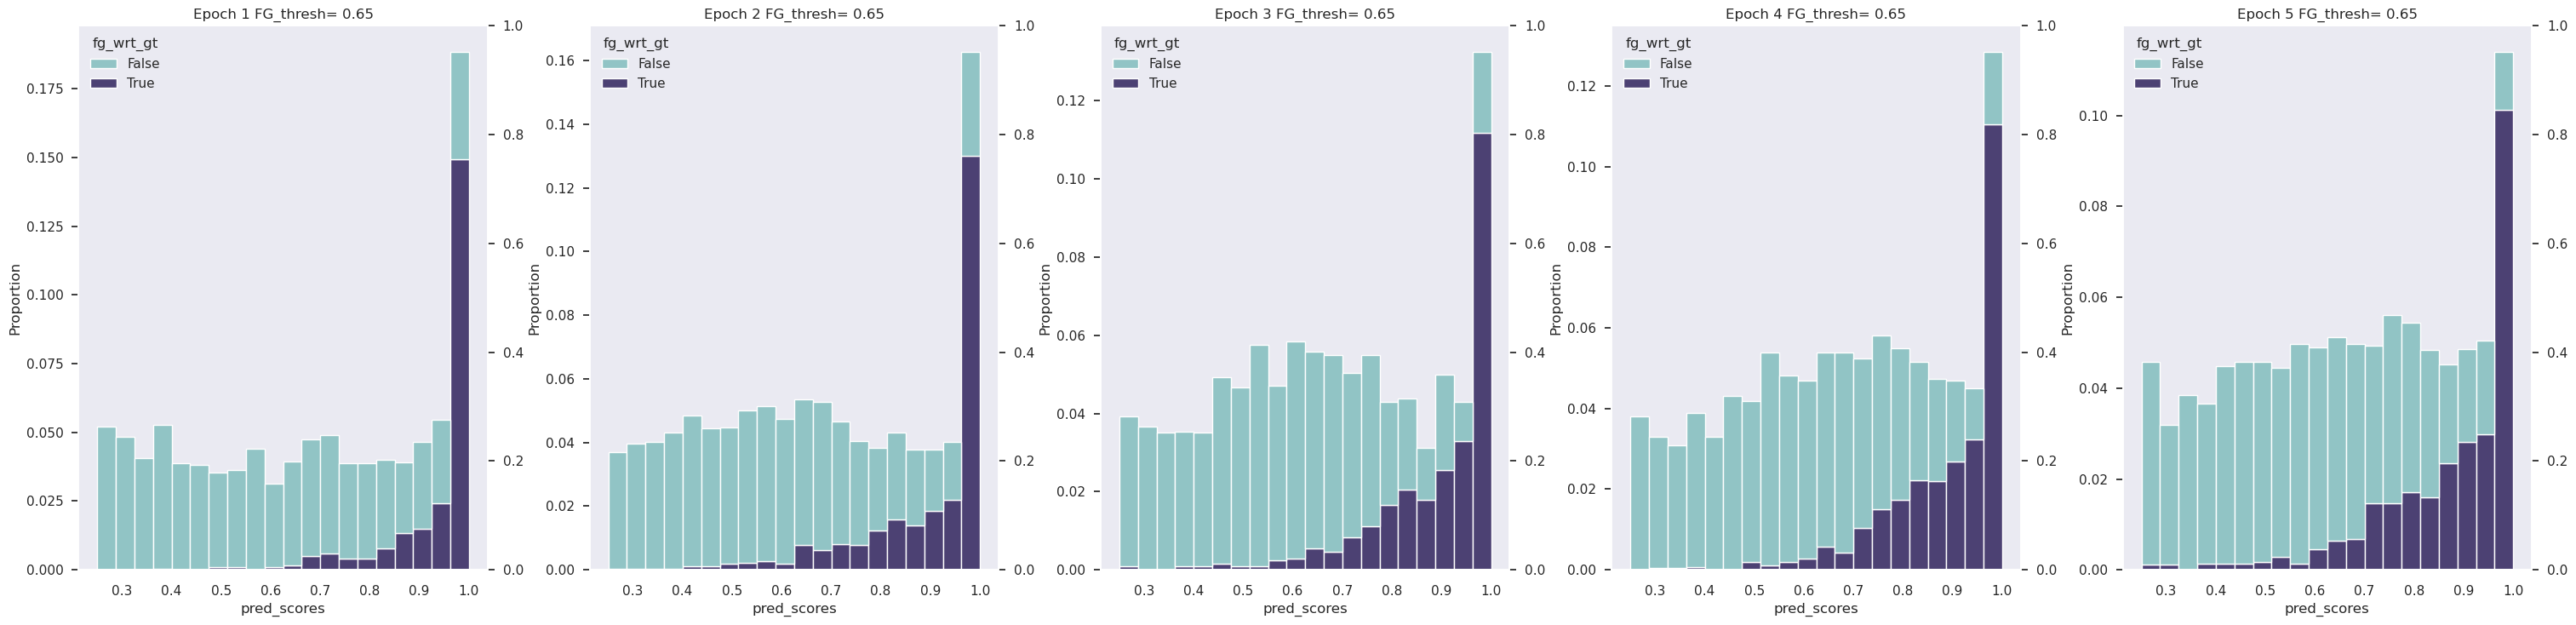

In [ ]:
plot_epoch(grouped_ot_pred_car_df,1,6)

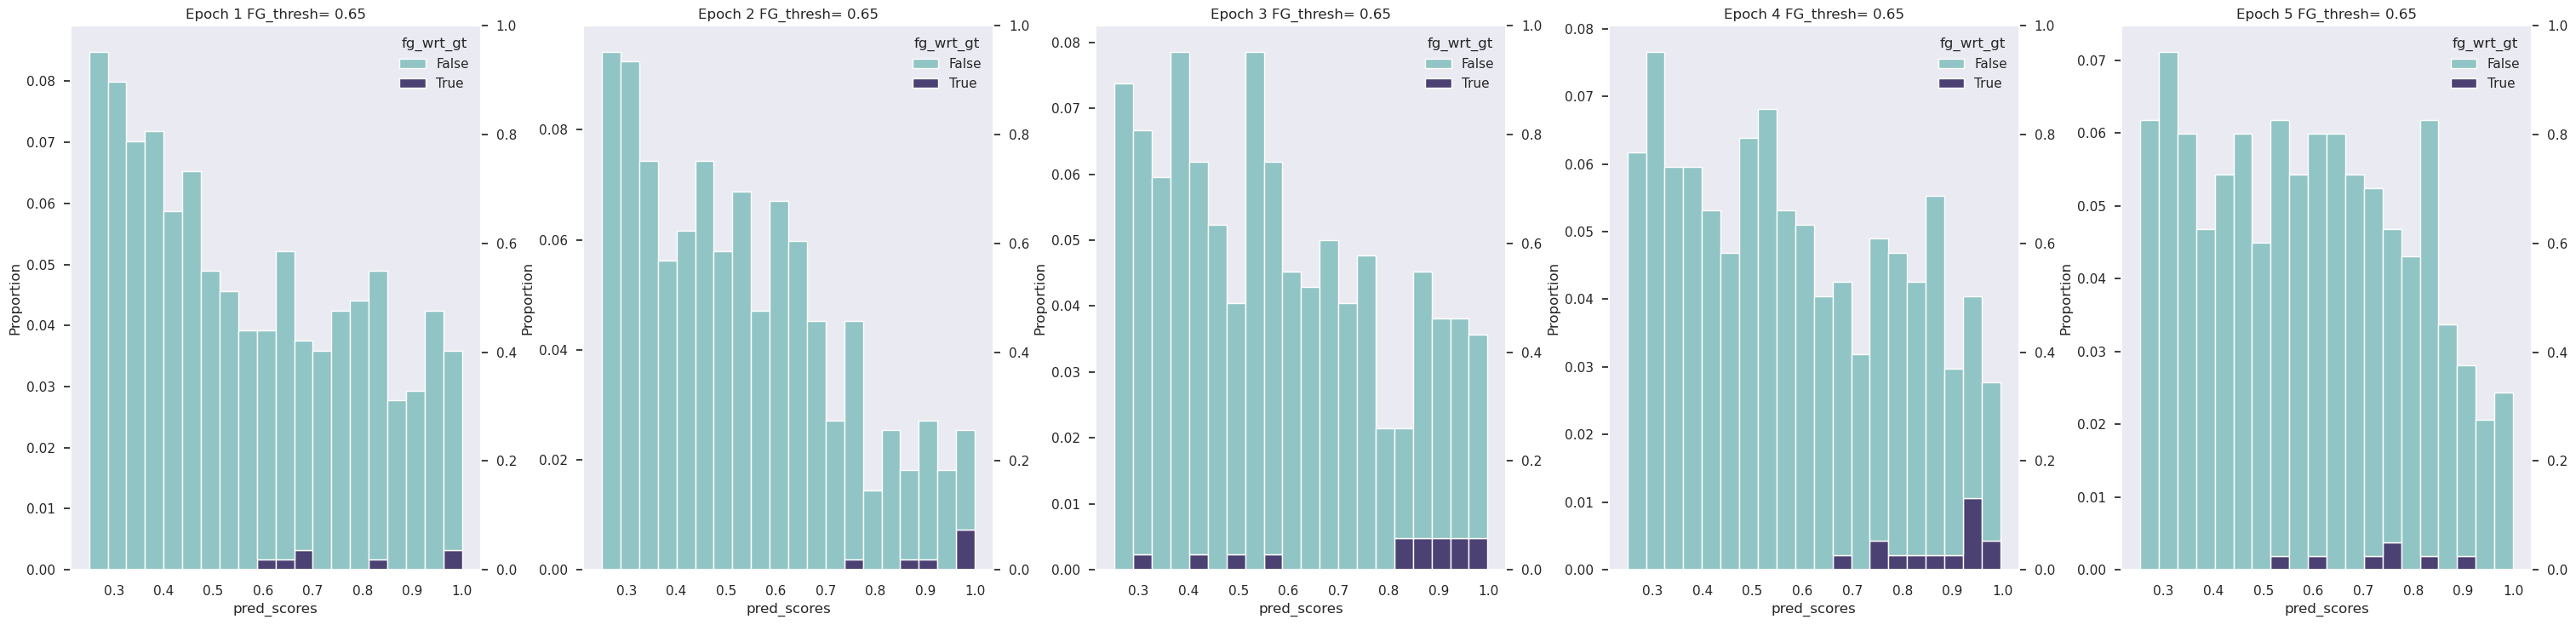

In [ ]:
plot_epoch(grouped_ot_pred_ped_df,1,6)

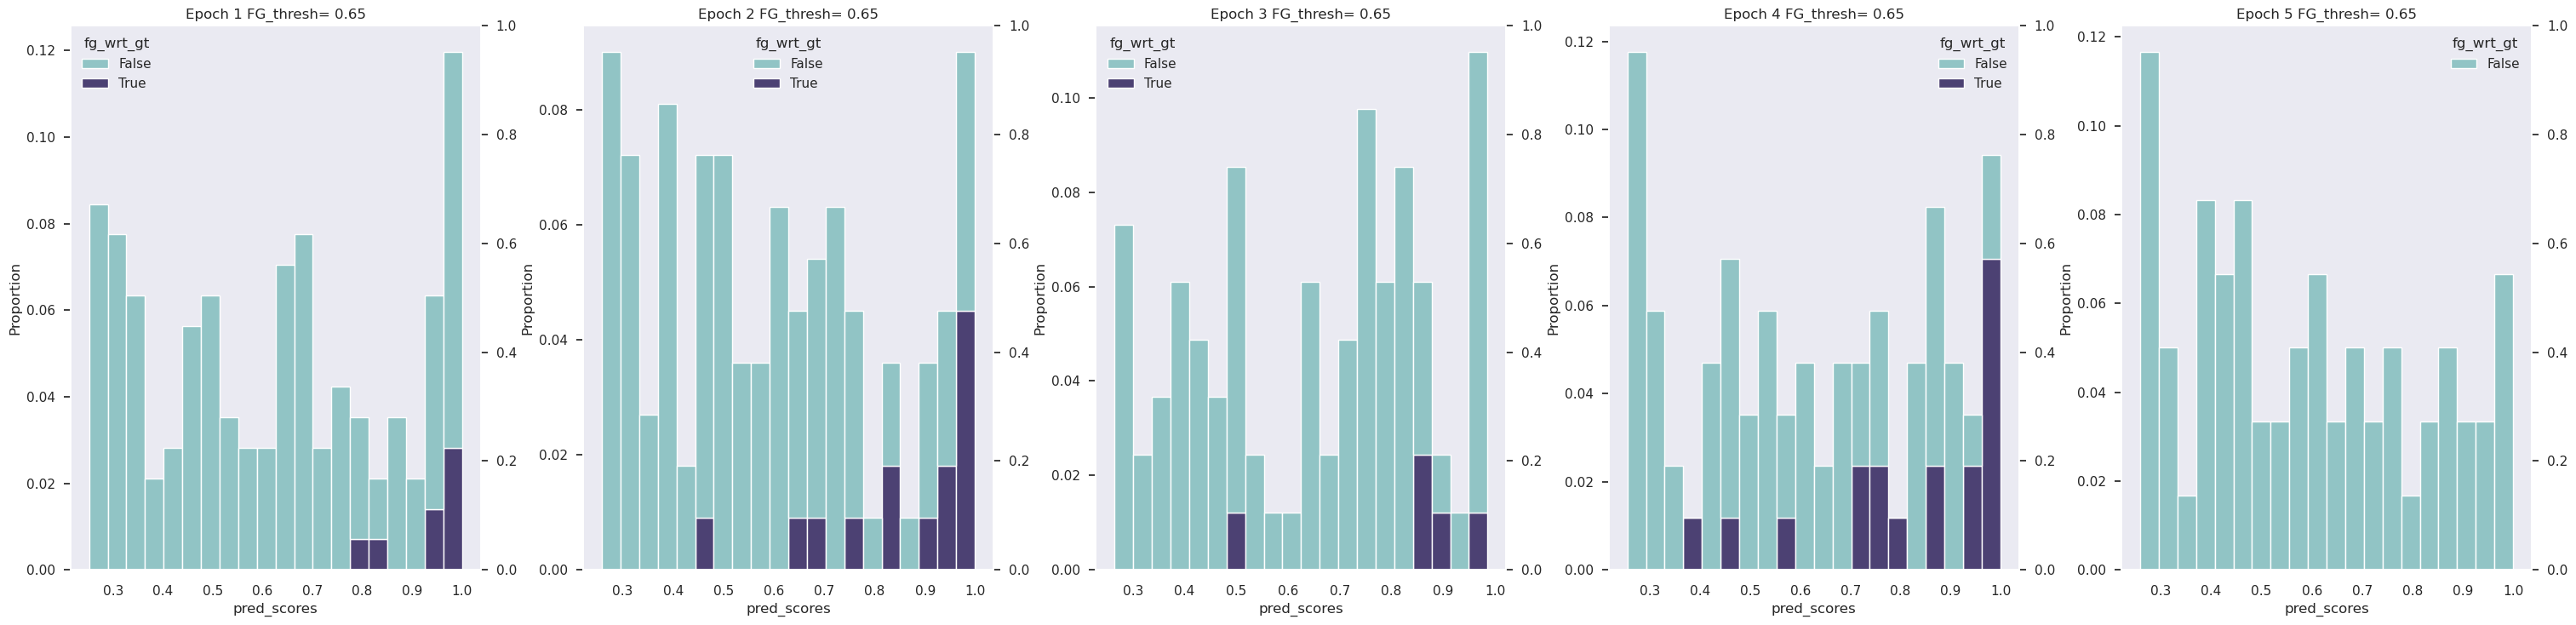

In [ ]:
plot_epoch(grouped_ot_pred_cyc_df,1,6)

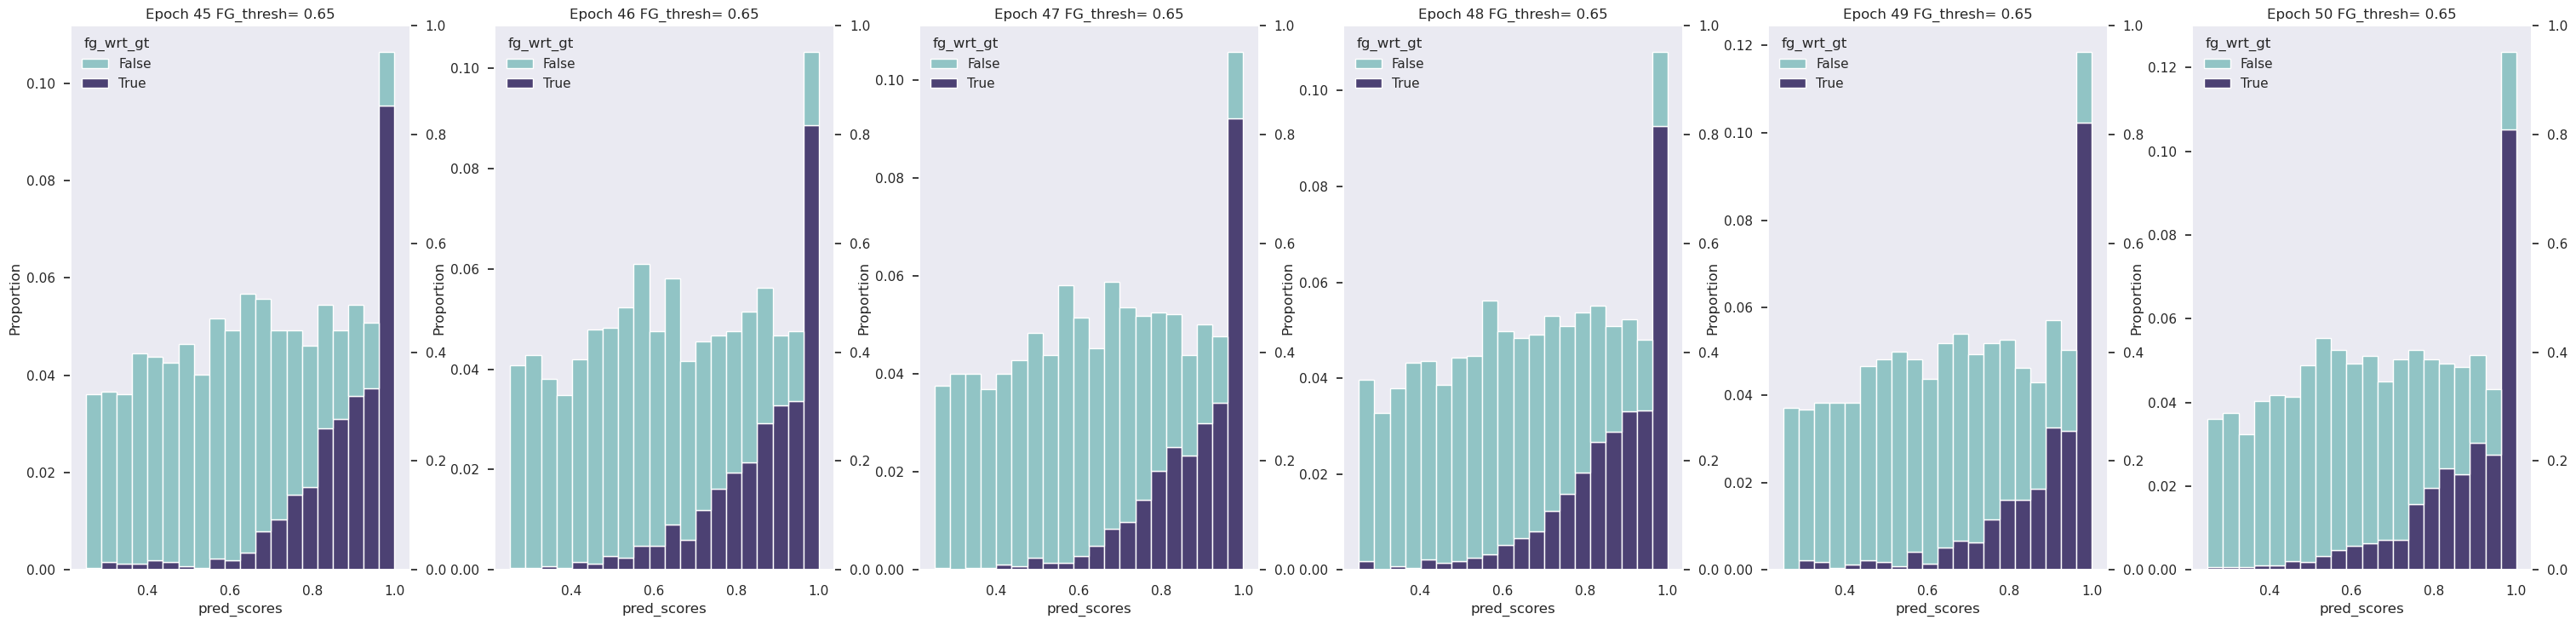

In [ ]:
plot_epoch(grouped_ot_pred_car_df,45,51)

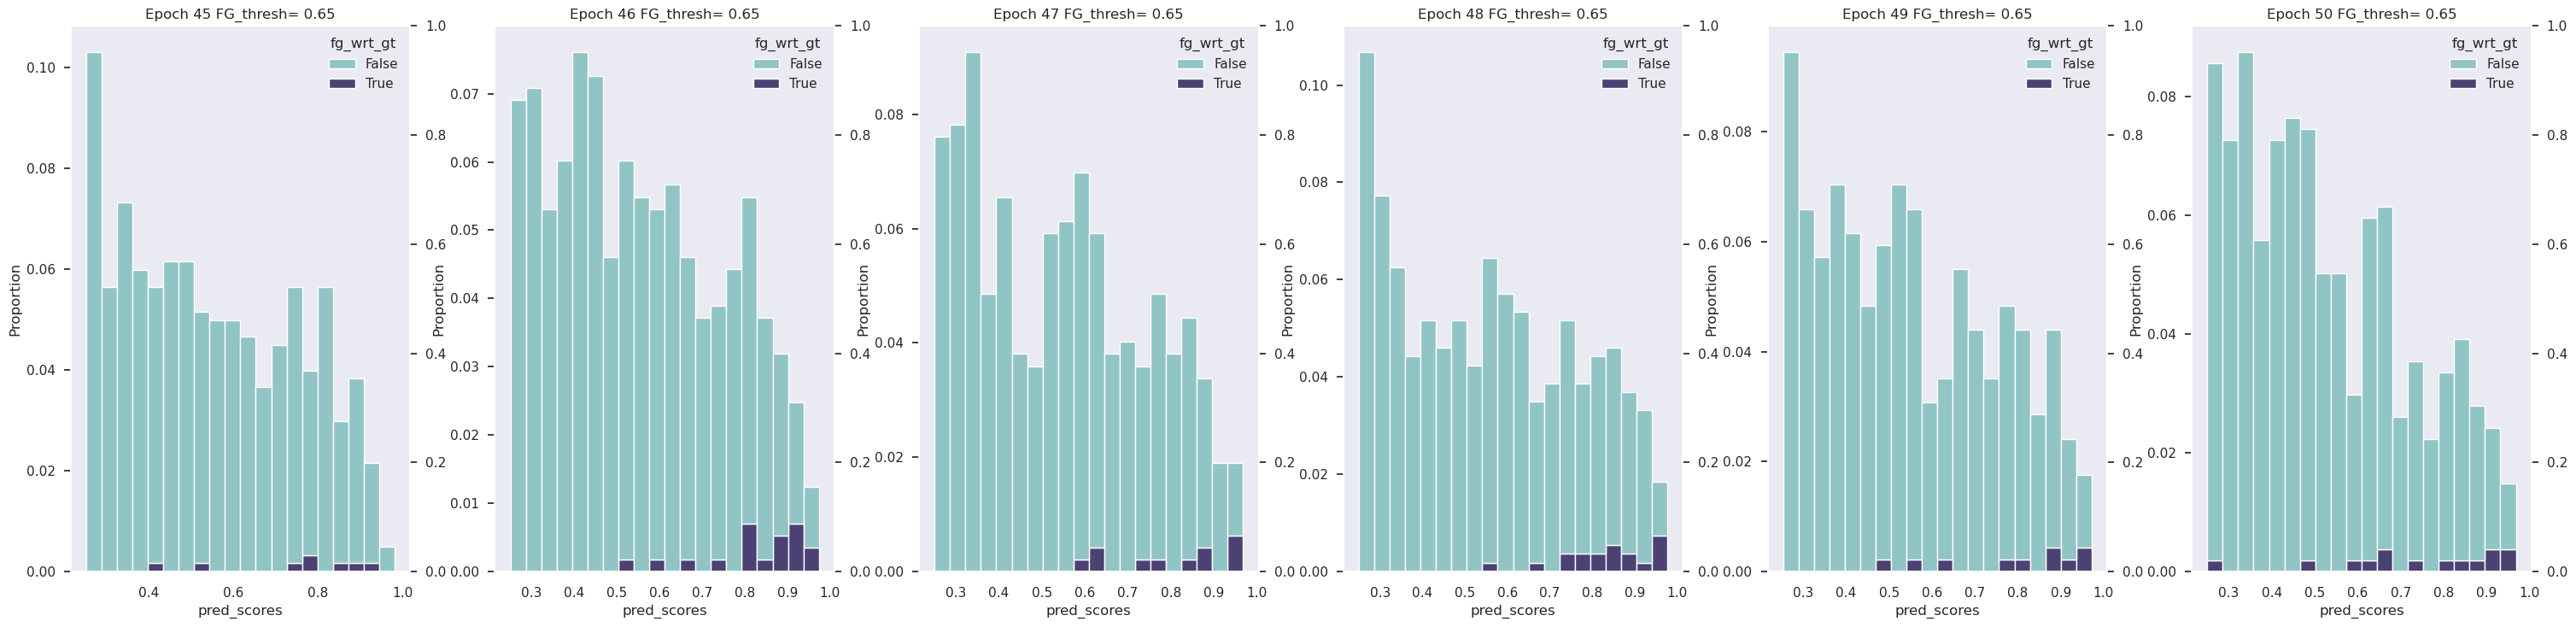

In [ ]:
plot_epoch(grouped_ot_pred_ped_df,45,51)

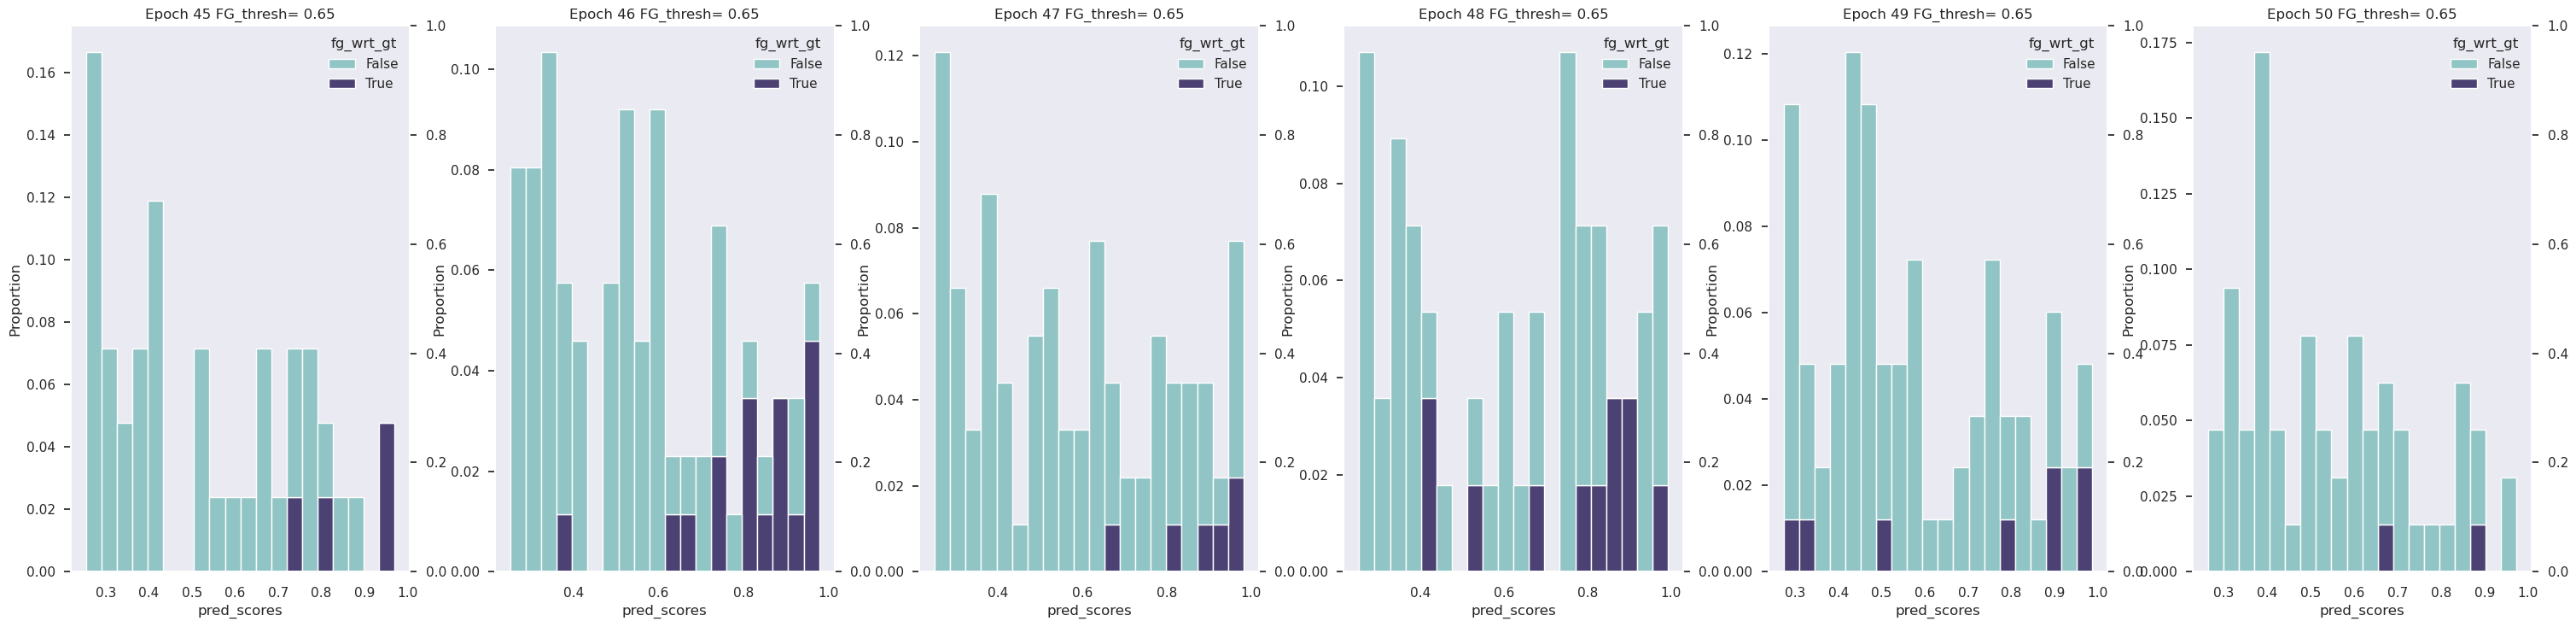

In [ ]:
plot_epoch(grouped_ot_pred_cyc_df,45,51)

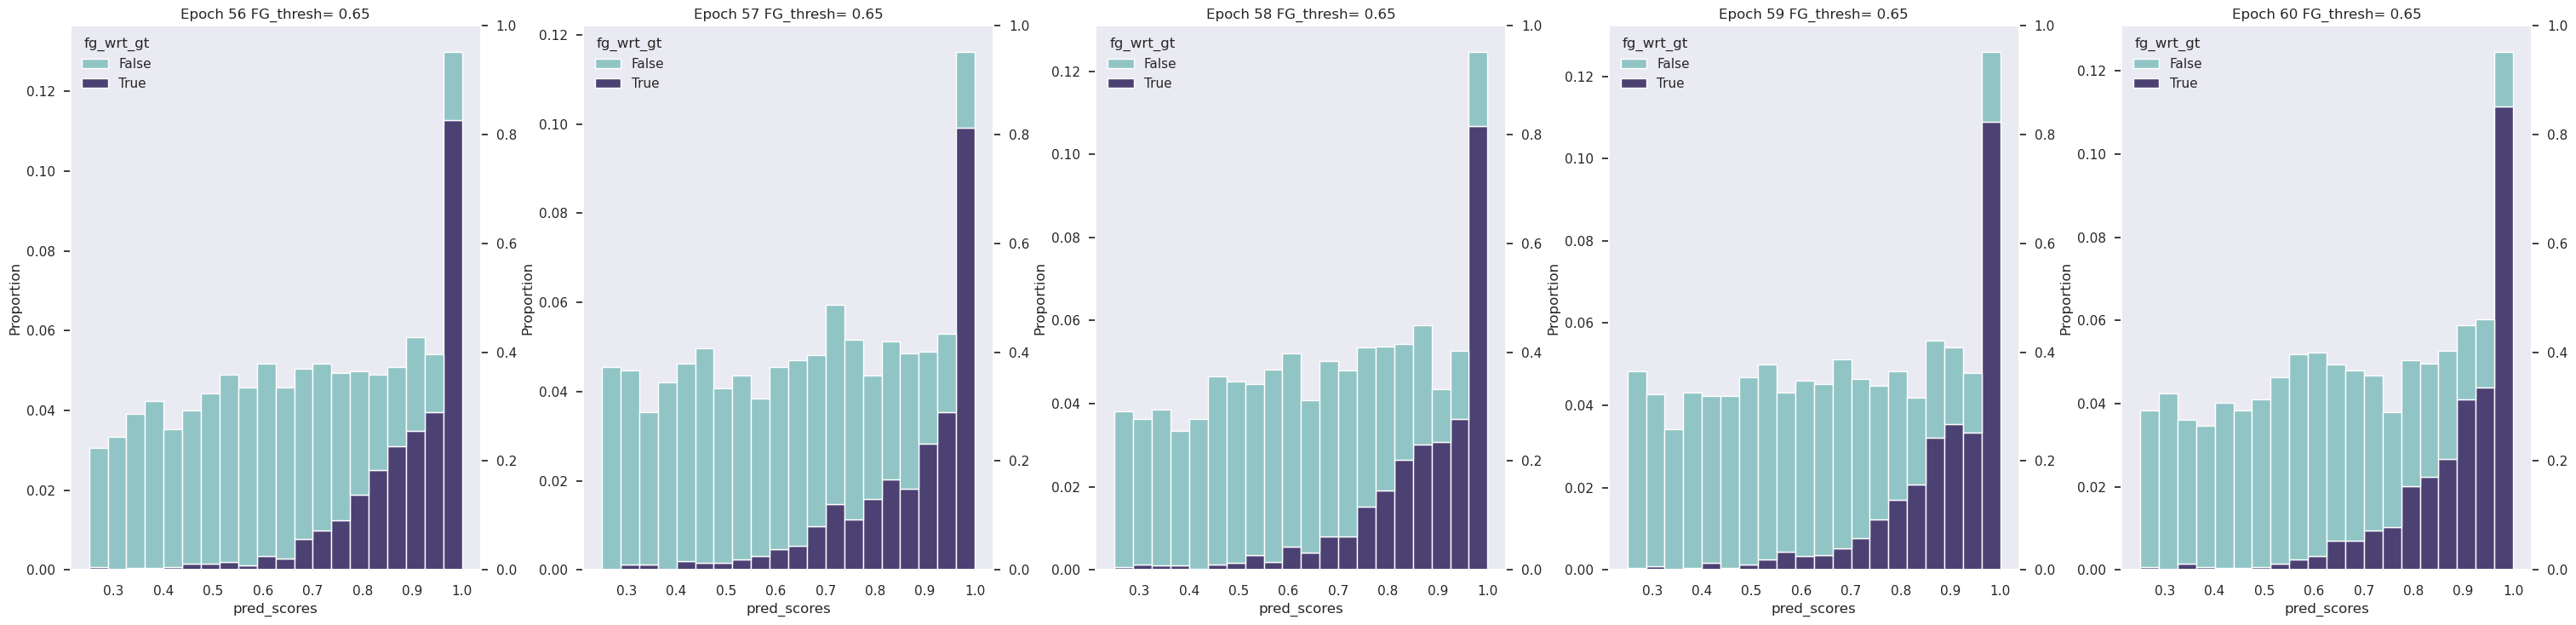

In [ ]:
plot_epoch(grouped_ot_pred_car_df,56,61)

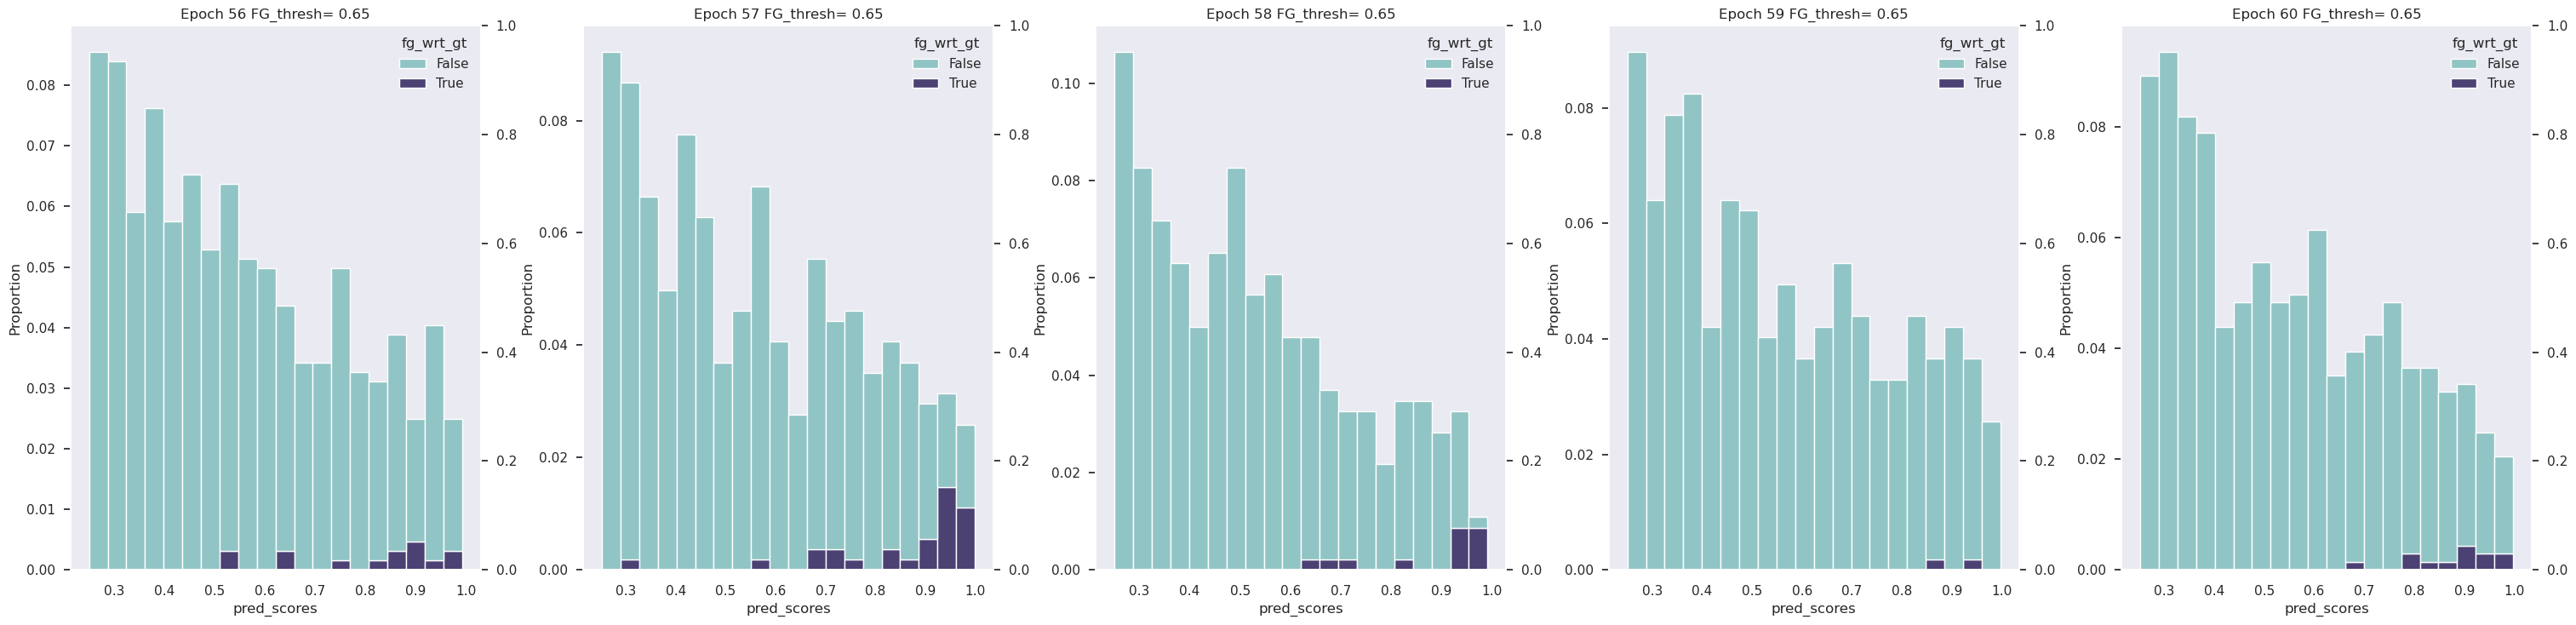

In [ ]:
plot_epoch(grouped_ot_pred_ped_df,56,61)

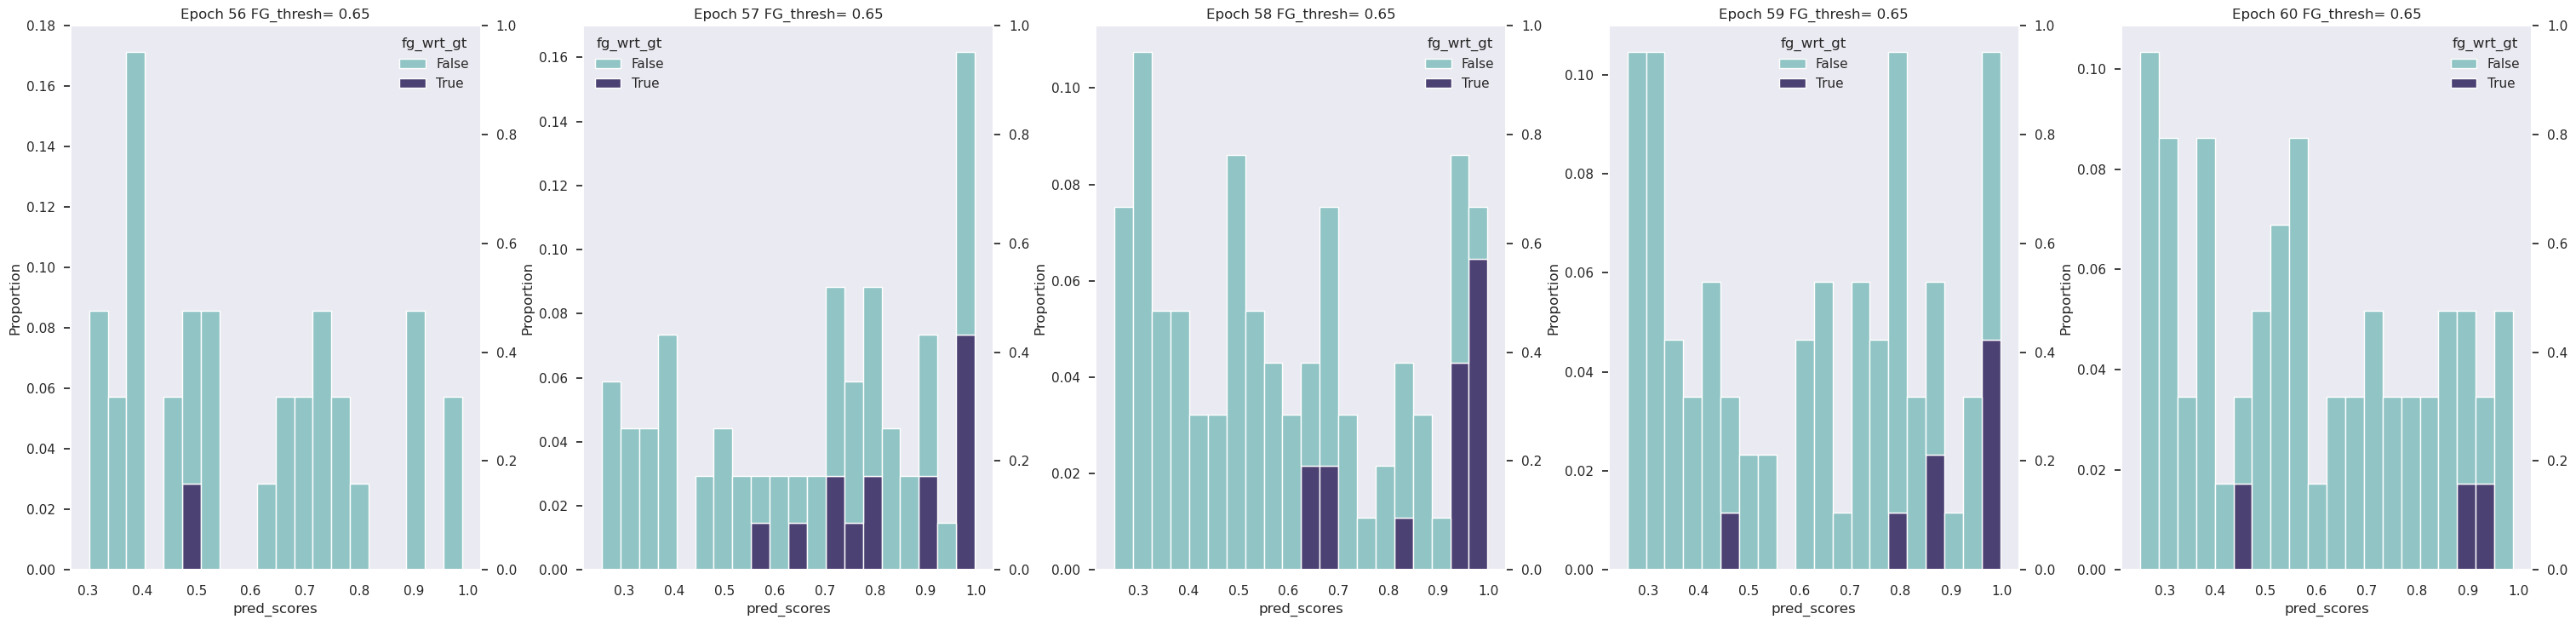

In [ ]:
plot_epoch(grouped_ot_pred_cyc_df,56,61)

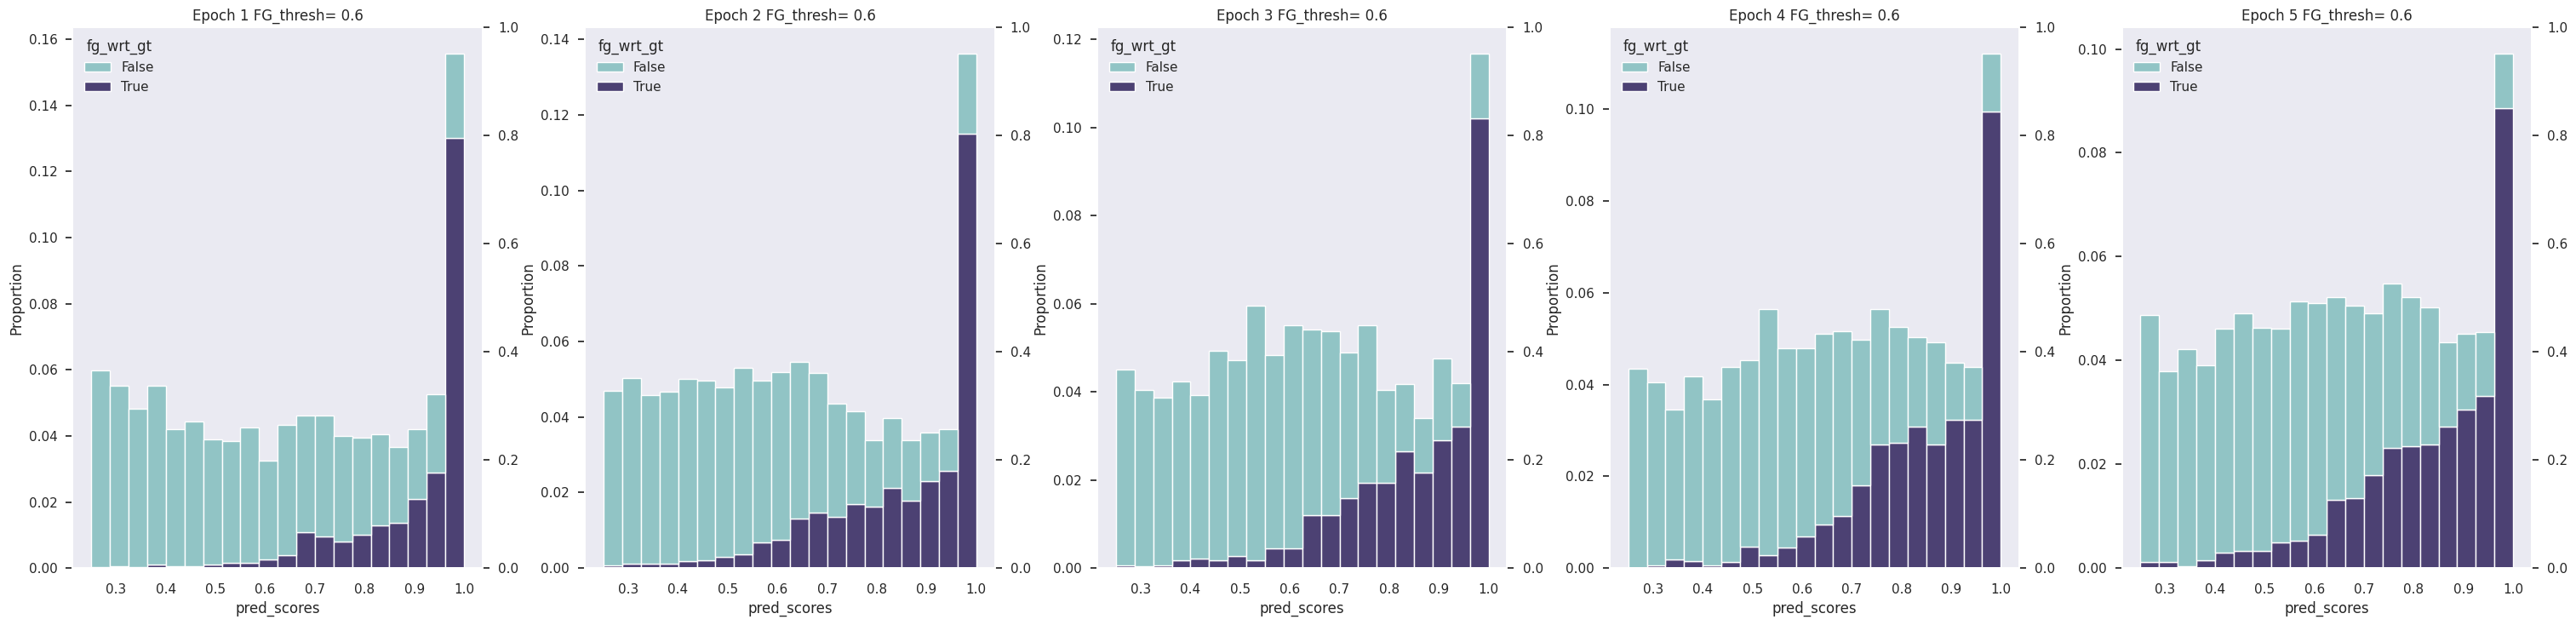

In [ ]:

def plot_epoch(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    # for i in range(0,3):
    # with PdfPages('plots.pdf') as pdf:
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(grouped_ot_pred_df,1,6)

In [ ]:
import numpy as np

def gaussian(row):
    x = row['pred_scores']
    # mu = row['mean']
    # sigma =8*row['variance']
    mu = 0.5
    sigma = 0.11
    exponent =  -1*(x - mu)**2 / 2*sigma**2
    scaler = 1/(1-mu)
    return scaler * np.exp(exponent)

def thresholding(row):
    row['gaussian'] = 1 if row['pred_scores'] >= row['threshold'] else row['gaussian']
    return row['gaussian']

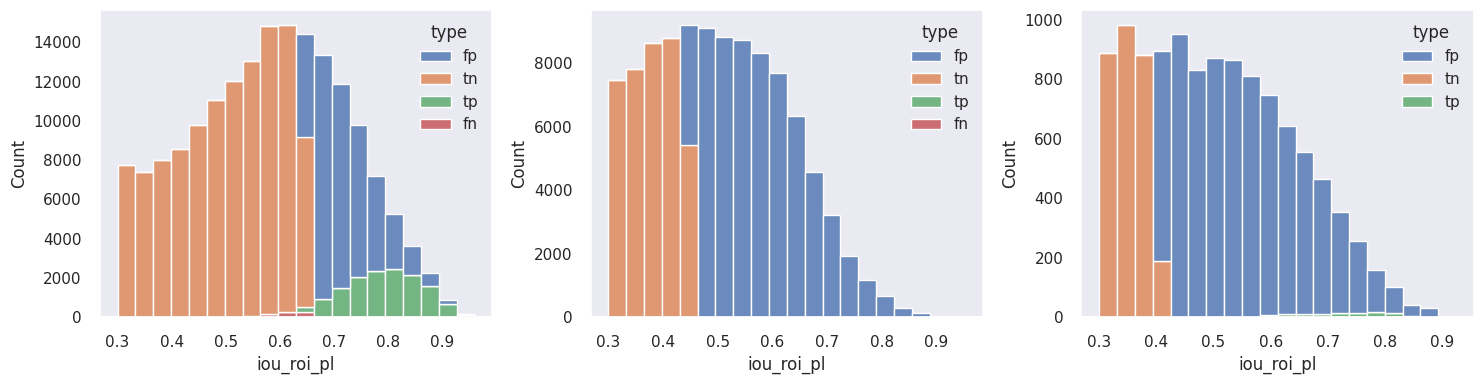

In [ ]:
stats = iou3d_old_thresh
fg_gt_thresh = 0.75
fg_pl_thresh = [0.65, 0.45, 0.4]

stats_dict = {
 'iou_roi_gt': stats['iou_roi_gt'],
 'iou_roi_pl': stats['iou_roi_pl'],
 'iteration' : stats['iteration'],
 'class_labels': stats['class_labels'],
 'pred_scores': stats['pred_scores']
}
stats_df = pd.DataFrame(stats_dict)
stats_df['type'] = 'none'
stats_df['epoch'] = (stats_df['iteration']) // 24 + 1
stats_df = stats_df[0.3 <= stats_df['iou_roi_pl']]
p = sns.color_palette('rocket')
palette = [p[0],p[2]]
f, axes = plt.subplots(1,3, figsize=(15,4))
for i in range(0,3):
 cls_df = stats_df[stats_df['class_labels'] == i + 1]
 tp_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (fg_pl_thresh[i] <= cls_df['iou_roi_pl'])
 fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (fg_pl_thresh[i] <= cls_df['iou_roi_pl'])
 fn_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < fg_pl_thresh[i])
 tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (cls_df['iou_roi_pl'] < fg_pl_thresh[i])
 cls_df['type'][tp_mask] = 'tp'
 cls_df['type'][fp_mask] = 'fp'
 cls_df['type'][fn_mask] = 'fn'
 cls_df['type'][tn_mask] = 'tn'

 sns.histplot(ax=axes[i],data=cls_df, x="iou_roi_pl",hue='type',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, alpha=0.8)
 f.tight_layout()
 f.subplots_adjust(wspace=0.25, hspace=0.2)
 # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
p = sns.color_palette("muted")
p

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

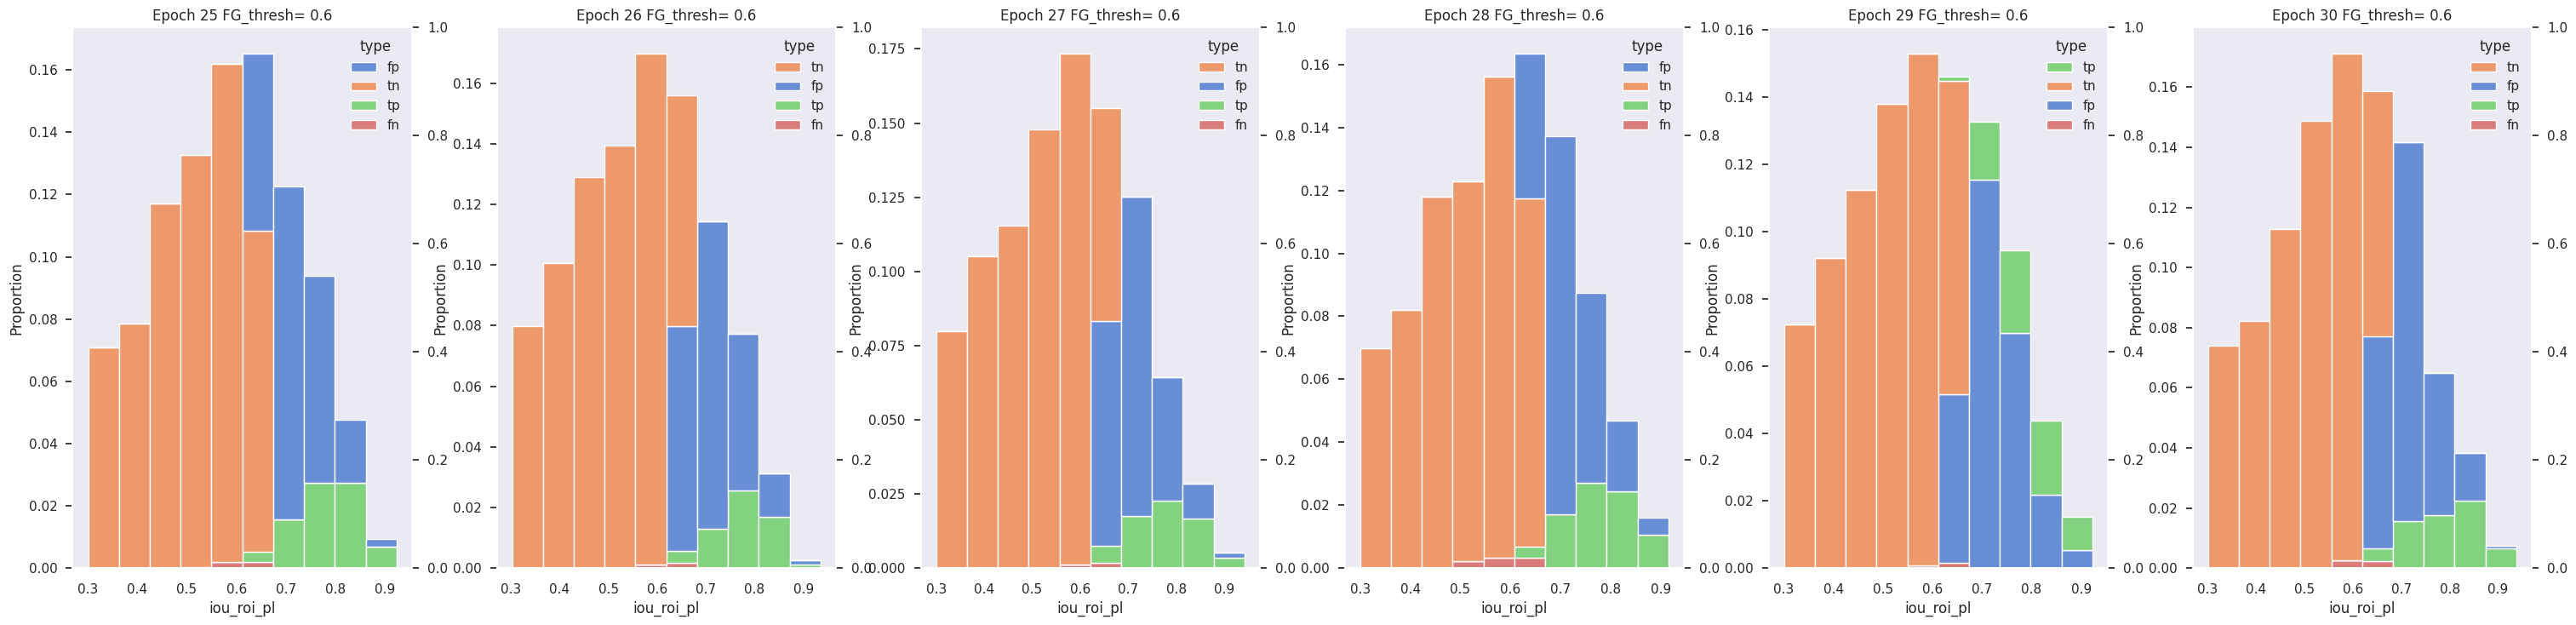

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch(df,cls,start,end):

    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    fg_gt_thresh = 0.75
    fg_pl_thresh = [0.65, 0.45, 0.4]
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    # group by each epoch
    grouped_df = df.groupby('epoch')
    cls_id = cls_map[cls]
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    palette = {'tp':p[2],'fp':p[0],'fn':p[3],'tn':p[1]}
    for i in range(start,end):
        # get particular epoch
        filter_df = grouped_df.get_group(float(i)) 
        cls_df = filter_df[filter_df['class_labels']==(cls_id)] # filter classes and tp fp fn tn classwise
        tp_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (fg_pl_thresh[cls_id-1] <= cls_df['iou_roi_pl']) 
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (fg_pl_thresh[cls_id-1] <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < fg_pl_thresh[cls_id-1])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (cls_df['iou_roi_pl'] < fg_pl_thresh[cls_id-1])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        sns.histplot(ax=axes[i-start],data=cls_df,x='iou_roi_pl',hue='type',multiple='stack',stat='proportion',bins=10,fill=True,alpha=0.8,palette=palette)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(stats_df,'Car',25,31)

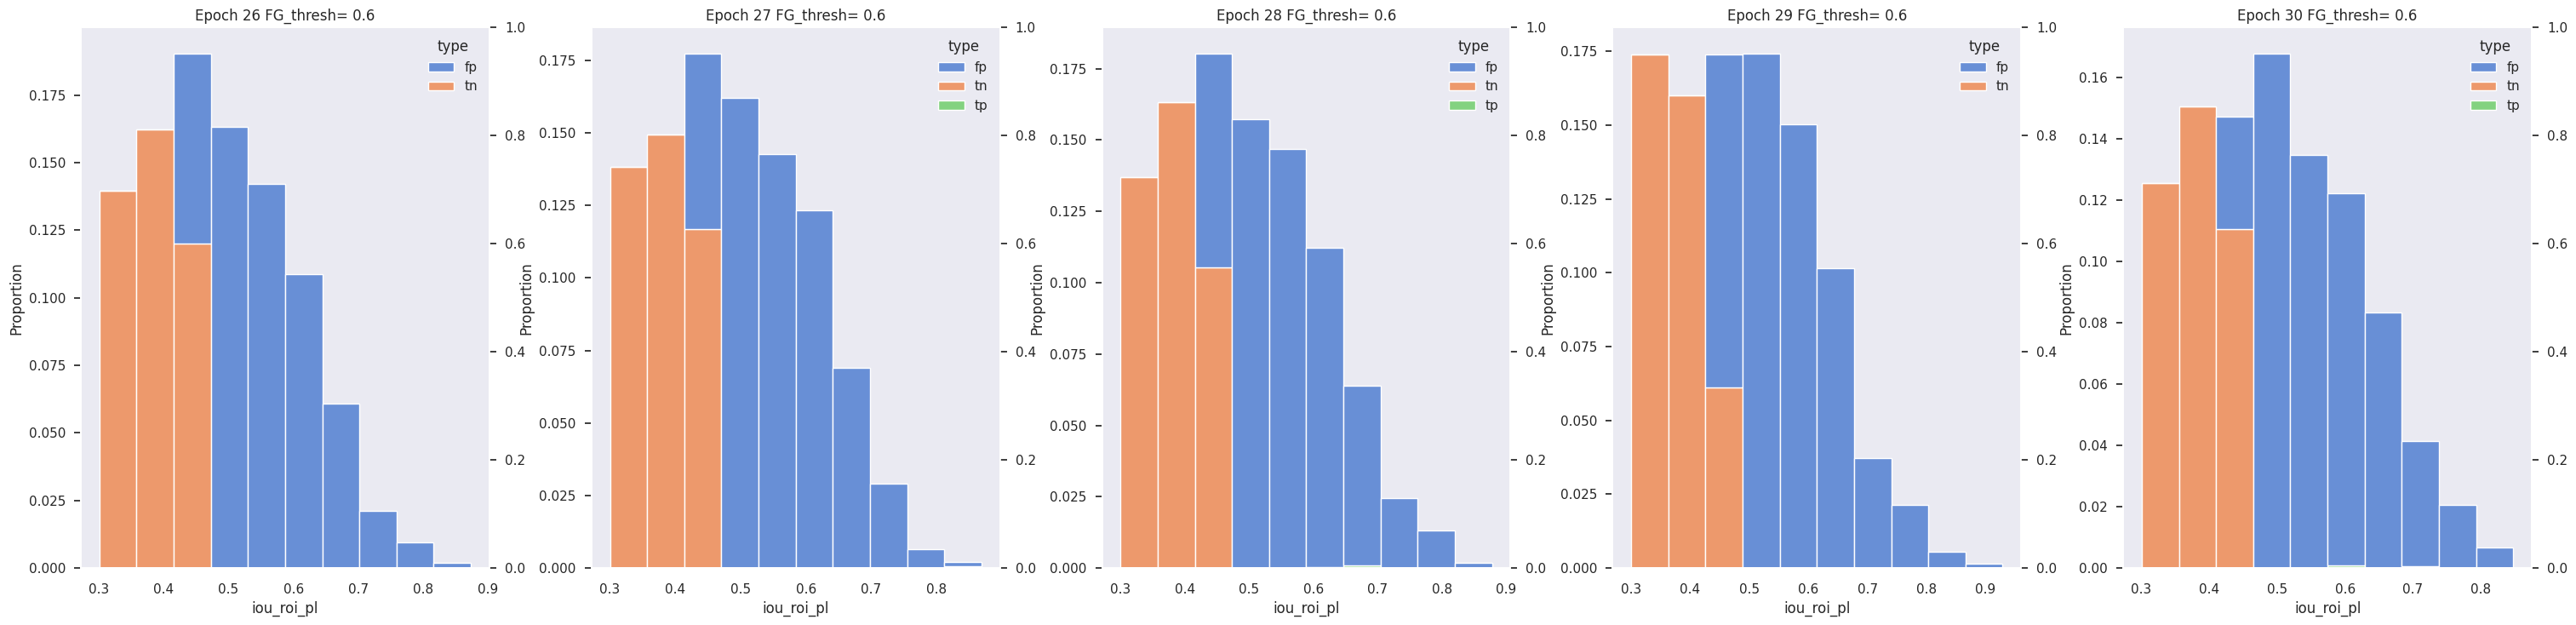

In [ ]:
plot_epoch(stats_df,'Ped',26,31)

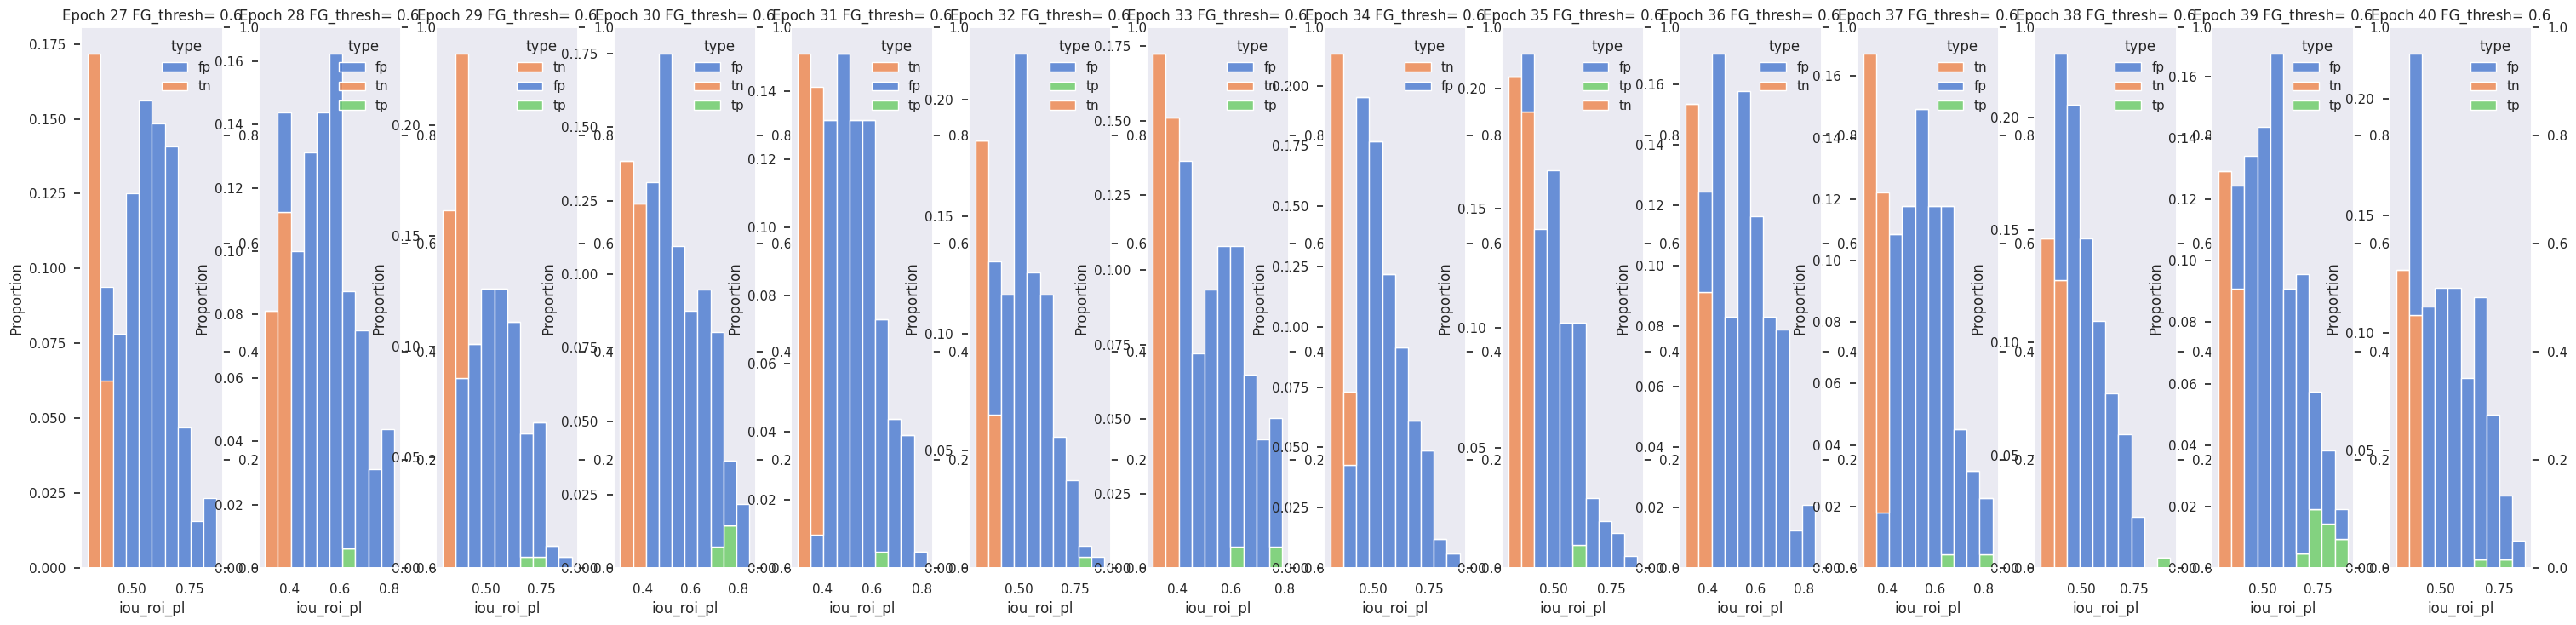

In [ ]:
plot_epoch(stats_df,'Cyc',27,31)

In [ ]:
iou3d_ot_iou_df['variance'] = iou3d_ot_iou_df.groupby('epoch')['pred_scores'].transform('var')
iou3d_ot_iou_df['mean'] = iou3d_ot_iou_df.groupby('epoch')['pred_scores'].transform('mean')

In [ ]:
iou3d_ot_iou_df

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores   
0         0.594777    0.697189        0.0             1     0.924146  \
1         0.686190    0.640282        0.0             1     0.880578   
2         0.000000    0.721479        0.0             1     0.771008   
3         0.000000    0.742094        0.0             2     0.814994   
4         0.000000    0.570624        0.0             1     0.601770   
...            ...         ...        ...           ...          ...   
707619    0.000000    0.259483     1439.0             3     0.001075   
707621    0.000000    0.545347     1439.0             2     0.049681   
707622    0.000000    0.430275     1439.0             2     0.370118   
707623    0.000000    0.369041     1439.0             3     0.003732   
707624    0.000000    0.545347     1439.0             2     0.051741   

        threshold  roi_scores  epoch  correct  fg_wrt_gt  variance      mean   
0             0.6    0.036497    1.0    False      False  0.115062  0.530350  \
1             0.6    0.043485    1.0     True       True  0.115062  0.530350   
2             0.6    0.829503    1.0    False      False  0.115062  0.530350   
3             0.6    0.491779    1.0    False      False  0.115062  0.530350   
4             0.6    0.057287    1.0    False      False  0.115062  0.530350   
...           ...         ...    ...      ...        ...       ...       ...   
707619        0.6    0.034821   60.0    False      False  0.115940  0.423004   
707621        0.6    0.316081   60.0    False      False  0.115940  0.423004   
707622        0.6    0.096573   60.0    False      False  0.115940  0.423004   
707623        0.6    0.064122   60.0    False      False  0.115940  0.423004   
707624        0.6    0.316081   60.0    False      False  0.115940  0.423004   

        gaussian  
0       1.000000  
1       1.000000  
2       1.000000  
3       1.000000  
4       1.000000  
...          ...  
707619  1.996990  
707621  1.997548  
707622  1.999796  
707623  1.997022  
707624  1.997570  

[318283 rows x 13 columns]

In [ ]:
iou3d_ot_iou_df['gaussian'] = iou3d_ot_iou_df.apply(gaussian,axis=1)
iou3d_ot_iou_df['gaussian'] = iou3d_ot_iou_df.apply(thresholding,axis=1)
grouped_ot_iouweights_df = iou3d_ot_iou_df.groupby('epoch')

In [ ]:
iou3d_ot_iou_df['bins'] = iou3d_ot_iou_df['pred_scores'].apply(lambda x: round(x,1))

In [ ]:
df = grouped_ot_iouweights_df.get_group(1)
iter_df = df[(df['bins'] == 0.9) & (df['class_labels']==1)]
iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0]

0.3857677902621723

In [ ]:
iou3d_ot_iou_df_thresh = iou3d_ot_iou_df[iou3d_ot_iou_df['pred_scores']>=0.4]
grouped_thresh_df = iou3d_ot_iou_df_thresh.groupby('epoch')

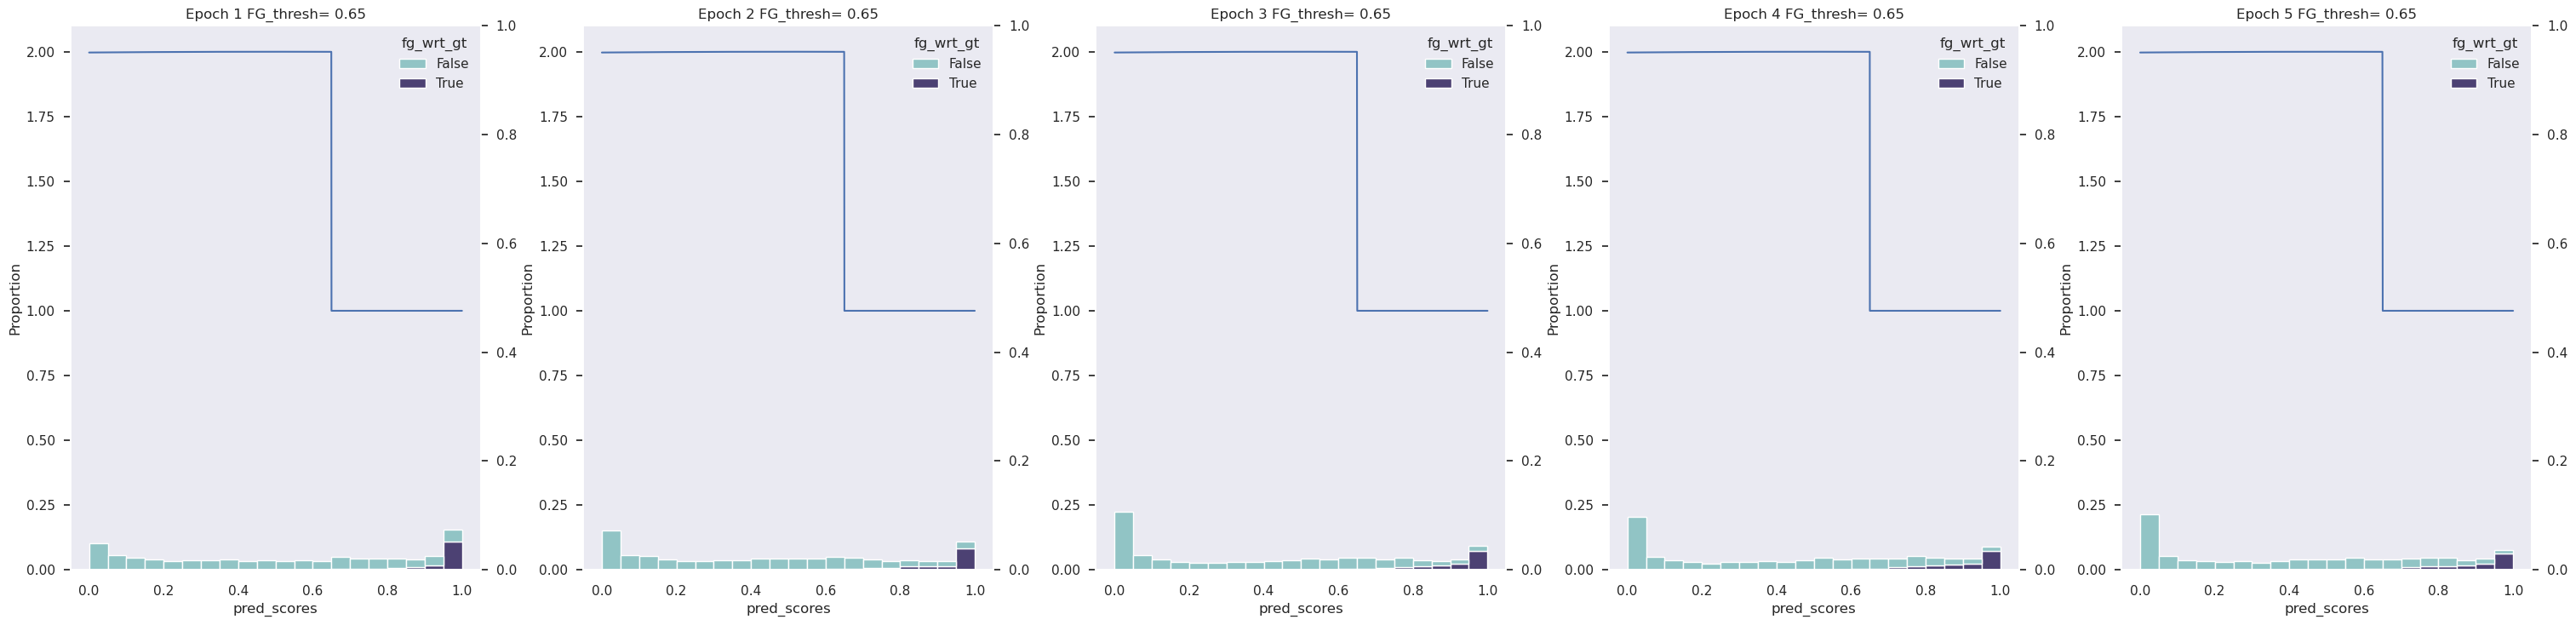

In [ ]:
def plot_epoch_with_gaussian(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        # sns.histplot(ax=axes[0],data=grouped_ot_iou_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        sns.lineplot(ax=axes[i-start],x=grouped_df.get_group(float(i))['pred_scores'],y=grouped_df.get_group(float(i))['gaussian'])
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch_with_gaussian(grouped_ot_iouweights_df,1,6)

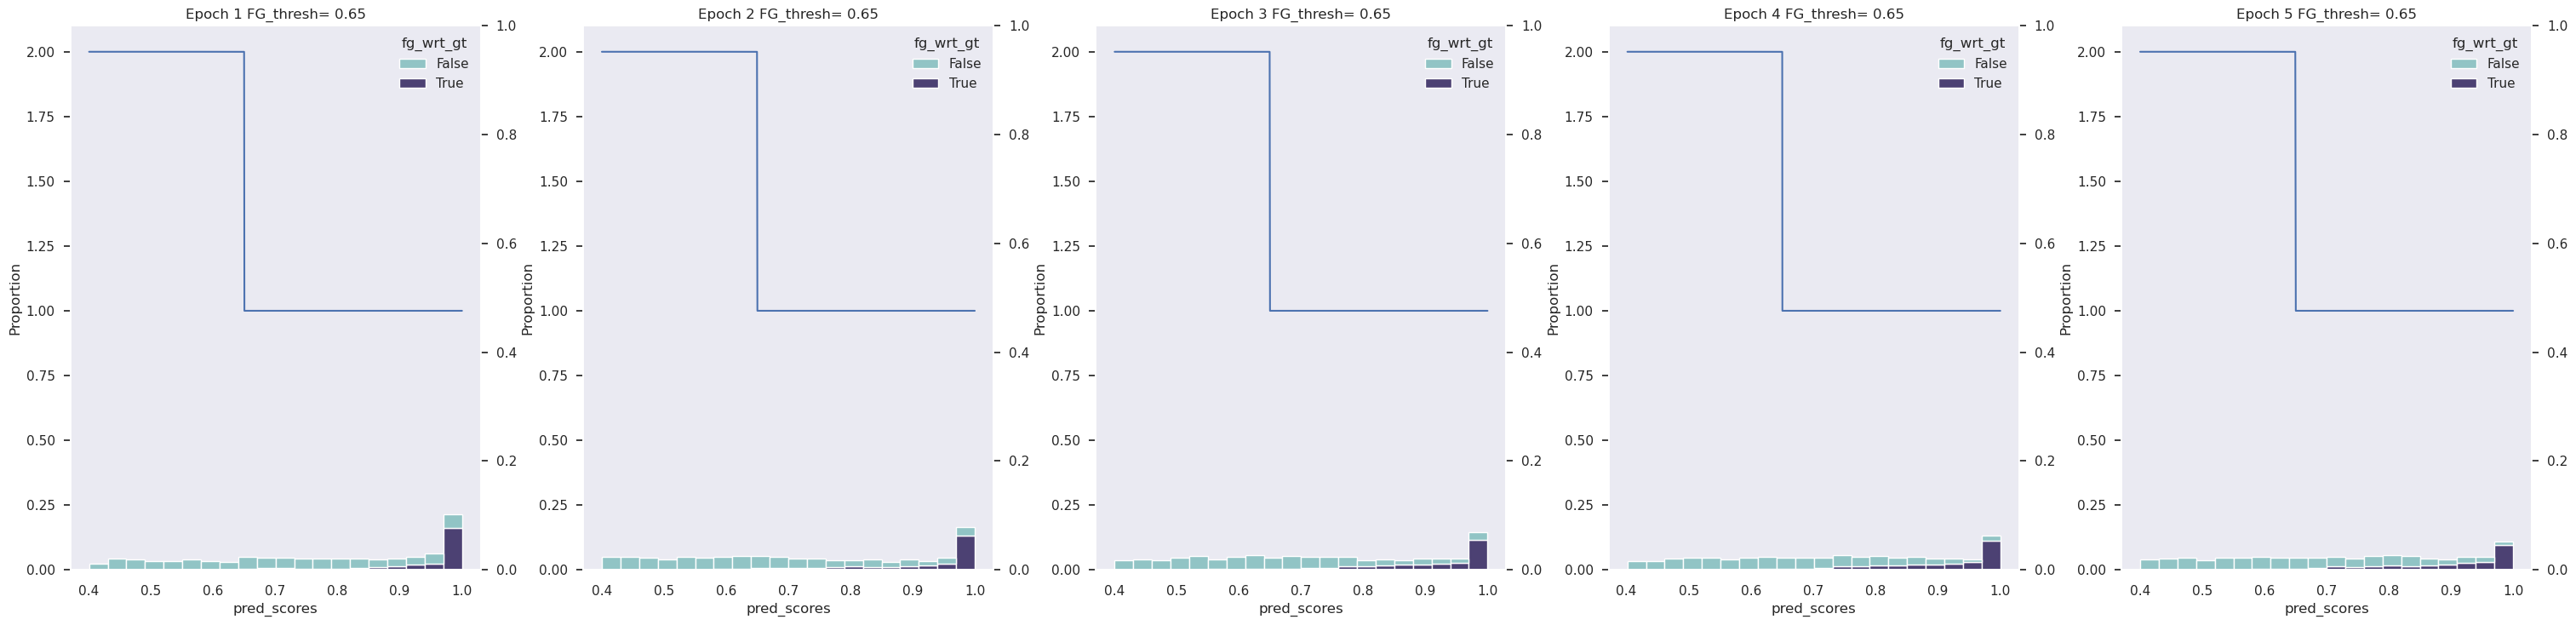

In [ ]:
plot_epoch_with_gaussian(grouped_thresh_df,1,6)

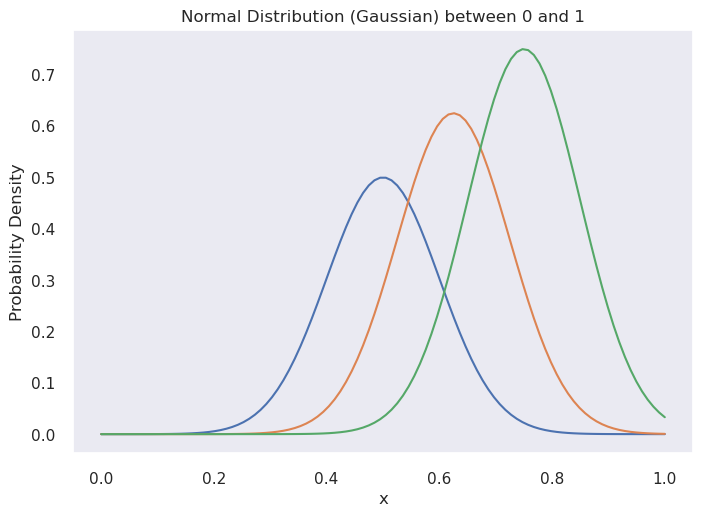

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    """
    Calculate the Gaussian probability density function (PDF) for a given input x,
    mean mu, and standard deviation sigma.
    
    Args:
        x (float or array-like): Input value(s) for which to calculate the PDF.
        mu (float): Mean of the Gaussian distribution.
        sigma (float): Standard deviation of the Gaussian distribution.
    
    Returns:
        float or ndarray: The probability density value(s) for the given input(s) x.
    """
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = mu
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.linspace(0.5,0.75,3)

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

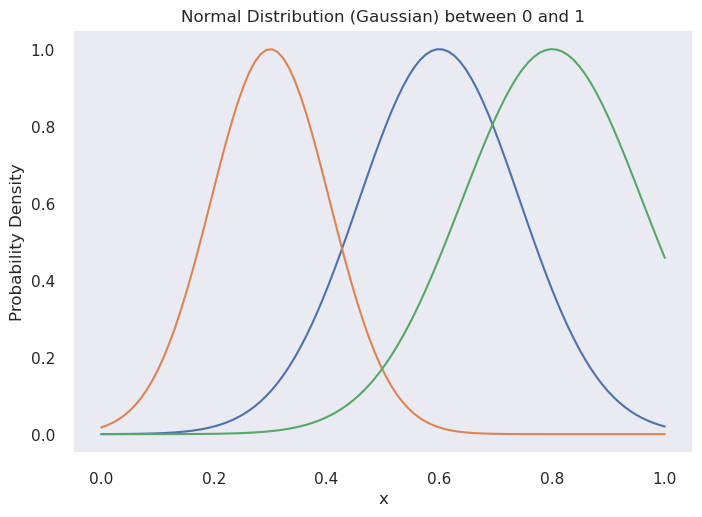

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2 / (mu*(4-mu))
    coefficient = 1 
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.array([0.6,0.3,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

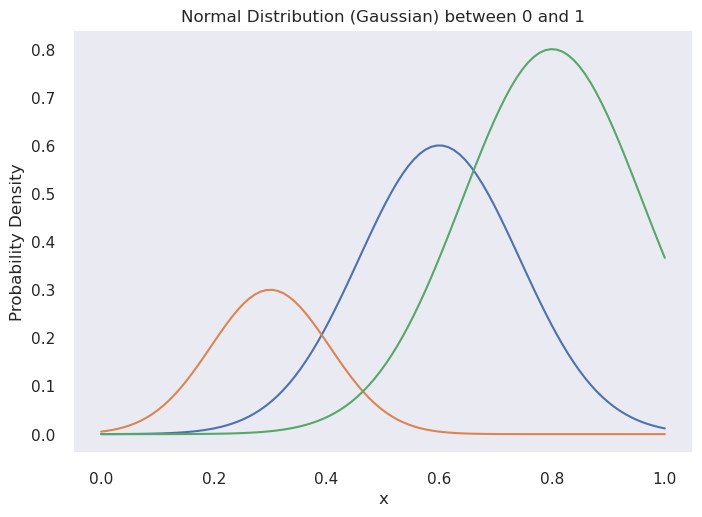

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2 / (mu*(4-mu))
    coefficient = mu 
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.array([0.6,0.3,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

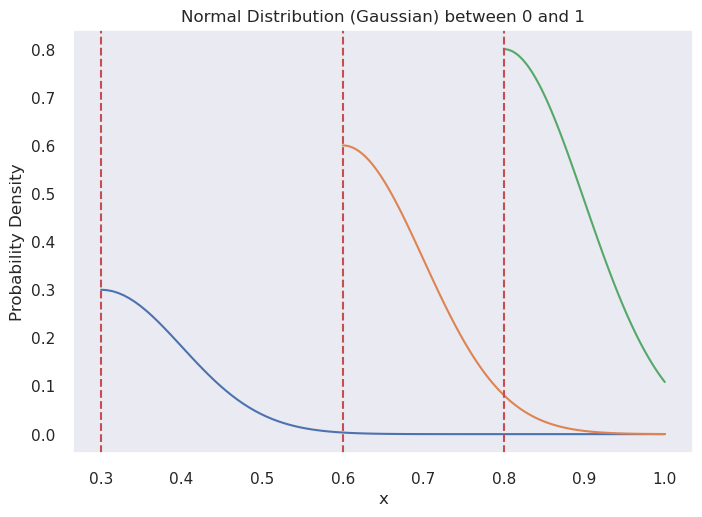

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = mu
    return (coefficient * np.exp(exponent))

# Generate x values

means = np.array([0.3,0.6,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    x = np.linspace(mu, 1.0, 100)
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")
    plt.axvline(x=mu, color='r', linestyle='--', label='Vertical Line at x=1')
# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()